In [5]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18 as cosmo
from scipy.interpolate import Akima1DInterpolator
from scipy import optimize as opt
import sys
import emcee
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

plt.rcParams['text.usetex']= True
plt.rcParams['mathtext.fontset']= 'custom'
plt.rcParams['mathtext.default']= 'rm'
plt.rcParams['axes.formatter.use_mathtext']=False

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading in CEERs_DR0.7_redshift_log.txt 
* Only saving sources which are flagged as H-alpha and H-beta emitters

207 sources in Vital catalog
redshift range: z = 0.284062 - 8.998295


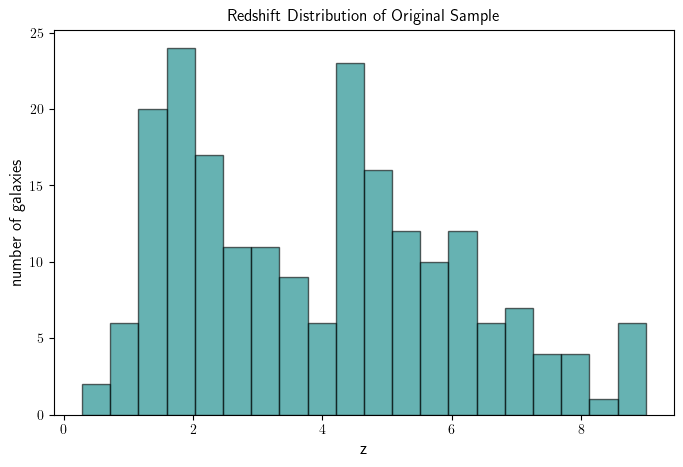

132 sources with flagged H-alpha, H-beta emission


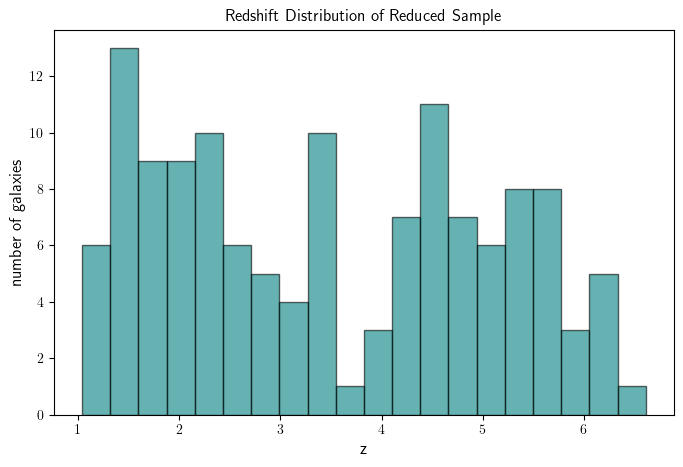

idx       sample      id  \
42    42  CEERs_DR0.7   515.0   
51    51  CEERs_DR0.7   618.0   
55    55  CEERs_DR0.7   669.0   
56    56  CEERs_DR0.7   672.0   
100  100  CEERs_DR0.7  1207.0   

                                                  file    z_mean     z_std  \
42   hlsp_ceers_jwst_nirspec_nirspec10-000515_comb-...  5.663987  0.000280   
51   hlsp_ceers_jwst_nirspec_nirspec10-000618_comb-...  6.048597  0.000519   
55   hlsp_ceers_jwst_nirspec_nirspec10-000669_comb-...  5.273267  0.001211   
56   hlsp_ceers_jwst_nirspec_nirspec10-000672_comb-...  5.663921  0.002389   
100  hlsp_ceers_jwst_nirspec_nirspec10-001207_comb-...  4.896624  0.000581   

                                                 lines      weight  
42   O2_3727A_m,H1_3971A,H1_4862A,O3_4960A,O3_5008A...  gauss_flux  
51   Ne5_3427A,O2_3727A_m,H1_4862A,O3_4960A,O3_5008...  gauss_flux  
55      O2_3727A_m,H1_4862A,O3_4960A,O3_5008A,H1_6565A  gauss_flux  
56   C3_1910A,H1_4862A,O3_4960A,O3_5008A,He1_5878A,...  gauss_flux  
100  O2_3727A_m,H1_4103A,H1_4341A,H1_4862A,O3_4960A...  gauss_flux

In [11]:
# Read the CEERS source information (redshifts) into a DataFrame
path1 = '../data/CEERs_DR0.7_redshift_log.txt'
z_log_df = pd.read_csv(path1, delim_whitespace=True, skiprows=0)
z_log_df = z_log_df.sort_values(by=['file']) # sorting by pointing and source ID

# only using mgrating sources (masking out PRISM sources)
mgrating_mask = list(z_log_df['file'].str.endswith('comb-mgrat_v0.7_x1d-masked.fits', na=False))
z_log_df = z_log_df[mgrating_mask]

# visualizing the range of redshift values for the original sample
print(len(z_log_df), 'sources in Vital catalog')
print('redshift range: z =', np.min(z_log_df['z_mean']), '-', np.max(z_log_df['z_mean']))
plt.figure(figsize=(8,5))
plt.title('Redshift Distribution of Original Sample')
plt.xlabel('z',fontsize=12)
plt.ylabel('number of galaxies',fontsize=12)
plt.hist(z_log_df['z_mean'],bins=20,color='teal',alpha=0.6,edgecolor='black')
plt.show()

# limiting sample to H-alpha and H-beta emitters 
lines = [i.split(',') for i in z_log_df['lines'].values]
lines_boolean = []
# using documented lines in z_log_df
for i, line_list in enumerate(lines):
    lines_boolean.append(('H1_6565A' in line_list) and ('H1_4862A' in line_list))  # H-gamma: 'H1_4341A' H-delta: 'H1_4103A'
z_log_df = z_log_df[lines_boolean]

# removing duplicates in log
z_log_df.drop_duplicates(subset=['id'],inplace=True)
print(len(z_log_df),'sources with flagged H-alpha, H-beta emission')
plt.figure(figsize=(8,5))
plt.title('Redshift Distribution of Reduced Sample')
plt.xlabel('z',fontsize=12)
plt.ylabel('number of galaxies',fontsize=12)
plt.hist(z_log_df['z_mean'],bins=20,color='teal',alpha=0.6,edgecolor='black')
plt.show()
z_log_df.head()

### Matching with JWST CEERS NIRSpec data

In [5]:
# read in CEERS medium grating data
NIRSpec_mgrat_fits = glob.glob('../data/nirspec_comb-mgrat_fits/*-masked.fits') 

# split fits string into source id string
ids = []
filenames = []
for i in NIRSpec_mgrat_fits:
    id_string = i.split('\\')[1].split('-')[1].split('_')[0]
    file_string = i.split('\\')[1]
    filenames.append(file_string)
    ids.append(id_string)
ids = np.array(ids).astype(int)

# saving in DataFrame
NIRSpec_mgrat_df = pd.DataFrame({
    'id': ids,
    'filenames': filenames,
    'fits': NIRSpec_mgrat_fits
})

# removing duplicates in CEERS mgrat data
NIRSpec_mgrat_df.drop_duplicates(subset=['id'],inplace=True)

# apply a mask to create the final subset
subset_mask1 = np.isin(NIRSpec_mgrat_df['id'].values, z_log_df['id'].values.astype(int))
subset_fits = np.array(NIRSpec_mgrat_df['fits'].values)[subset_mask1]
subset_mask2 = np.isin(z_log_df['id'].values.astype(int), NIRSpec_mgrat_df['id'].values)
z_log_df = z_log_df[subset_mask2]

# gathering IDs and redshift data 
ids = z_log_df['id'].values.astype(int)
z_vals = z_log_df['z_mean'].values
z_err_vals = z_log_df['z_std'].values

In [15]:
# creating data frame
NIRSpec_df = pd.DataFrame()
NIRSpec_df['ID'] = list(ids)
NIRSpec_df['FITS'] = list(subset_fits)
NIRSpec_df['REDSHIFT'] = list(z_vals)

# drop rows where ID == AGN_ids
AGN_ids = [2919,3129]
noisy_Hb = [669,2508] 
NIRSpec_df = NIRSpec_df[~NIRSpec_df['ID'].isin(AGN_ids)]
NIRSpec_df = NIRSpec_df[~NIRSpec_df['ID'].isin(noisy_Hb)]
NIRSpec_df = NIRSpec_df.reset_index(drop=True)

# gathering fits data
data = []
for i in NIRSpec_df['FITS']:
    hdu = fits.open(i)
    data.append(hdu[1].data)
NIRSpec_df.drop(['FITS'], axis=1, inplace=True)  # don't need fits files anymore

print(f'{len(data)} NIRSpec sources after manual sample cut')
print('redshift range: z =',min(NIRSpec_df['REDSHIFT']), '-',max(NIRSpec_df['REDSHIFT']), end='\n\n')
NIRSpec_df.head()

128 NIRSpec sources after manual sample cut
redshift range: z = 1.064851 - 6.612528



ID  REDSHIFT
0   515  5.663987
1   618  6.048597
2   672  5.663921
3  1207  4.896624
4  1212  4.277548

### Saving raw data

In [17]:
def flux_conversion(flux_freq,wavelength):
    '''
    converts flux density per unit freq to flux denisty per unit wavelength 

    args:
        flux_freq (float): flux density per unit frequency [Jy] --> [ergs/(s*cm^2*Hz)]
        wavelength (float): wavelength at the measured flux [A]

    returns (float): flux density per unit wavelength [erg/(s*cm^2*A)]
    '''
    flux_freq = (10**-23)*flux_freq # [Jy] --> [ergs/(s*cm^2*Hz)]
    c = 2.99702547*(10**18)  # [A/s]
    flux_wav = (flux_freq*c)/(wavelength**2)
    return flux_wav 
    
# raw data
# converting wavelengths from um to Angstroms
wavs = [i['WAVELENGTH']*10000 for i in data]
fluxes = [flux_conversion(i['FLUX'],i['WAVELENGTH']*10000) for i in data]
fluxes_err = [flux_conversion(i['FLUX_ERROR'],i['WAVELENGTH']*10000) for i in data]

# masking nan vals
flux_nan = [~np.isnan(i) for i in fluxes]
flux_err_nan = [~np.isnan(i) for i in fluxes_err]
nan_mask = [flux_nan[i] & flux_err_nan[i] for i in range(len(flux_nan))]

# cleaned data
wavs_cleaned = [wavs[i][nan_mask[i]] for i in range(len(wavs))]
fluxes_cleaned = [fluxes[i][nan_mask[i]] for i in range(len(wavs))]
fluxes_err_cleaned = [fluxes_err[i][nan_mask[i]] for i in range(len(wavs))]

### Finding center of emission lines of interest in raw data

In [23]:
def center_loc(wave,flux,line_obs):
    '''
    saves the closest data point to emission line of interest

    args:
        wave (list): list of wavelength values
        flux (list): list of flux values
        line_obs (list): list of emission line wavelengths in observed frame

    returns (list): list of data points closest to each emission line for all sources 
    '''
    centers = []
    for i in range(len(wave)):
        # finding indices around emission line
        near_peak = np.argwhere((wave[i] > line_obs[i]-50) & (wave[i] < line_obs[i]+50)) # [A]
        # finding peak index in this area
        peak = np.argmax(flux[i][near_peak])
        # calculating this index within the original array
        centers.append(int(near_peak[0]+peak))
    return centers

# H-alpha emission line info
Ha_rest = 6562.819 # [A]
Ha_line_obs = [Ha_rest*(j+1) for j in NIRSpec_df['REDSHIFT']]
Ha_center = center_loc(wavs_cleaned,fluxes_cleaned,Ha_line_obs)

# H-beta emission line info
Hb_rest = 4861.333 # [A]
Hb_line_obs = [Hb_rest*(j+1) for j in NIRSpec_df['REDSHIFT']]
Hb_center = center_loc(wavs_cleaned,fluxes_cleaned,Hb_line_obs)

### Plotting example source

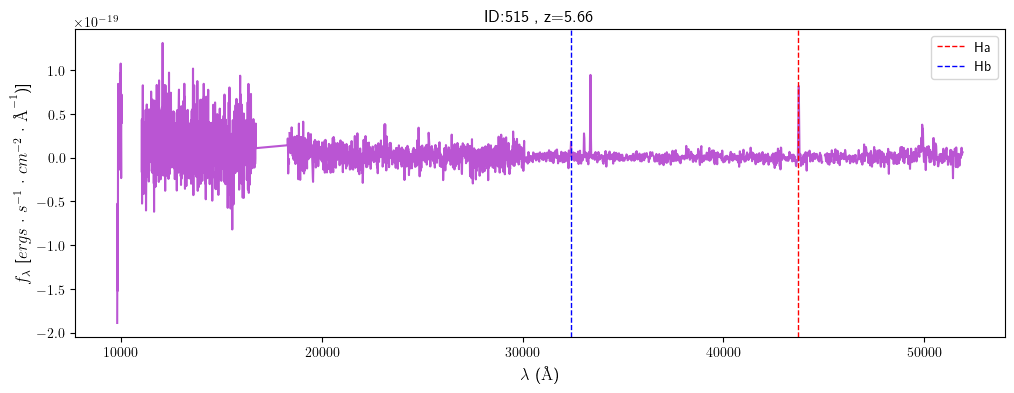

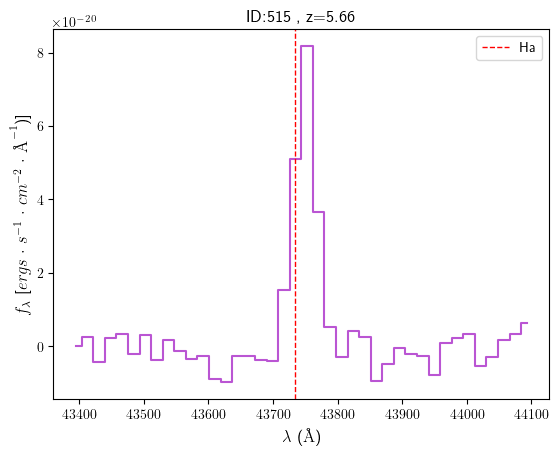

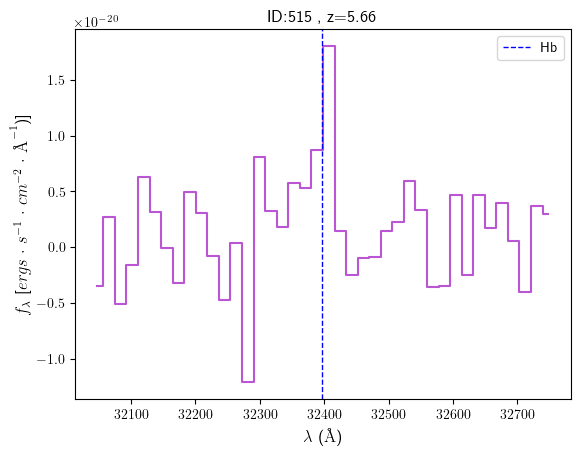

In [27]:
source = 0     # source index
window = 20     # pixel value of plotting window

# zoomed out plot
plt.figure(figsize=(12,4))
plt.title(f'ID:{NIRSpec_df['ID'][source]} , z={round(NIRSpec_df['REDSHIFT'][source],2)}')
plt.xlabel(r'$\lambda$ ($\rm{\AA}$)',fontsize=12)
plt.ylabel(r'$f_{\lambda}$ [$ergs$ $\cdot$ $s^{-1}$ $\cdot$ $cm^{-2}$ $\cdot$ $\rm{\AA}^{-1}$)]',fontsize=12)
plt.plot(wavs[source],fluxes[source],color='#BA55D3')
plt.axvline(Ha_line_obs[source],color='red',linestyle='dashed',linewidth=1,label='Ha')
plt.axvline(Hb_line_obs[source],color='blue',linestyle='dashed',linewidth=1,label='Hb')
plt.legend()
#plt.savefig('example_source.png',dpi=500)
plt.show()

# zoomed in plots
# H-alpha
Ha_wavs = wavs_cleaned[source][Ha_center[source]-window:Ha_center[source]+window]
Ha_fluxes = fluxes_cleaned[source][Ha_center[source]-window:Ha_center[source]+window]
plt.figure()
plt.title(f'ID:{NIRSpec_df['ID'][source]} , z={round(NIRSpec_df['REDSHIFT'][source],2)}')
plt.xlabel(r'$\lambda$ ($\rm{\AA}$)',fontsize=12)
plt.ylabel(r'$f_{\lambda}$ [$ergs$ $\cdot$ $s^{-1}$ $\cdot$ $cm^{-2}$ $\cdot$ $\rm{\AA}^{-1}$)]',fontsize=12)
plt.step(Ha_wavs, Ha_fluxes, c='#BA55D3',where='mid')
plt.axvline(Ha_line_obs[source],color='red',linestyle='dashed',linewidth=1,label='Ha')
plt.legend()
#plt.savefig('example_source_Ha.png',dpi=500)
plt.show()

# H-beta
Hb_wavs = wavs_cleaned[source][Hb_center[source]-window:Hb_center[source]+window]
Hb_fluxes = fluxes_cleaned[source][Hb_center[source]-window:Hb_center[source]+window]
plt.figure()
plt.title(f'ID:{NIRSpec_df['ID'][source]} , z={round(NIRSpec_df['REDSHIFT'][source],2)}')
plt.xlabel(r'$\lambda$ ($\rm{\AA}$)',fontsize=12)
plt.ylabel(r'$f_{\lambda}$ [$ergs$ $\cdot$ $s^{-1}$ $\cdot$ $cm^{-2}$ $\cdot$ $\rm{\AA}^{-1}$)]',fontsize=12)
plt.step(Hb_wavs, Hb_fluxes, c='#BA55D3',where='mid')
plt.axvline(Hb_line_obs[source],color='blue',linestyle='dashed',linewidth=1,label='Hb')
plt.legend()
#plt.savefig('example_source_Hb.png',dpi=500)
plt.show()

### Defining initial fitting with scipy.optimize.curve_fit

In [29]:
def gaussian(x, A, mu, sigma):
    '''
    Gaussian Model for Line Fitting
    '''
    return A * np.exp(-(x - mu)**2/ (sigma**2))

def linear(x, b):
    '''
    Continuum of the spectra using y = b
    '''
    return  np.ones(len(x))*b

def Hb_line_model(x, A, mu, sigma, b):
    '''
    Emission line model using a single gaussian and the continuum
    '''
    return gaussian(x, A, mu, sigma) + linear(x, b)

def Ha_line_model(x, A, A1_NII, mu, sigma, b):
    '''
    Emission line model using 3 gaussians and the continuum to fit H-alpha NII complex
    A: H-alpha amplitude
    A1_NII: Amplitude of bluer NII line (in which the redder line depends upon)
    mu: center of H-alpha line
    sigma: sigmas for H-alpha and NII doublet are set as the same (theoretically coming from the same gas cloud)
    b: continuum offset of H-alpha
    '''
    # rest frame wavelengths
    Ha_rest = 6562.819
    NII_1_rest = 6548.050
    NII_2_rest = 6583.460
    # expected emission line centers
    mu1_NII = mu*(NII_1_rest / Ha_rest)
    mu2_NII = mu*(NII_2_rest / Ha_rest)
    
    # initialize amplitudes of NII lines to have a ~3:1 ratio
    A2_NII = A1_NII*2.99
    
    return gaussian(x, A1_NII, mu1_NII, sigma) + gaussian(x, A, mu, sigma) + gaussian(x, A2_NII, mu2_NII, sigma) + linear(x, b)

### Running curve_fit for H-alpha

In [31]:
# intializing dataframe
columns = ['ppots', 'A', 'A_err', 'mu', 'sigma', 'b']
Ha_curve_fit_df = pd.DataFrame(columns=columns)

for source in range(len(NIRSpec_df['ID'])):

    Ha_wavs = wavs_cleaned[source][Ha_center[source]-window:Ha_center[source]+window]
    Ha_fluxes = fluxes_cleaned[source][Ha_center[source]-window:Ha_center[source]+window]
    
    # initial guesses
    A = fluxes_cleaned[source][Ha_center[source]]
    A_NII = 0.1*A
    mu = wavs_cleaned[source][Ha_center[source]] #Ha_line_obs[source] 
    sigma = 20 # [A]
    b = 0
    p0 = (A, A_NII, mu, sigma, b)

    lower_bounds = [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
    upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf]
    
    # fitting
    ppot,ppcov = curve_fit(Ha_line_model,Ha_wavs,Ha_fluxes,p0=p0,bounds=(lower_bounds, upper_bounds)) 
    perr = np.sqrt(np.diag(ppcov))
    
    # storing curve_fit results for each source (skipping saving NII amplitude, index=1, for now)
    new_row = [ppot,ppot[0],perr[0],ppot[2],ppot[3],ppot[4]]
    df_extended = pd.DataFrame(data=[new_row], columns=columns)
    Ha_curve_fit_df = pd.concat([Ha_curve_fit_df, df_extended],ignore_index=True)

Ha_curve_fit_df.head()

ppots             A  \
0  [8.17972523281699e-20, -1.3659116175647478e-21...  8.179725e-20   
1  [4.634402855042861e-20, 1.3168058180089851e-21...  4.634403e-20   
2  [4.60080773780754e-20, 2.9386538541455563e-22,...  4.600808e-20   
3  [3.0121628179649496e-20, -5.666142472426285e-2...  3.012163e-20   
4  [3.014690032337493e-20, 2.087312801387192e-22,...  3.014690e-20   

          A_err            mu      sigma             b  
0  3.876287e-21  43750.249975  23.823347 -1.049889e-21  
1  6.124923e-21  46266.895661  19.085180  6.992309e-23  
2  2.954898e-21  43755.841394  37.661834  3.815883e-21  
3  3.587756e-21  38703.106501  22.082107  2.574394e-21  
4  3.846128e-21  34640.687861  22.942844  2.640897e-21

### Running curve_fit for H-beta

In [33]:
# intializing dataframe
columns = ['ppots', 'A', 'A_err', 'mu', 'sigma', 'b']
Hb_curve_fit_df = pd.DataFrame(columns=columns)

for source in range(len(NIRSpec_df['ID'])):

    Hb_wavs = wavs_cleaned[source][Hb_center[source]-window:Hb_center[source]+window]
    Hb_fluxes = fluxes_cleaned[source][Hb_center[source]-window:Hb_center[source]+window]
        
    # initial guesses
    A = fluxes_cleaned[source][Hb_center[source]]
    mu = wavs_cleaned[source][Hb_center[source]] #Hb_line_obs[source]
    sigma = 20 # [A]
    b = 0      
    p0 = (A, mu, sigma, b)

    lower_bounds = [-np.inf, -np.inf, -np.inf, -np.inf]
    upper_bounds = [np.inf, np.inf, np.inf, np.inf]
    
    # fitting
    ppot,ppcov = curve_fit(Hb_line_model,Hb_wavs,Hb_fluxes,p0=p0,bounds=(lower_bounds, upper_bounds))
    perr = np.sqrt(np.diag(ppcov))
    
    # storing curve_fit results for each source 
    new_row = [ppot,ppot[0],perr[0],ppot[1],ppot[2],ppot[3]]
    df_extended = pd.DataFrame(data=[new_row], columns=columns)
    Hb_curve_fit_df = pd.concat([Hb_curve_fit_df, df_extended],ignore_index=True)

Hb_curve_fit_df.head()

ppots             A  \
0  [1.9873402993452005e-20, 32401.836482720224, 1...  1.987340e-20   
1  [1.5796778315992872e-20, 34267.82680382422, 23...  1.579678e-20   
2  [1.6142815448681115e-20, 32413.083320183563, 6...  1.614282e-20   
3  [1.1402957650028138e-20, 28665.27516350971, 12...  1.140296e-20   
4  [1.857409147715793e-20, 25655.943265181577, 16...  1.857409e-20   

          A_err            mu      sigma             b  
0  9.448711e-21  32401.836483  13.462291  8.272800e-22  
1  3.812905e-21  34267.826804  23.272027  1.570609e-21  
2  6.150127e-16  32413.083320   6.994600  1.798400e-21  
3  1.110764e-20  28665.275164  12.095455  3.617923e-21  
4  5.926802e-21  25655.943265  16.657204 -8.231482e-23

### Curve Fit Results

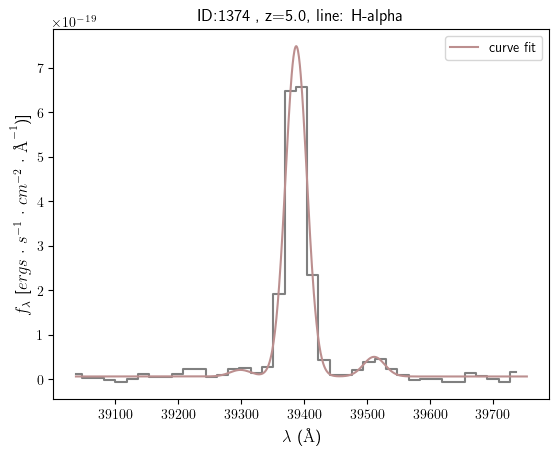

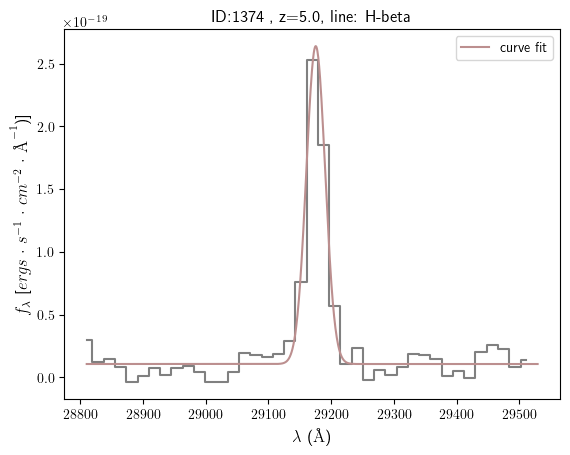

In [35]:
source = 6

# H-alpha
Ha_wavs = wavs_cleaned[source][Ha_center[source]-window:Ha_center[source]+window]
Ha_fluxes = fluxes_cleaned[source][Ha_center[source]-window:Ha_center[source]+window]
x_array = np.linspace(wavs_cleaned[source][Ha_center[source]-window],wavs_cleaned[source][Ha_center[source]+window],1000)
plt.figure()
plt.title(f'ID:{NIRSpec_df['ID'][source]} , z={round(NIRSpec_df['REDSHIFT'][source],2)}, line: H-alpha')
plt.xlabel(r'$\lambda$ ($\rm{\AA}$)',fontsize=12)
plt.ylabel(r'$f_{\lambda}$ [$ergs$ $\cdot$ $s^{-1}$ $\cdot$ $cm^{-2}$ $\cdot$ $\rm{\AA}^{-1}$)]',fontsize=12)
plt.step(Ha_wavs, Ha_fluxes, c='grey',where='mid')
plt.plot(x_array,Ha_line_model(x_array, *Ha_curve_fit_df['ppots'][source]),color='rosybrown',label='curve fit')
plt.legend()
#plt.savefig('example_curve_fit_Ha.png',dpi=500)
plt.show()

# H-beta
Hb_wavs = wavs_cleaned[source][Hb_center[source]-window:Hb_center[source]+window]
Hb_fluxes = fluxes_cleaned[source][Hb_center[source]-window:Hb_center[source]+window]
x_array = np.linspace(wavs_cleaned[source][Hb_center[source]-window],wavs_cleaned[source][Hb_center[source]+window],1000)
plt.figure()
plt.title(f'ID:{NIRSpec_df['ID'][source]} , z={round(NIRSpec_df['REDSHIFT'][source],2)}, line: H-beta')
plt.xlabel(r'$\lambda$ ($\rm{\AA}$)',fontsize=12)
plt.ylabel(r'$f_{\lambda}$ [$ergs$ $\cdot$ $s^{-1}$ $\cdot$ $cm^{-2}$ $\cdot$ $\rm{\AA}^{-1}$)]',fontsize=12)
plt.step(Hb_wavs, Hb_fluxes, c='grey',where='mid')
plt.plot(x_array,Hb_line_model(x_array, *Hb_curve_fit_df['ppots'][source]),color='rosybrown',label='curve fit')
plt.legend()
#plt.savefig('example_curve_fit_Hb.png',dpi=500)
plt.show()

### Defining emcee for H-alpha fitting

In [40]:
def log_likelihood(theta, x, y, yerr):
    '''
    This is the likelihood function we are using for emcee to run
    
    This likelihood function is the maximum likelihood assuming gaussian errors.
    '''
    ################
    # The value we are trying to fit
    #A, mu, sigma, m, b = theta
    
    #Making the model of the emission line
    model = Ha_line_model(x, *theta)
    
    #getting the log likelihood, this is similar to chi2
    lnL = -0.5 * np.nansum((y - model) ** 2 / yerr**2)
    
    return lnL

def log_prior(theta, wave_center, Amp_max):
    '''
    The prior function to be used against the parameters to impose certain criteria for the fitting
    '''
    #Theta values that goes into our Gaussian Model
    A, A1_NII, mu, sigma, b = theta
    
    #the left most and right most the central wavelength can vary
    left_mu = wave_center - 20   # [A] # had to change these as well this is how much mu can vary
    right_mu = wave_center + 20  # [A] # had to change these as well this is how much mu can vary
    
    #min and max amplitude of the emission line
    min_A = 0
    max_A = Amp_max * 2
    
    sigma_window_left = 1 # [A] # had to change these for the input spectra these are left bounds for sigma
    sigma_window_right = 50 # [A] # had to change these for the input spectra these are right bounds for sigma
        
    if (0 < A < max_A) & (0 < A1_NII < max_A) & (left_mu <= mu <= right_mu) & (sigma_window_left <= sigma < sigma_window_right) & (b > 0):
        return 0.0
    else:
        return -np.inf
    
    # adding NII argument to solve err
def log_probability(theta, x, y, yerr, first_wave, Amp_max, A_NII):
    
    lp = log_prior(theta, first_wave, Amp_max)
    if not np.isfinite(lp):
        #print('Probability is infinite')
        return -np.inf
    
    prob = lp + log_likelihood(theta, x, y, yerr)

    #print(f'Prob:{prob:.3E}')
    return prob
                                                        # added source_id input for diagnosis purposes
def initial_fits_Ha(wave, spectrum, err_spec, window, line_center, source_id, line_name,diagnose = False):
    '''
    This function does an initial fit on the data using curve fit which we then pass in those parameters into emcee
    to do the full MCMC fit later
    '''
    window_check = np.log10(window)
    
    #if window_check > -2:
        #print('WARNING: Search window may be too big double check input value')
    
    
    #the range where the optimization can look between 
    min_window = line_center - window
    max_window = line_center + window
    
    #getting emission line near the line center
    #line_center +/- window
    indx = np.where((min_window < wave) & ((wave < max_window)))[0]

    spec_window = spectrum[indx]
    wave_window = wave[indx]
    err_spec_window = err_spec[indx]
    
    #initial guesses for the optimization
    guess_A = np.amax(spec_window)
    guess_A_NII = 0.2*guess_A
    guess_mu = line_center
    med_continuum = np.median(spec_window)

    # setting new window for sigma guess, to avoid noisy peaks contaminating the guess
    # for H-alpha, sigma should be less than ~50 A
    small_min_window = line_center - 25 # [A]
    small_max_window = line_center + 25 # [A]
    small_indx = np.where((small_min_window < wave) & ((wave < small_max_window)))[0]
    small_spec_window = spectrum[small_indx]
    small_wave_window = wave[small_indx]

    # interpolating small window
    spec_interp = Akima1DInterpolator(small_wave_window, small_spec_window)
    x = np.linspace(small_wave_window[0], small_wave_window[-1], 10000)
    spec = spec_interp(x)
    half_max = guess_A / 2
    idx = np.where(spec > half_max)[0]
    wave_left, wave_right = x[idx[0]], x[idx[-1]]
    
    guess_sigma = (wave_right - wave_left)/2
    
    if diagnose == True:
        
        print('Minimization Guesses')
        print(f"A: {guess_A}")
        print(f"mu: {guess_mu}")
        print(f"sigma: {guess_sigma}")
        print(f"b: {med_continuum}")
        print() 

    x0 = [guess_A, guess_A_NII, guess_mu, guess_sigma, med_continuum]
    #Code to add to account for negative continuum (b)
    if med_continuum < 0:
        low_bounds = [0, 0, min_window, 0, np.median(spec_window)*2]
        high_bounds = [2*guess_A, 2*guess_A_NII, max_window, 50, np.median(spec_window)/2] # [A]
    else:
        low_bounds = [0, 0, min_window, 0, np.median(spec_window)/2]
        high_bounds = [2*guess_A, 2*guess_A_NII, max_window, 50, np.median(spec_window)*2] # [A]
    
    # Optimization of the initial gaussian fit
    result,_ = curve_fit(Ha_line_model, wave_window, spec_window, p0 = x0, 
                          bounds = [low_bounds, high_bounds])  #bounds on b
    
#     ########
#     # Diagnostic Plotting: making sure we are getting the emission line
#     ########
#     if diagnose == True:
        
#         print('Minimization Results')
#         print(f"A: {result[0]}")
#         print(f"mu: {result[1]}")
#         print(f"sigma: {result[2]}")
#         print(f"b: {result[3]}")
#         print()
        
#         xarr = np.linspace(wave_window[0], wave_window[-1], 100)
#         plt.figure()
#         plt.plot(wave_window, spec_window, color = 'blue', label = 'Data')
#         plt.scatter(wave_window, spec_window, color = 'blue')
#         plt.plot(xarr, line_model(xarr, *result), color = 'black', label = 'Model')
#         plt.axhline(0, linestyle = '--')
#         plt.ylabel('Flux')
#         plt.xlabel(r'Wavelength $\mu$m')
#         plt.title('Initial Curvefit ID: '+str(source_id)+' line: '+str(line_name))
#         plt.legend()
#         plt.show()

    return result
                                    # added source_id input for diagnosis purposes
def fitting_Ha_line(wave, flux, flux_err, line_center, window_wavelength, source_id, line_name, 
                 diagnose = False,save=True, filename = 'Emcee_Chains_Galaxy.txt'):
    '''
    The code that fits the line using the emcee approach
    '''
    result = initial_fits_Ha(wave, flux, flux_err, window_wavelength, line_center, source_id, line_name, diagnose = diagnose)
    
    #getting the results from the initial fit to then pass into emcee
    guess_A = result[0]
    guess_A_NII = result[1]
    guess_mu = result[2]
    guess_sigma = result[3]
    guess_b = result[4]
    
    
    #making walkers so that we can use emcee to explore the parameter space
    #centered on the best results from minimization
    amp_jump = np.random.normal(loc = guess_A,            #centered on best A from minimization
                                scale = guess_A/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
    
    amp_NII_jump = np.random.normal(loc = guess_A_NII,            #centered on best A from minimization
                                    scale = guess_A_NII/10,       #can wander 1/10 of the value of A
                                    size = 32).reshape(-1, 1) 
    
    wavelength_jump = np.random.normal(loc = guess_mu,    #centered on best mu from minimization
                                       scale = 50,      # can wander +/- 0.005 microns 
                                       size = 32).reshape(-1, 1)
    
    
    sigma_jump = np.random.normal(loc = guess_sigma, scale = 20, size = 32).reshape(-1, 1)
    powerb = np.log10(np.abs(guess_b))
    b_jump = np.random.normal(loc = guess_b, scale = 1*10**powerb, size = 32).reshape(-1, 1)
    
#     #################
#     # Diagnostic plotting to see if the parameters were jumping to large values
#     # The should be concentrated near their best fit results values
#     #################
#     if diagnose == True:
#         print('Checking the Walker Jumps')
#         fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
#         ax[0, 0].hist(amp_jump)
#         ax[0, 0].set_xlabel('Amplitude')

#         ax[0, 0].hist(amp_NII_jump)
#         ax[0, 0].set_xlabel('NII Amplitude')
        
#         ax[0, 1].hist(wavelength_jump)
#         ax[0, 1].set_xlabel(r'$\mu$')
        
#         ax[1, 0].hist(sigma_jump)
#         ax[1, 0].set_xlabel(r'$\sigma$')
        
#         ax[1, 1].hist(b_jump)
#         ax[1, 1].set_xlabel('b')
        
#         plt.show()
    
    #stacking along the columns
    starting_walkers = np.hstack((amp_jump,
                                  amp_NII_jump,
                                  wavelength_jump, 
                                  sigma_jump, 
                                  #m_jump, 
                                  b_jump))

    #initializing window for emcee around the best result mu
    emcee_window = window_wavelength #in units of microns
    emcee_indx = np.where((wave >= (line_center - emcee_window)) & 
                          (wave <= (line_center + emcee_window)))[0]

    #emcee subsections
    emcee_spec = flux[emcee_indx]
    emcee_wave = wave[emcee_indx]
    emcee_err = flux_err[emcee_indx]
    
    ###########
    #NOTE:
    #need to change output name everytime you run otherwise it will overwrite
    ###########
    
    #saves the input emcee spectra
    emcee_spec_matrix = np.c_[emcee_wave, emcee_spec, emcee_err]
    np.savetxt(f'Emcee_Spectra.txt', emcee_spec_matrix)

    #initializing walker positions
    pos = starting_walkers
    nwalkers, ndim = pos.shape

    #initializing sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(emcee_wave, emcee_spec, emcee_err, guess_mu, guess_A, guess_A_NII), 
                                    moves = [(emcee.moves.DEMove(), 0.5),
                                             (emcee.moves.DESnookerMove(), 0.5)])
    #running it
    '''
    added skip_initial_state_check=True to fix the following error
    "Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance"
    '''
    sampler.run_mcmc(pos, 3000, progress=False, skip_initial_state_check=True)

    #getting values back
    #samples = sampler.get_chain()
    flat_samples = sampler.get_chain(flat=True)
    LnL_chain = sampler.flatlnprobability
    burn_in = 1000 
    
    emcee_df = pd.DataFrame()
    emcee_df['A'] = flat_samples[burn_in:, 0]
    emcee_df['A_NII'] = flat_samples[burn_in:, 1]
    emcee_df['mu'] = flat_samples[burn_in:, 2]
    emcee_df['sigma'] = flat_samples[burn_in:, 3]
    emcee_df['b'] = flat_samples[burn_in:, 4]
    emcee_df['LnL'] = LnL_chain[burn_in:]
    
    emcee_df = emcee_df[np.isfinite(emcee_df.LnL.values)]
    
    fluxes_emcee = emcee_df['A'] * emcee_df['sigma'] * np.sqrt(2 * np.pi) # M: calculating area of Gaussian
    emcee_df['Fluxes'] = fluxes_emcee
    
#     if diagnose == True:
        
#         print('Checking Parameter Posterior Distributions')
#         fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
#         emcee_df.A.hist(ax = ax[0, 0])
#         (missing NII Amp)
#         emcee_df.mu.hist(ax = ax[0, 1])
#         emcee_df.sigma.hist(ax = ax[1, 0])
#         #emcee_df.m.hist(ax = ax[1, 0])
#         emcee_df.b.hist(ax = ax[1, 1])
        
#         plt.show()
    
    if diagnose == True:
        xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 500)
        
        plt.figure()
        plt.title('Emcee Fit ID: '+str(source_id)+' line: '+str(line_name))
        plt.step(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data', where='mid')
        #plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(xarr, Ha_line_model(xarr, *emcee_df.quantile(q = 0.5).values[:-2]), label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()
    
    ###########
    #NOTE:
    #need to also give the filename argument otherwise it will overwrite the default file
    ###########
    if save == True:
        emcee_df.to_csv(filename, sep = ' ')
        
    else:
        return emcee_wave, emcee_spec, emcee_err, emcee_df

### Fitting H-alpha with emcee

Minimization Guesses
A: 8.175470602552516e-20
mu: 43750.249974803904
sigma: 17.290455712209223
b: -2.585159748038271e-21



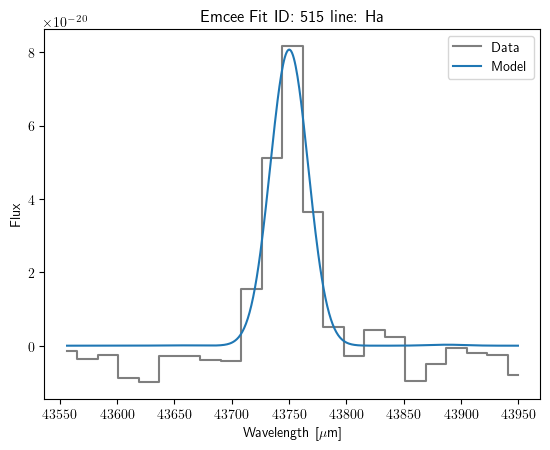

source #0
Minimization Guesses
A: 4.4360399980040374e-20
mu: 46266.89566085644
sigma: 17.410430362848274
b: 3.350974011827986e-21



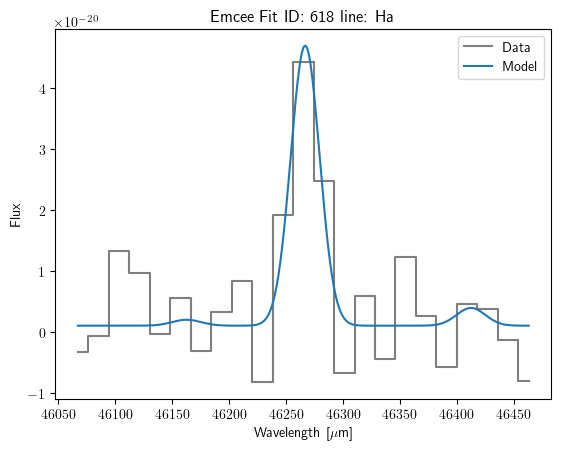

source #1
Minimization Guesses
A: 5.360390568949434e-20
mu: 43755.8413936466
sigma: 18.172815377220104
b: 9.434874248370288e-21



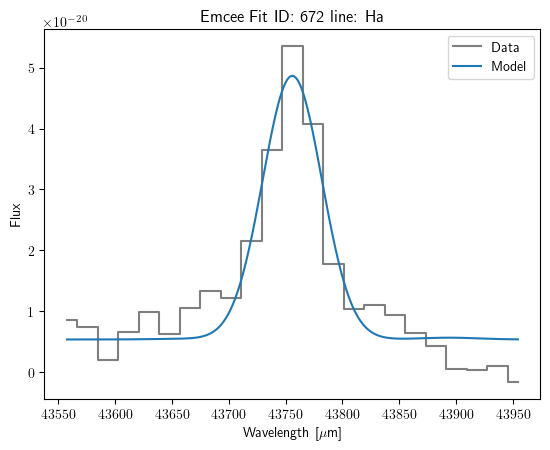

source #2
Minimization Guesses
A: 2.8470273430214035e-20
mu: 38703.106500598835
sigma: 17.517828538195317
b: 4.021904844100403e-21



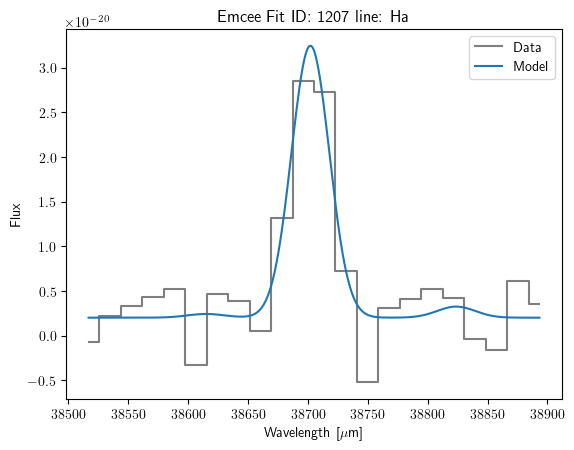

source #3
Minimization Guesses
A: 2.9948613333100065e-20
mu: 34640.68786078824
sigma: 17.93768123247719
b: 4.051835932019463e-21



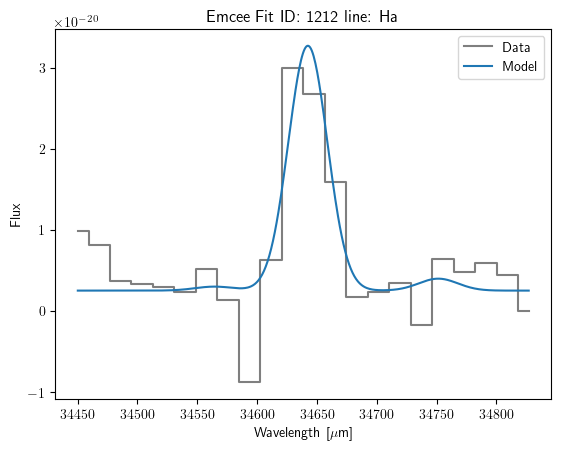

source #4
Minimization Guesses
A: 9.005647394884564e-20
mu: 38595.1296980568
sigma: 8.970336604976183
b: 3.8885925569001855e-21



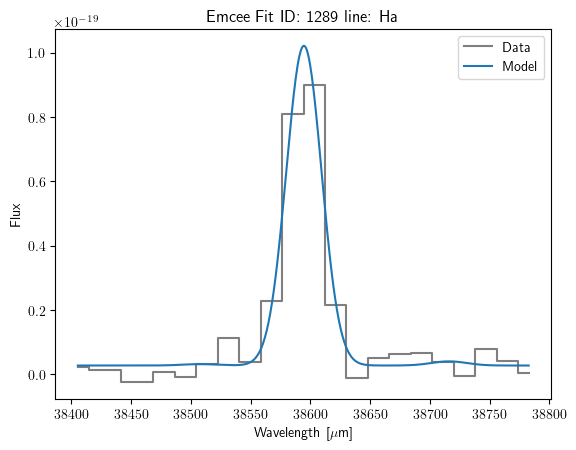

source #5
Minimization Guesses
A: 6.566524792847754e-19
mu: 39387.45173101492
sigma: 0.0
b: 2.3468926363942486e-20



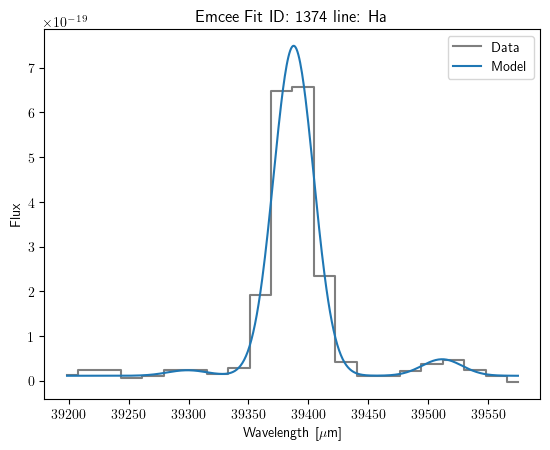

source #6
Minimization Guesses
A: 6.409976503019525e-19
mu: 14394.82846666159
sigma: 9.104614414291973
b: 8.630688388272618e-20



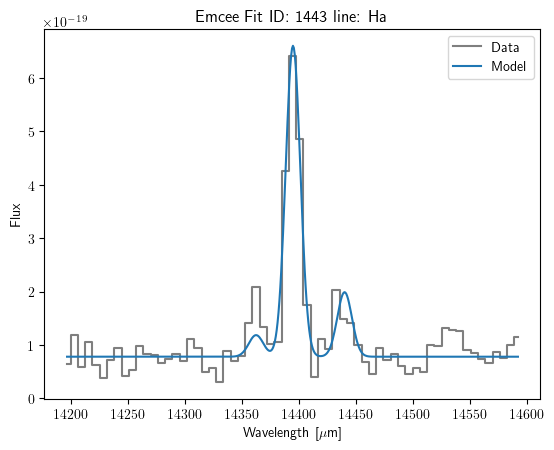

source #7
Minimization Guesses
A: 2.753336178511555e-19
mu: 16343.850650326625
sigma: 6.842662144202222
b: 3.50812539650251e-20



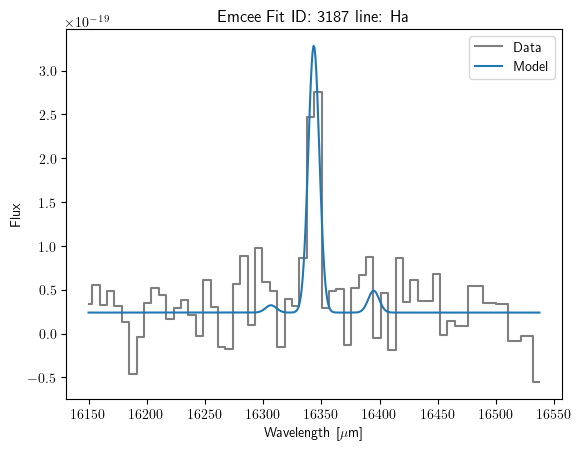

source #8
Minimization Guesses
A: 2.184903291710222e-18
mu: 21629.9161138412
sigma: 14.577238833049705
b: 5.0182371548327653e-20



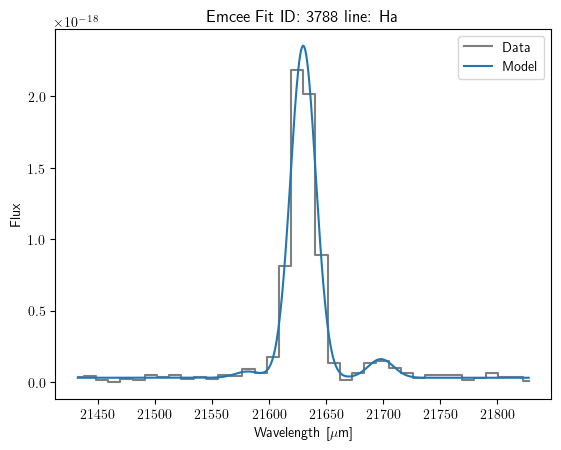

source #9
Minimization Guesses
A: 2.5891721845061284e-19
mu: 19181.91517469946
sigma: 9.988375423898106
b: 2.4768090342438462e-20



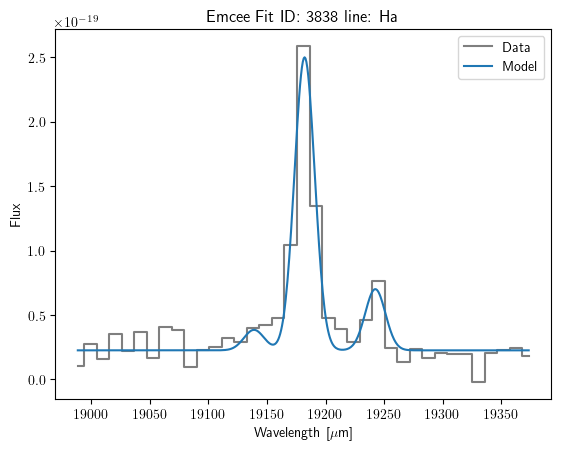

source #10
Minimization Guesses
A: 1.4358354372271964e-19
mu: 20635.630351067834
sigma: 9.523137715550547
b: 6.877908755496813e-21



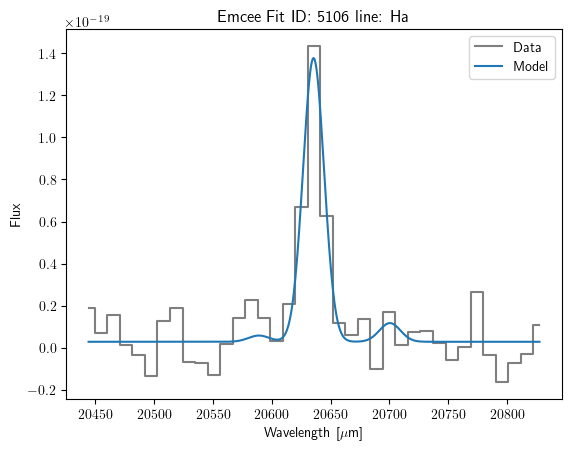

source #11
Minimization Guesses
A: 5.234818170248472e-19
mu: 26961.972470819102
sigma: 14.070225635598035
b: 1.1045765749829558e-20



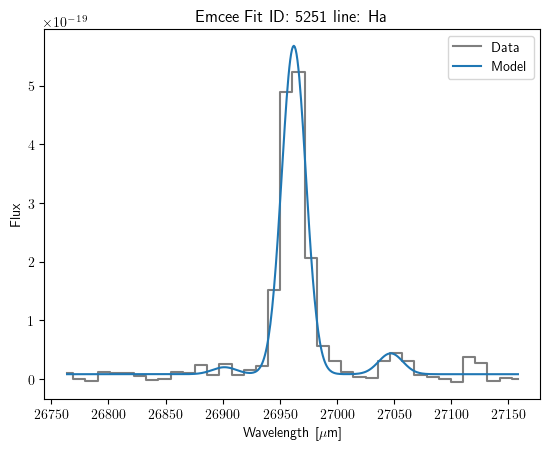

source #12
Minimization Guesses
A: 5.451347045811527e-19
mu: 20588.362522792508
sigma: 13.78748386922598
b: 2.864079452944346e-20



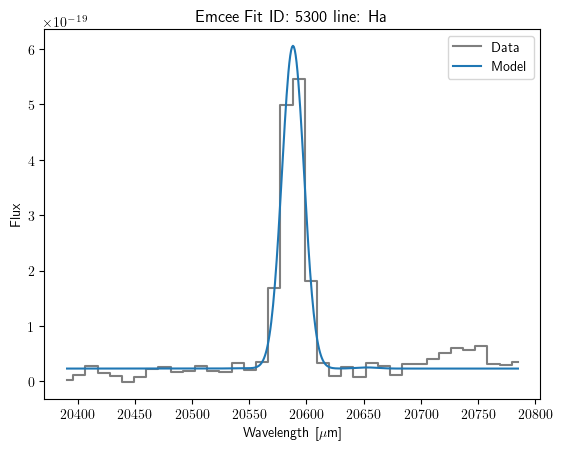

source #13
Minimization Guesses
A: 1.3190049024000172e-19
mu: 17831.861226208155
sigma: 11.982459361059227
b: 1.472418656135335e-20



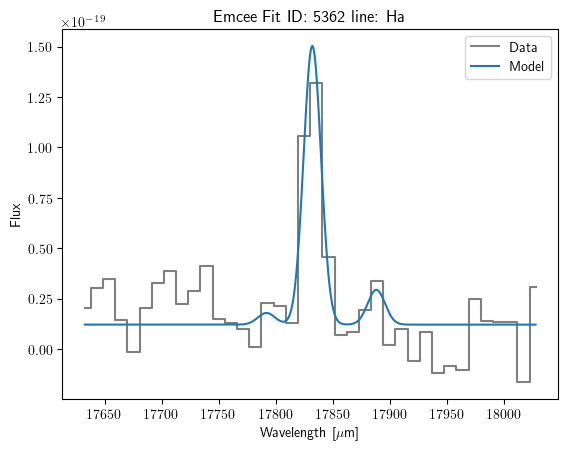

source #14
Minimization Guesses
A: 1.2888626313674064e-18
mu: 17719.892428178206
sigma: 11.936294924955291
b: 9.857571348001697e-20



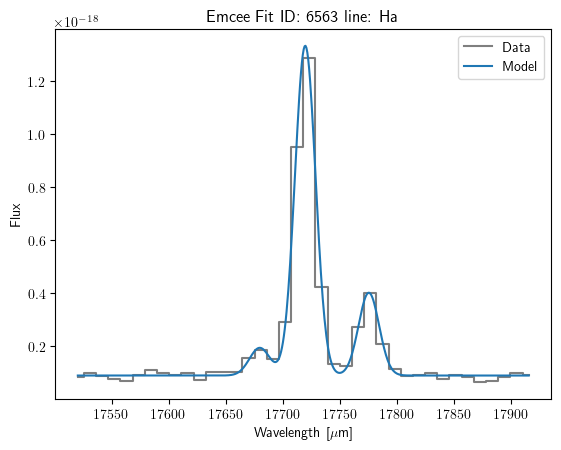

source #15
Minimization Guesses
A: 2.877757255663037e-19
mu: 21898.29823549105
sigma: 15.227756201864395
b: 3.374426167163569e-20



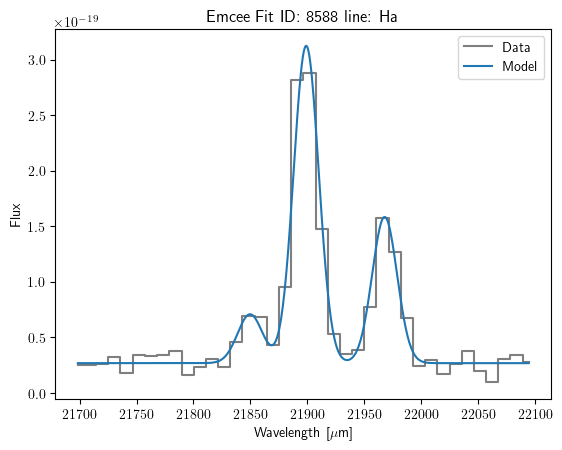

source #16
Minimization Guesses
A: 4.117503454126339e-19
mu: 21904.50686288278
sigma: 11.615181343993754
b: 1.4240880124590767e-20



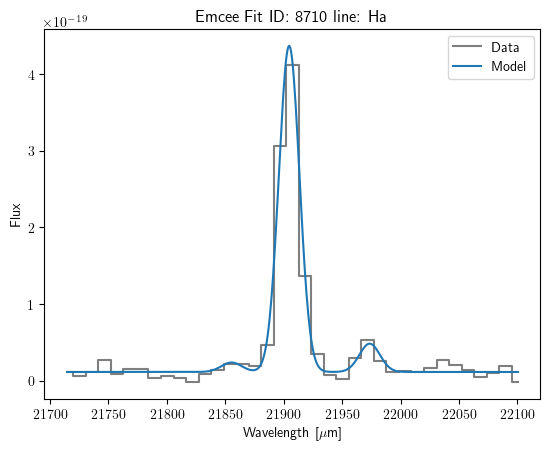

source #17
Minimization Guesses
A: 4.786269835783393e-19
mu: 16765.518303190347
sigma: 12.44973053591275
b: 6.674214448069077e-20



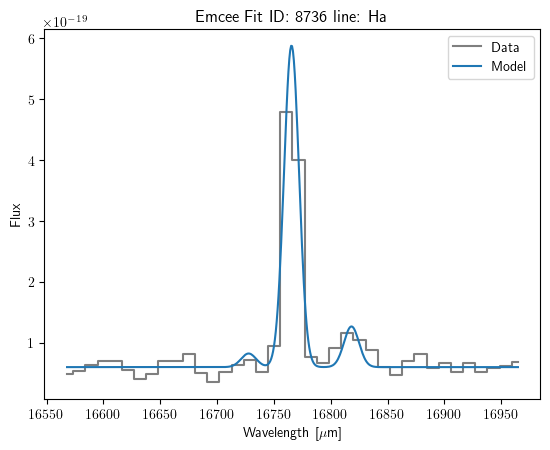

source #18
Minimization Guesses
A: 1.481173851179947e-18
mu: 28240.108609291463
sigma: 12.643225810475997
b: 3.055012361938122e-20



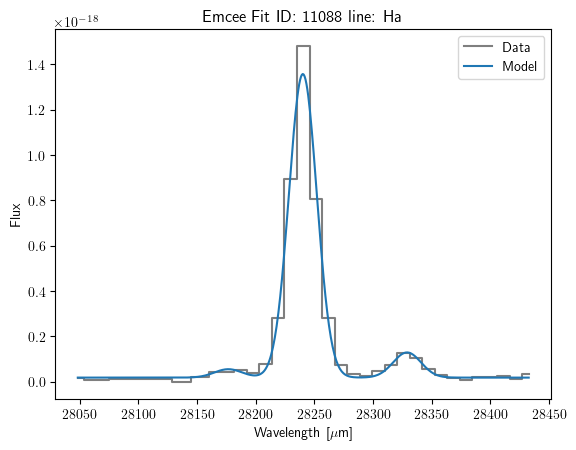

source #19
Minimization Guesses
A: 7.077135352208706e-20
mu: 27751.151472914098
sigma: 13.068942663785492
b: 7.250672142968414e-21



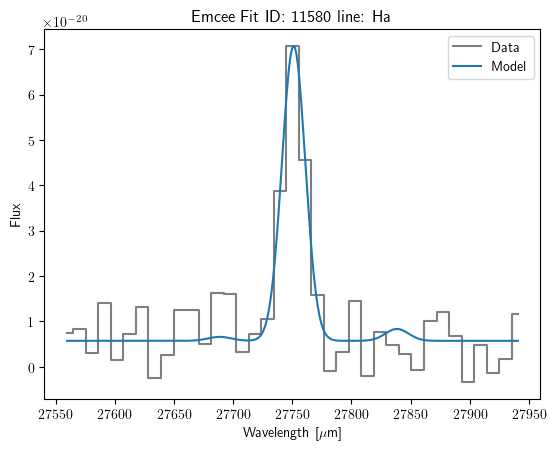

source #20
Minimization Guesses
A: 7.152969370704051e-20
mu: 26259.226933658563
sigma: 12.013865712839106
b: 3.073535480144184e-21



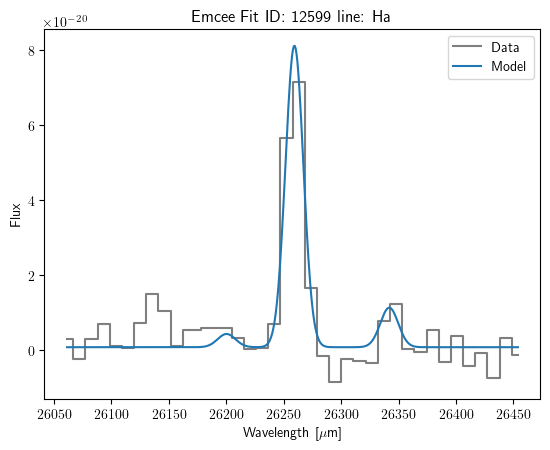

source #21
Minimization Guesses
A: 6.707950290095101e-19
mu: 23239.512224174174
sigma: 13.866295726726094
b: 1.3296518347785788e-20



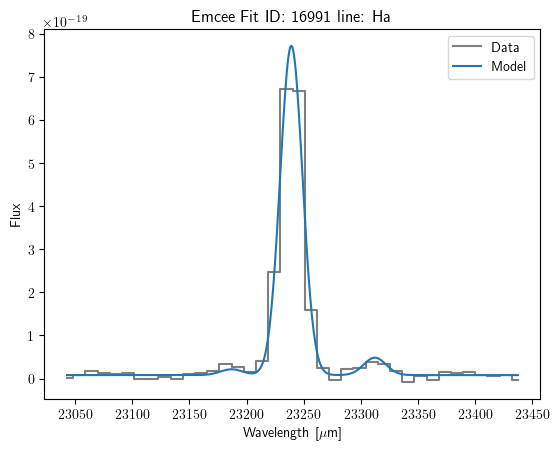

source #22
Minimization Guesses
A: 2.9998731927803655e-19
mu: 19760.15920099579
sigma: 9.080252524881871
b: 7.642787336662122e-21



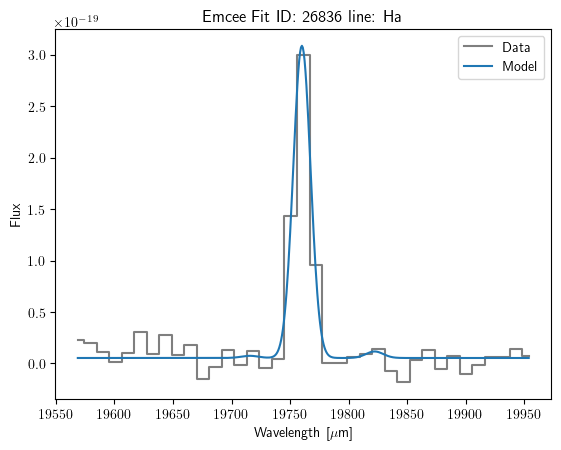

source #23
Minimization Guesses
A: 1.1859224762222897e-19
mu: 17555.05346789428
sigma: 9.786480962944552
b: 1.5284084367122045e-20



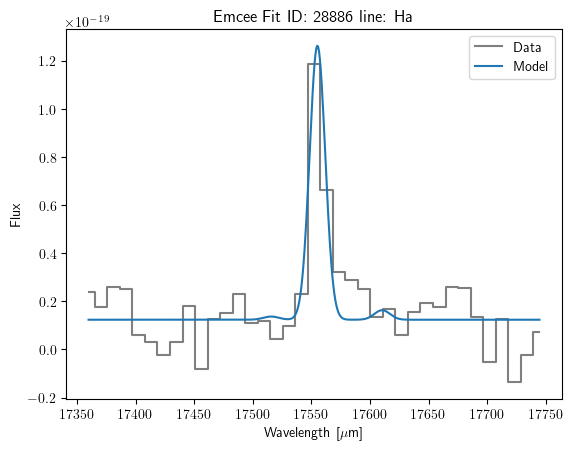

source #24
Minimization Guesses
A: 8.77617218096607e-20
mu: 19114.67413530456
sigma: 8.501867561701147
b: -2.0185176969081257e-22



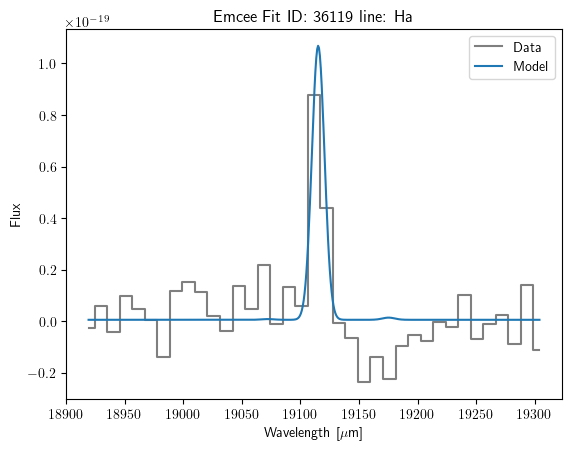

source #25
Minimization Guesses
A: 1.6390823743949343e-19
mu: 43755.60209803613
sigma: 0.0
b: 3.732377979261026e-21



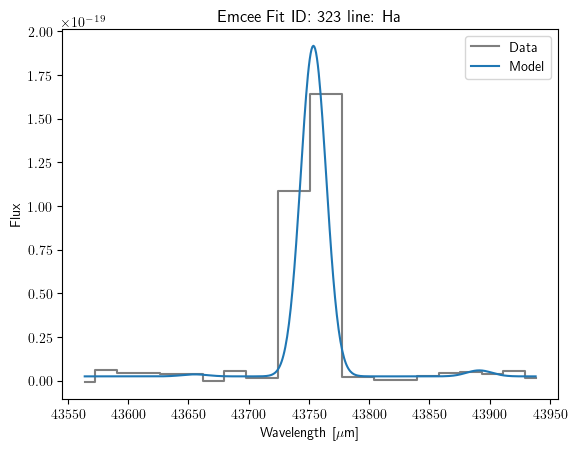

source #26
Minimization Guesses
A: 8.857717823799156e-20
mu: 46604.80554195886
sigma: 0.0
b: 3.1112008445021045e-21



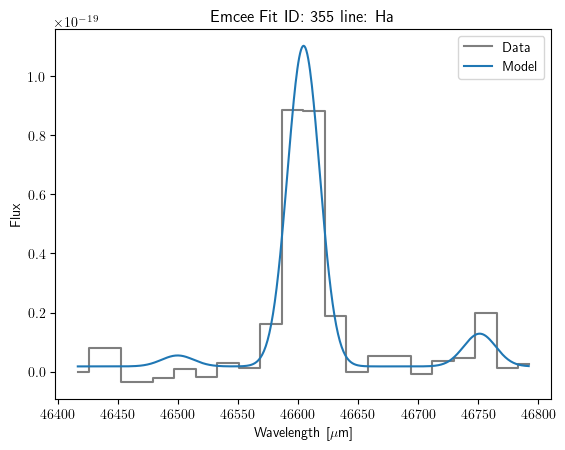

source #27
Minimization Guesses
A: 5.32545499491199e-20
mu: 42719.402766424486
sigma: 0.0
b: 4.587584750389925e-21



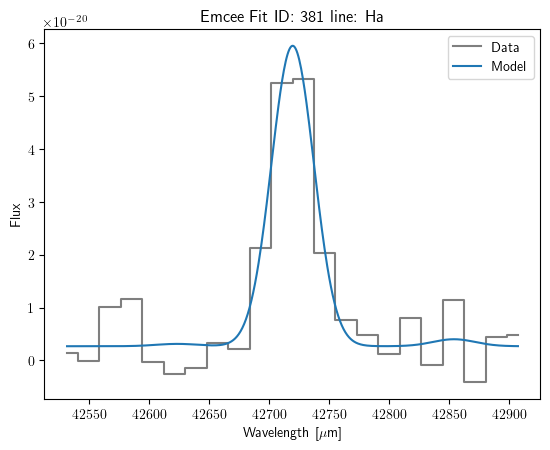

source #28
Minimization Guesses
A: 5.3346822212177173e-20
mu: 49978.06433879373
sigma: 16.194945760402334
b: 2.5645563987757725e-21



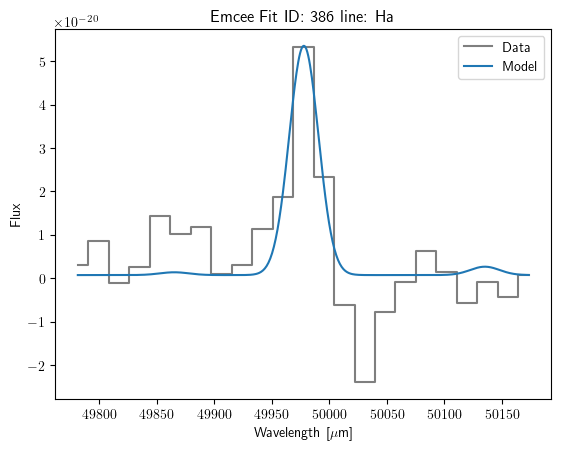

source #29
Minimization Guesses
A: 3.5639497391152175e-19
mu: 45954.41526734756
sigma: 17.83779638282431
b: 1.560491684400544e-20



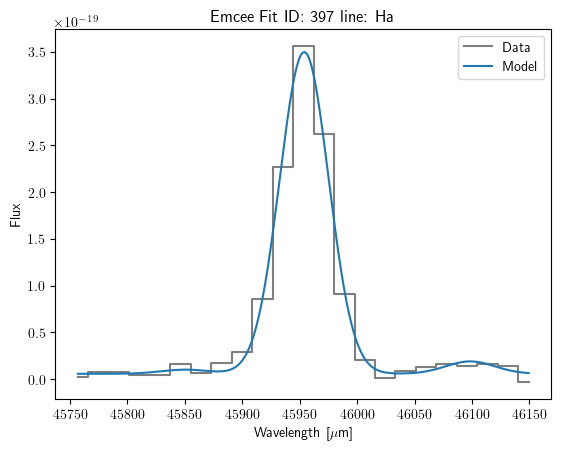

source #30
Minimization Guesses
A: 1.1749391362270898e-19
mu: 44383.1662575849
sigma: 17.885357333922002
b: 9.953282440732992e-21



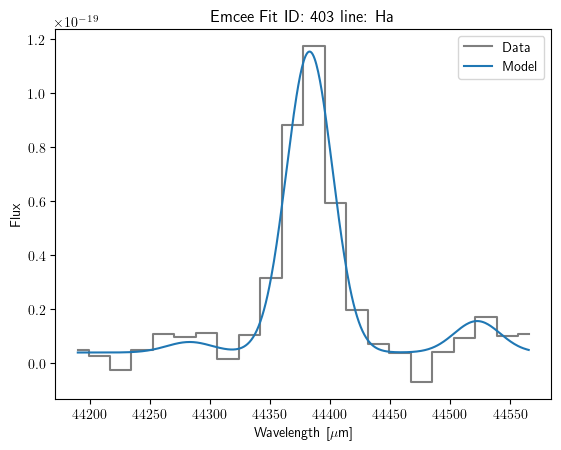

source #31
Minimization Guesses
A: 2.126104042438694e-20
mu: 43626.945695191396
sigma: 17.848518925926328
b: 1.1196189787790574e-21



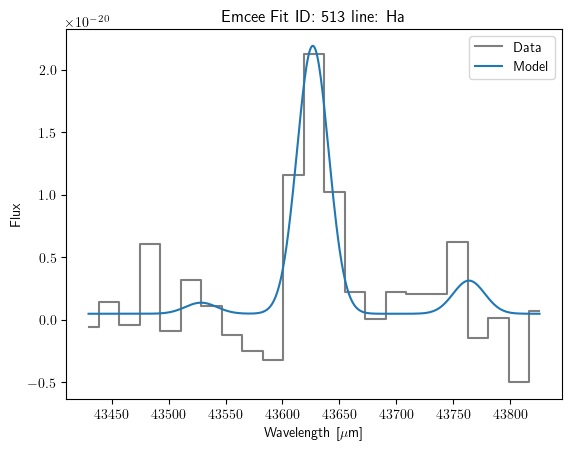

source #32
Minimization Guesses
A: 7.426984731817072e-20
mu: 46323.52442432986
sigma: 17.944730721064843
b: 1.283287398953996e-21



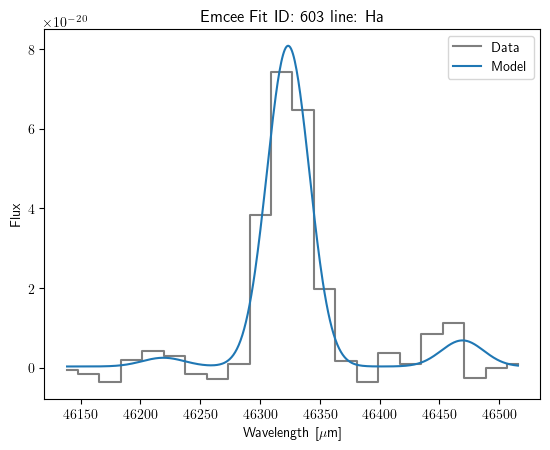

source #33
Minimization Guesses
A: 5.418971933395827e-20
mu: 43477.21247461349
sigma: 0.0
b: 1.2216883835879331e-20



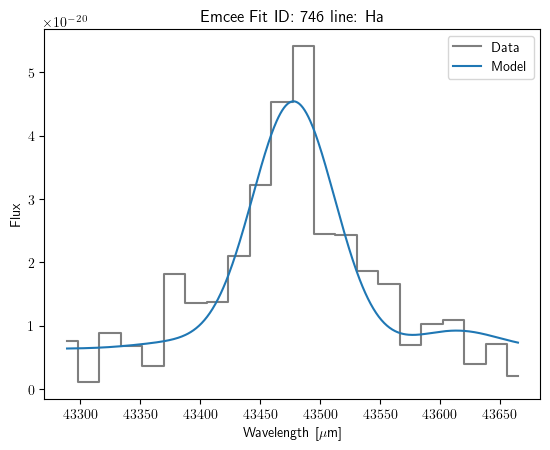

source #34
Minimization Guesses
A: 5.761748358890032e-20
mu: 47637.063833685075
sigma: 17.582127591394965
b: 1.7867841550371863e-21



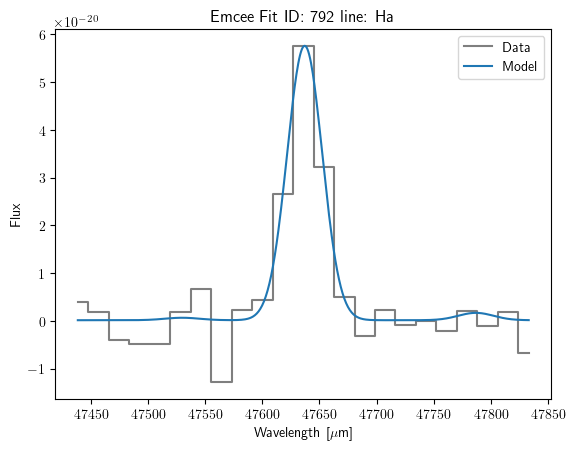

source #35
Minimization Guesses
A: 4.365758866240102e-20
mu: 41150.762225279206
sigma: 17.779268135323946
b: -4.1301367210193088e-22



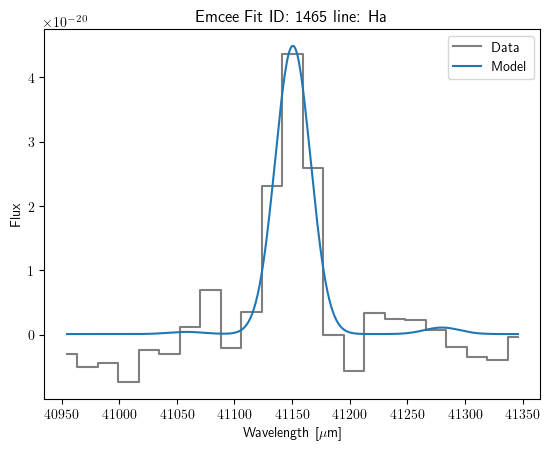

source #36
Minimization Guesses
A: 8.518736546602894e-20
mu: 29116.310900402845
sigma: 16.374100372120665
b: 9.786758601804472e-21



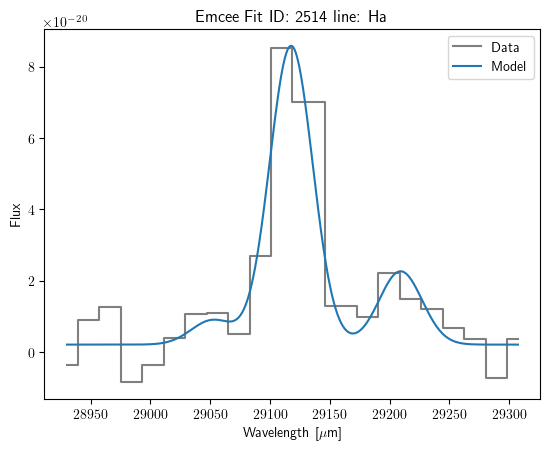

source #37
Minimization Guesses
A: 1.6383416015349374e-19
mu: 40966.243023576
sigma: 0.0
b: 1.4297760327956858e-20



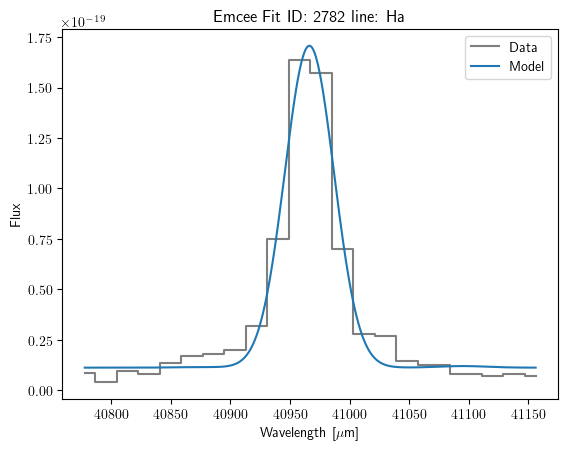

source #38
Minimization Guesses
A: 3.814599813562749e-19
mu: 28237.507534357595
sigma: 11.516184651387448
b: 1.2564018537648615e-20



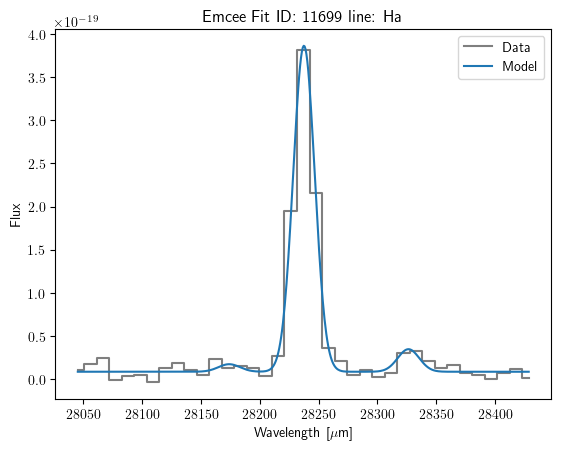

source #39
Minimization Guesses
A: 5.959442620543097e-20
mu: 32018.998817029988
sigma: 17.35016012152846
b: 2.0255385944684566e-21



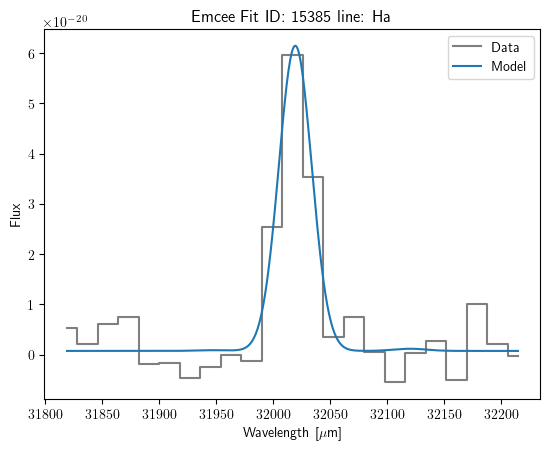

source #40
Minimization Guesses
A: 2.5264699982048e-19
mu: 36962.9304470898
sigma: 0.0
b: 6.1063762360781014e-21



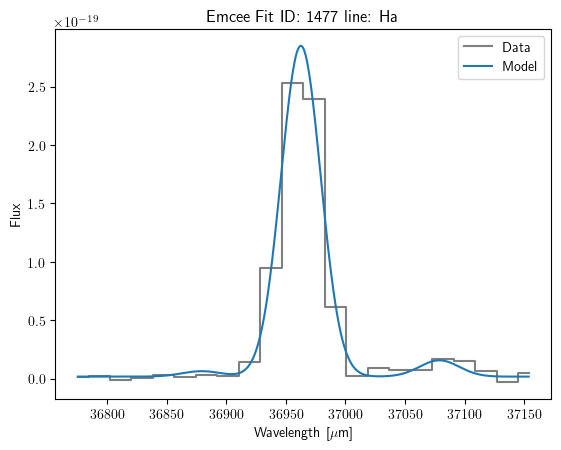

source #41
Minimization Guesses
A: 4.4049611388241495e-20
mu: 36067.51139823381
sigma: 0.0
b: 3.328123163017422e-22



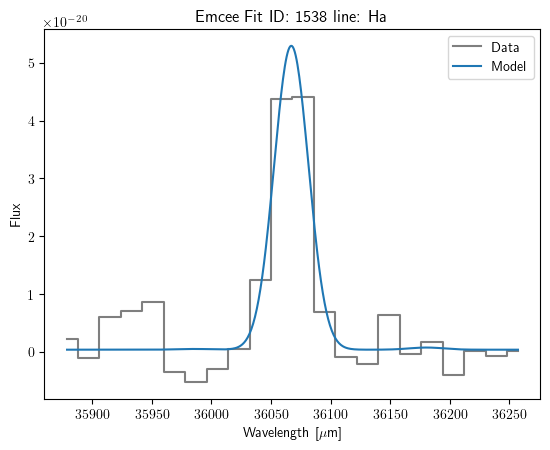

source #42
Minimization Guesses
A: 1.8700787877296463e-19
mu: 36499.83776579214
sigma: 8.979297365043749
b: 5.425764863897492e-21



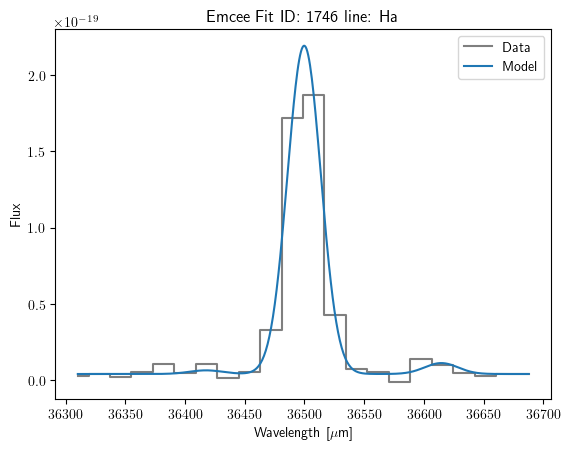

source #43
Minimization Guesses
A: 2.132280141071151e-20
mu: 36091.79203786777
sigma: 16.731860672080074
b: 3.769591303004411e-22



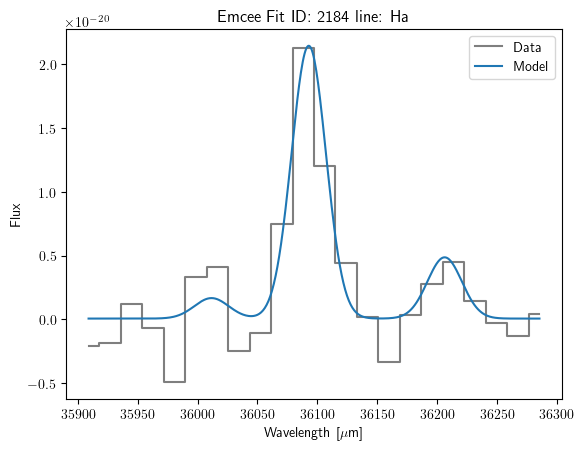

source #44
Minimization Guesses
A: 1.4328136167753396e-19
mu: 29351.154712178926
sigma: 16.10429876073431
b: 1.3959442503760992e-20



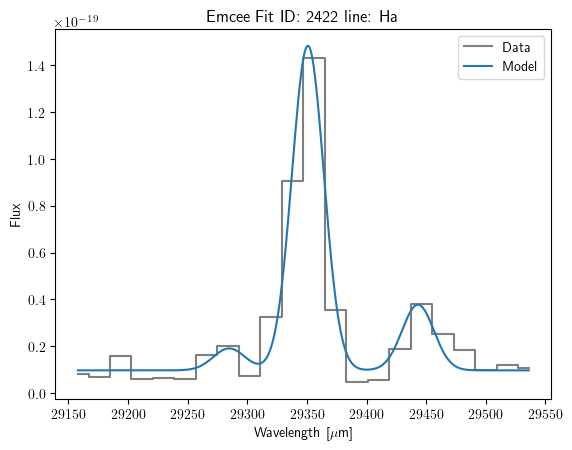

source #45
Minimization Guesses
A: 2.97250636261465e-19
mu: 31944.324260014982
sigma: 16.73489055587197
b: 3.7849611233793665e-21



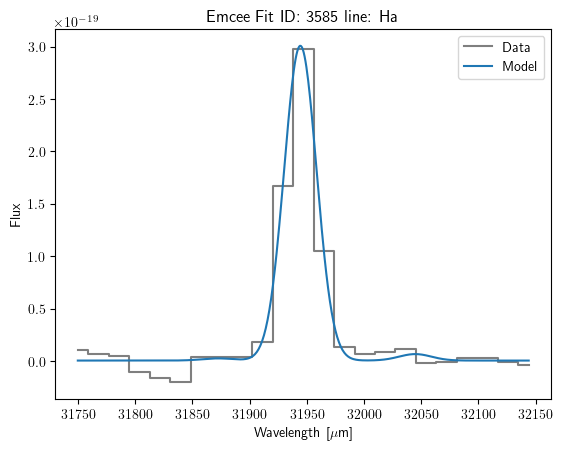

source #46
Minimization Guesses
A: 9.63746796318329e-19
mu: 13554.314334974997
sigma: 7.41963851656601
b: 1.1063891447677273e-19



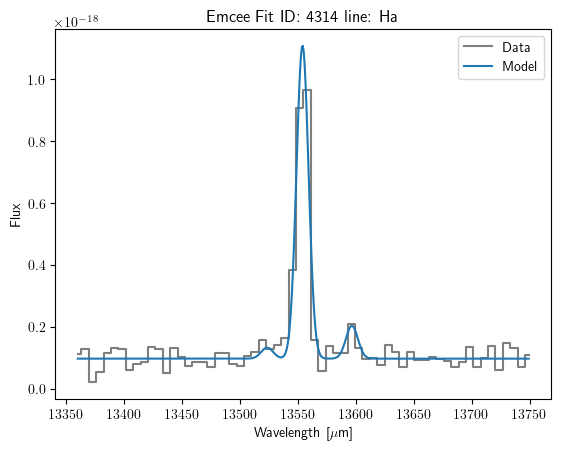

source #47
Minimization Guesses
A: 4.465274129082754e-19
mu: 28419.56245942163
sigma: 11.373834539317613
b: 1.3324056173670041e-20



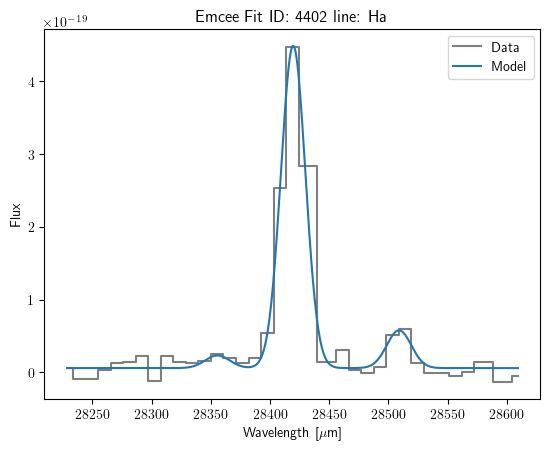

source #48
Minimization Guesses
A: 4.624842476200744e-19
mu: 16888.462236493557
sigma: 7.048608387904096
b: 3.047869788681391e-20



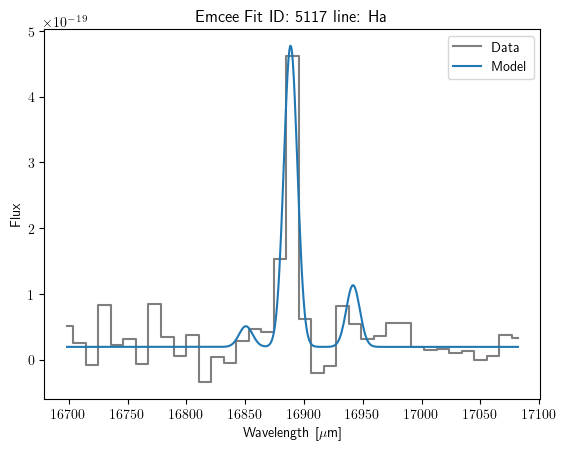

source #49
Minimization Guesses
A: 4.826373092902657e-19
mu: 15686.58491630215
sigma: 7.70249168968985
b: 4.9904342693308924e-20



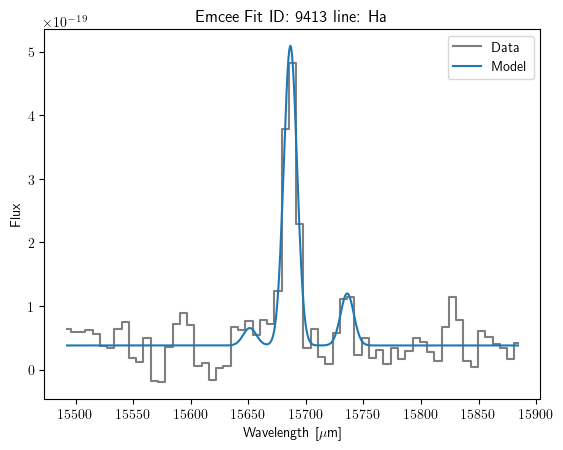

source #50
Minimization Guesses
A: 9.368276481605745e-19
mu: 17565.32021875287
sigma: 5.648966207452759
b: 1.328610070635769e-19



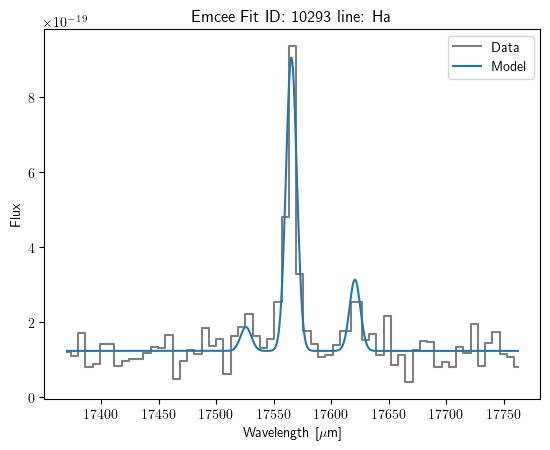

source #51
Minimization Guesses
A: 1.9334675520297708e-19
mu: 28410.648568583918
sigma: 14.298869775253479
b: 1.1356775443611016e-20



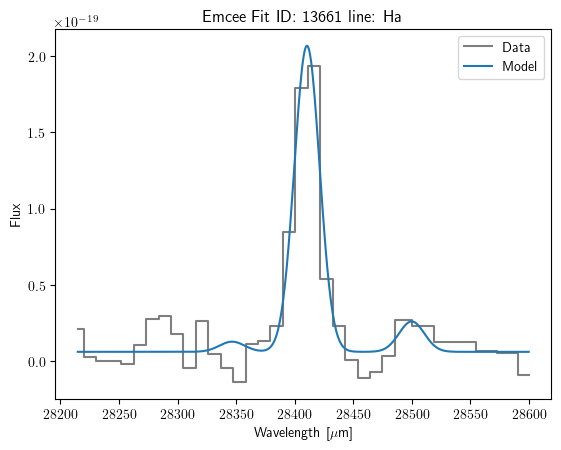

source #52
Minimization Guesses
A: 4.352077315800959e-20
mu: 33523.87786301036
sigma: 17.099486408911616
b: 2.745198208745507e-21



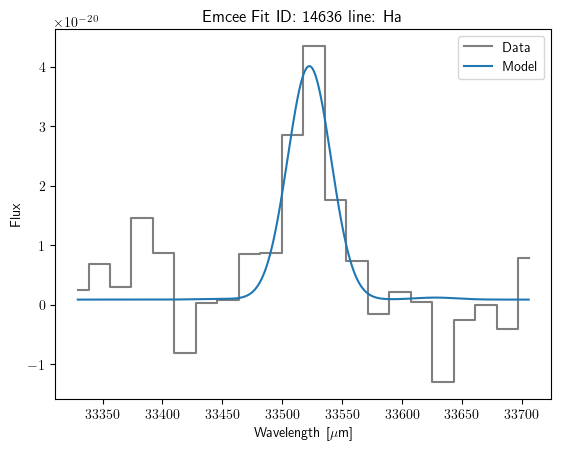

source #53
Minimization Guesses
A: 2.0982179790978038e-19
mu: 24375.959474848452
sigma: 13.307698793978489
b: 1.9200589819218064e-20



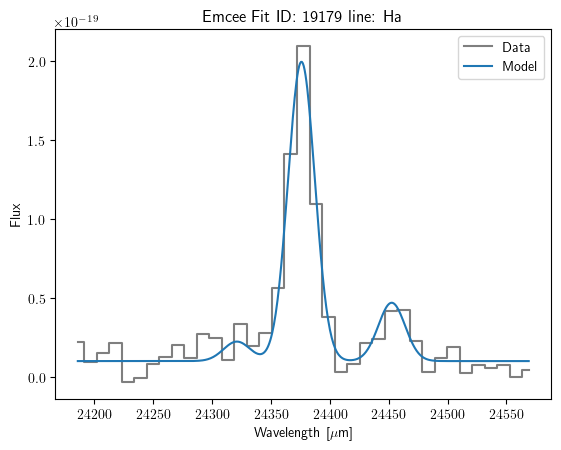

source #54
Minimization Guesses
A: 1.3034968224126784e-19
mu: 19220.030288637132
sigma: 8.188556641041941
b: 4.446248708669977e-21



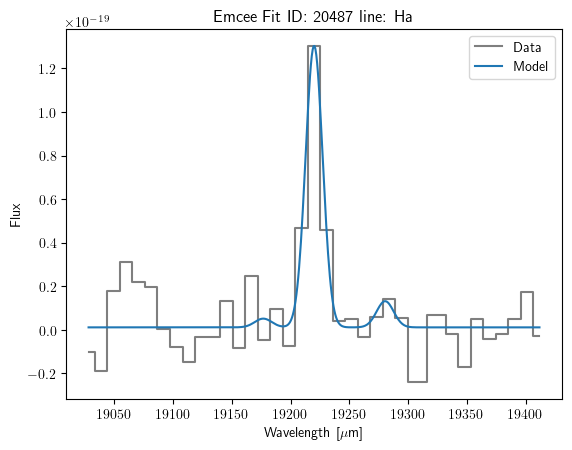

source #55
Minimization Guesses
A: 2.0089934955968284e-18
mu: 14987.33457239733
sigma: 5.452431727182557
b: 4.6945979753071797e-20



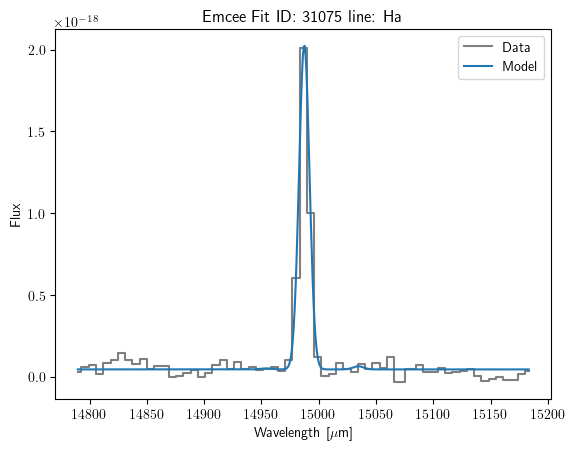

source #56
Minimization Guesses
A: 1.5730120141673256e-19
mu: 47915.299342037324
sigma: 0.0
b: 1.4835400021815493e-21



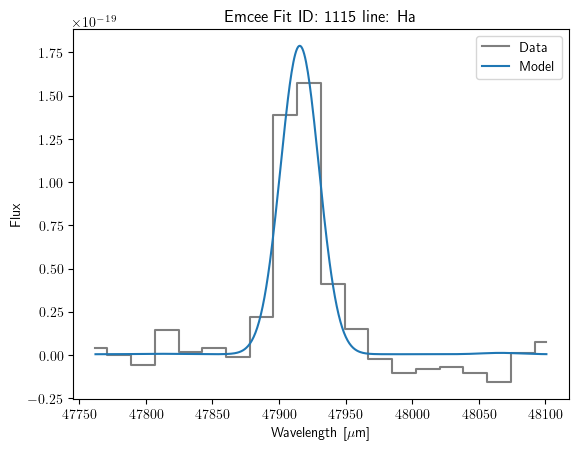

source #57
Minimization Guesses
A: 3.7511388639526506e-20
mu: 40367.61550972586
sigma: 16.821006956150086
b: 4.3303474643391885e-21



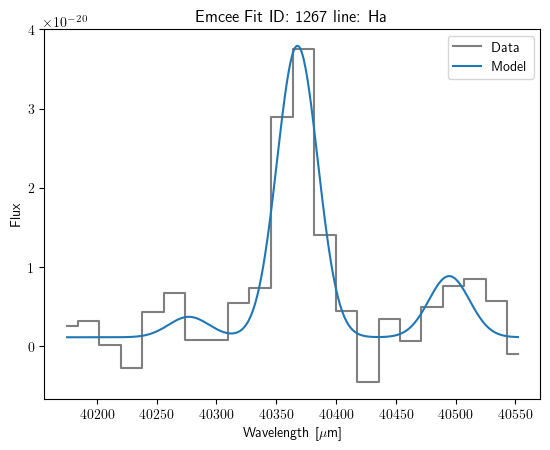

source #58
Minimization Guesses
A: 1.3835603166009222e-19
mu: 41847.80483886215
sigma: 0.0
b: 5.842366106447321e-21



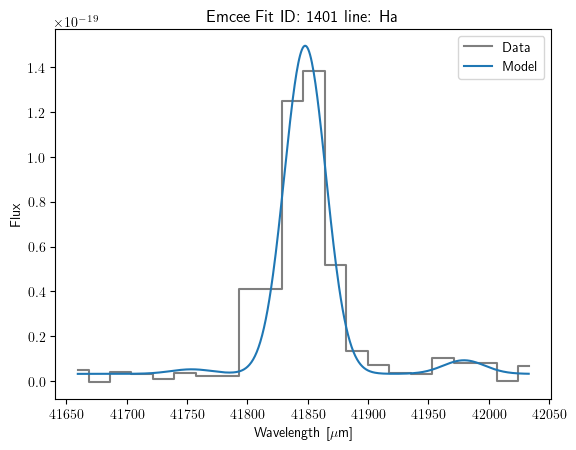

source #59
Minimization Guesses
A: 7.484585827544678e-20
mu: 41066.93326678815
sigma: 17.851841013187368
b: 7.993894437652426e-21



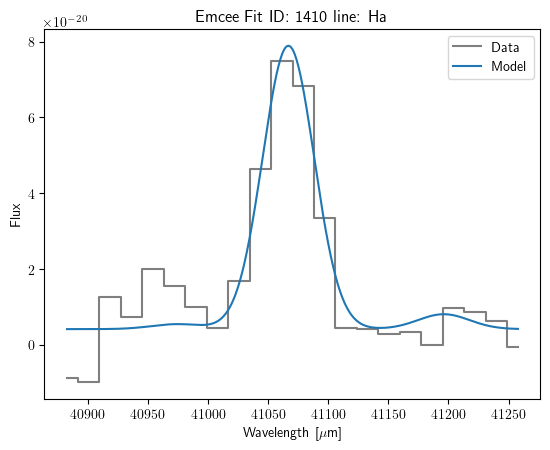

source #60
Minimization Guesses
A: 1.306027048279158e-19
mu: 47240.90996956585
sigma: 16.538780891638453
b: 6.370084968800617e-21



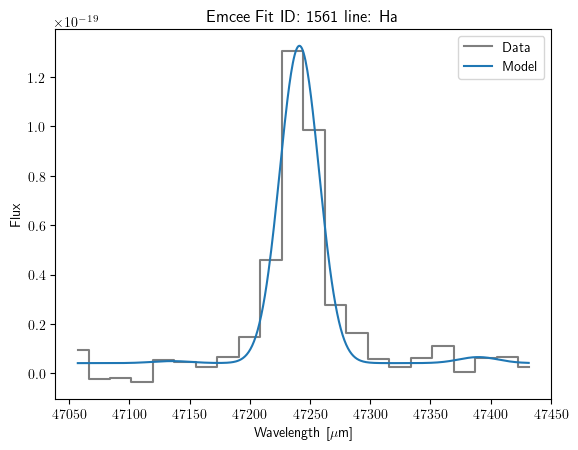

source #61
Minimization Guesses
A: 9.608458097788644e-19
mu: 35988.48703366459
sigma: 17.934893598401686
b: 6.245997575927826e-20



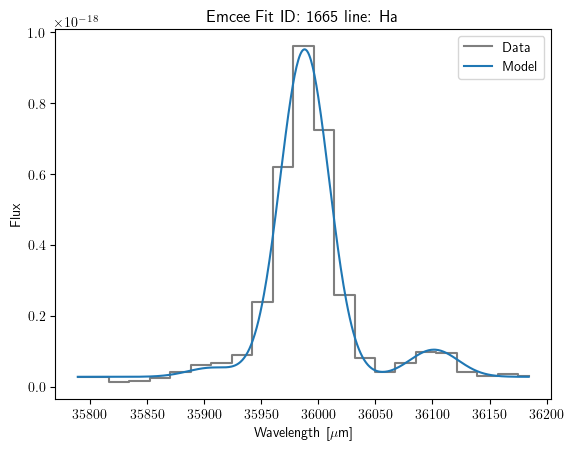

source #62
Minimization Guesses
A: 4.4358741749563985e-20
mu: 45078.54303592738
sigma: 0.0
b: 6.509929043584687e-21



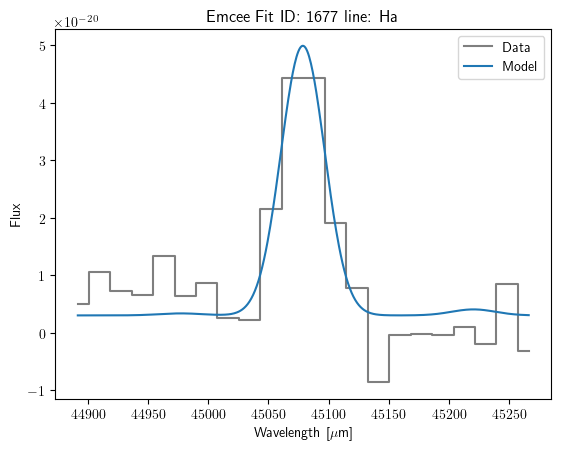

source #63
Minimization Guesses
A: 9.743782600975842e-20
mu: 39603.26575151838
sigma: 16.244268716203806
b: 4.829954126552685e-21



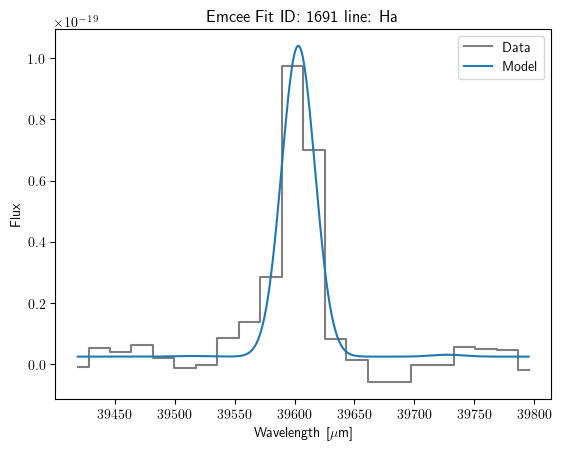

source #64
Minimization Guesses
A: 1.6859703541401848e-19
mu: 37154.92430936281
sigma: 17.85011097959432
b: 1.9897709825271692e-20



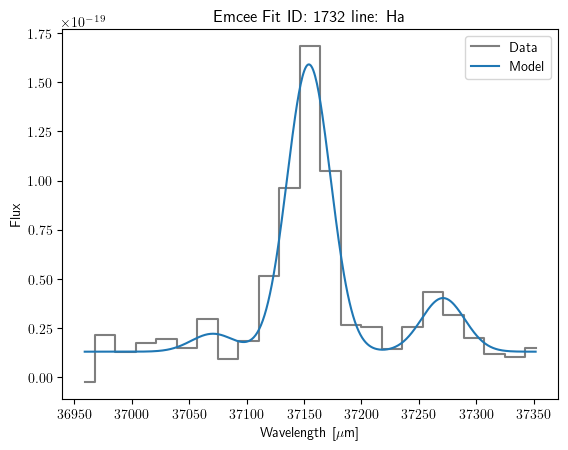

source #65
Minimization Guesses
A: 9.92031327416589e-18
mu: 20059.053621994808
sigma: 12.910139363784765
b: 6.374041971872621e-20



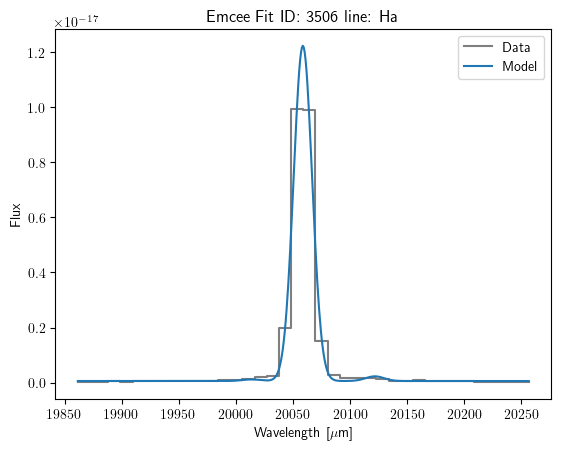

source #66
Minimization Guesses
A: 1.094562743524341e-19
mu: 37185.368512478184
sigma: 0.0
b: 4.839574877721585e-21



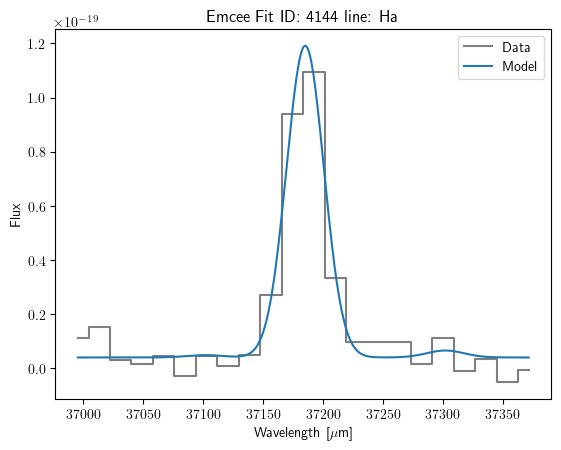

source #67
Minimization Guesses
A: 1.4539618522651553e-19
mu: 41060.72102891466
sigma: 17.154731153670582
b: 6.239370521571118e-21



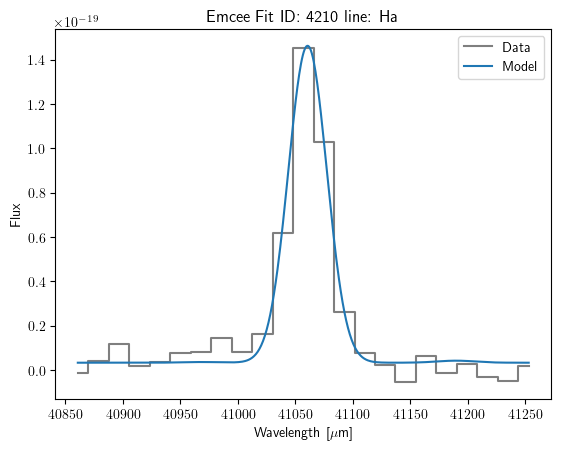

source #68
Minimization Guesses
A: 3.0852172963600246e-19
mu: 29027.31220143989
sigma: 14.152555650729482
b: 1.2776168523606025e-20



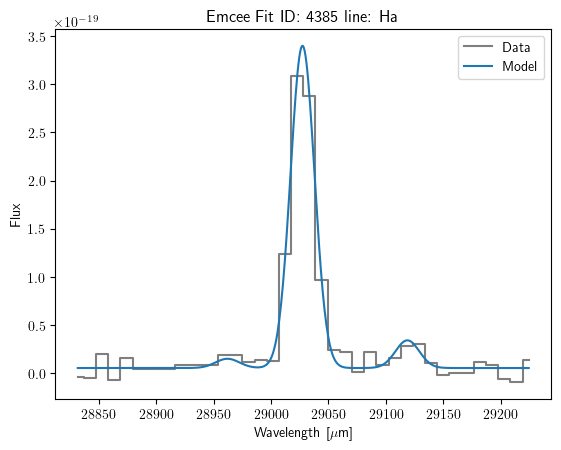

source #69
Minimization Guesses
A: 4.456117722790373e-19
mu: 19039.02402157857
sigma: 12.00901176051957
b: 5.99499262527635e-20



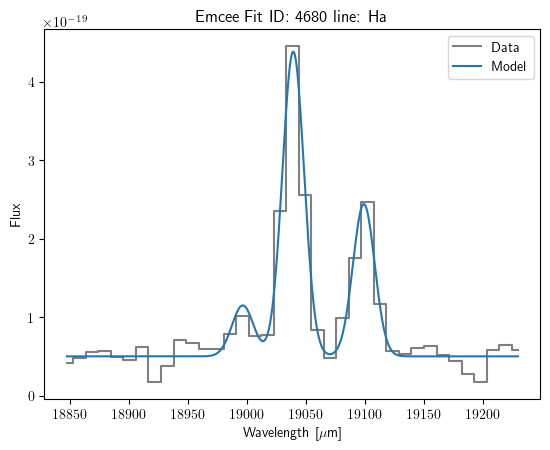

source #70
Minimization Guesses
A: 2.0977942851384438e-18
mu: 17629.368961470995
sigma: 12.395357630255603
b: 1.5955312988433005e-19



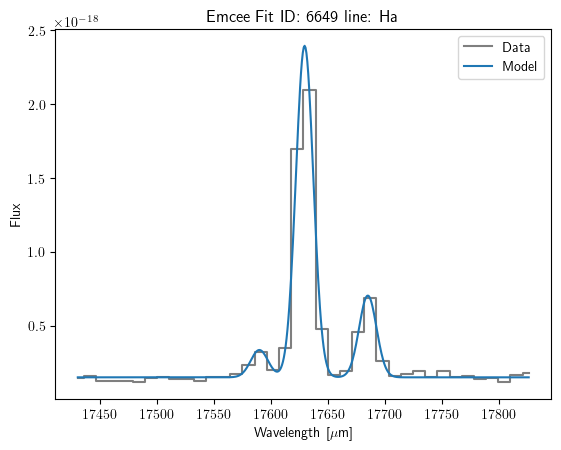

source #71
Minimization Guesses
A: 2.3420590655653e-18
mu: 16893.317253613743
sigma: 8.129488469143325
b: 1.197786470244501e-19



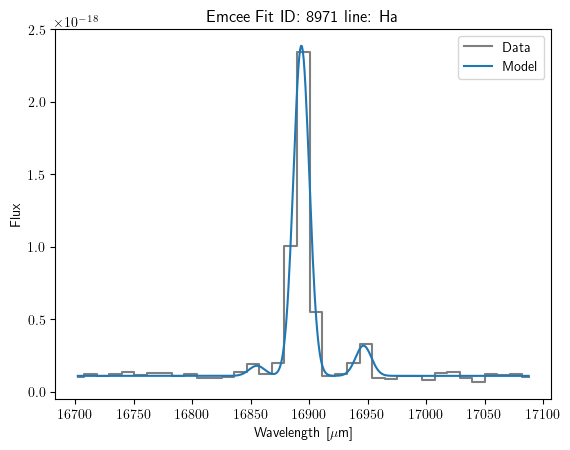

source #72
Minimization Guesses
A: 1.6510038617801148e-18
mu: 17273.690976153146
sigma: 12.168650924417307
b: 5.93921018746203e-20



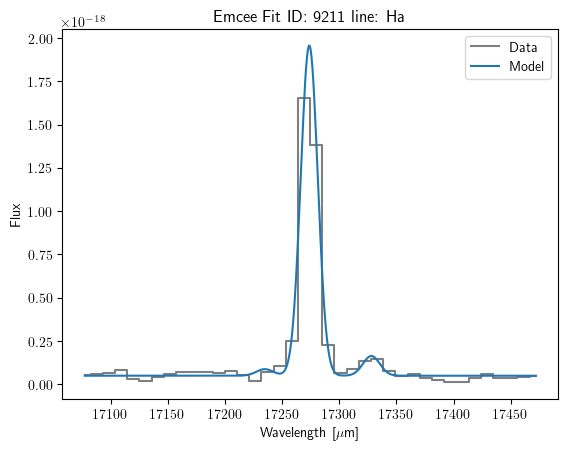

source #73
Minimization Guesses
A: 9.720768193167927e-20
mu: 26965.20873052286
sigma: 11.22946292690176
b: 7.368702358680027e-21



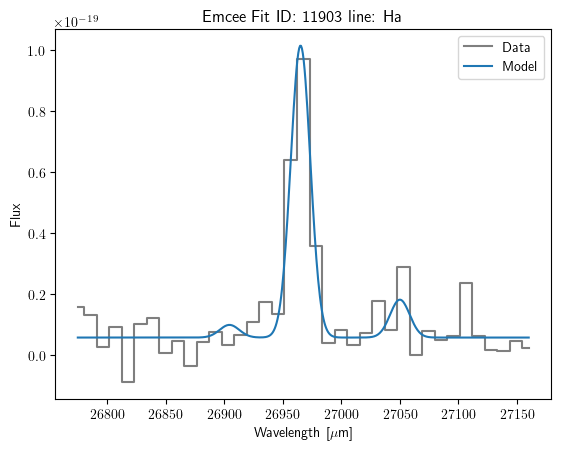

source #74
Minimization Guesses
A: 1.2953681353792448e-19
mu: 28537.348919215325
sigma: 16.116517474498323
b: 1.737662097881009e-21



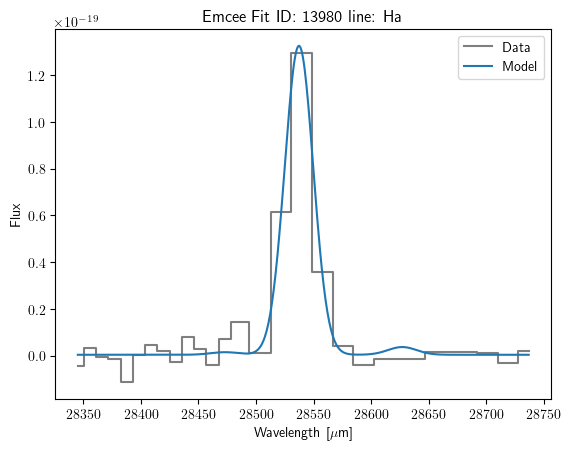

source #75
Minimization Guesses
A: 5.342691892823432e-19
mu: 15315.202653663682
sigma: 6.258343382977728
b: 1.5758972315757566e-20



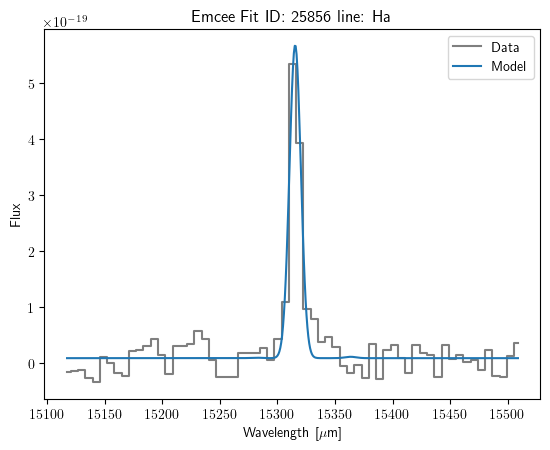

source #76
Minimization Guesses
A: 1.910989583486638e-19
mu: 17029.345807327056
sigma: 13.015661793308027
b: 2.73297872456465e-20



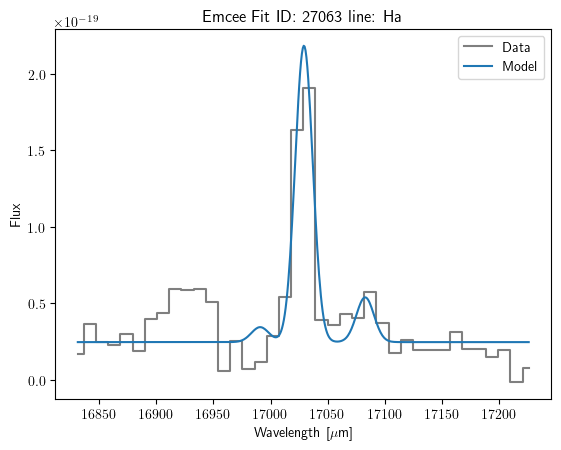

source #77
Minimization Guesses
A: 1.4935776970859607e-19
mu: 39357.80350696916
sigma: 16.18356531887548
b: 4.873533596590594e-21



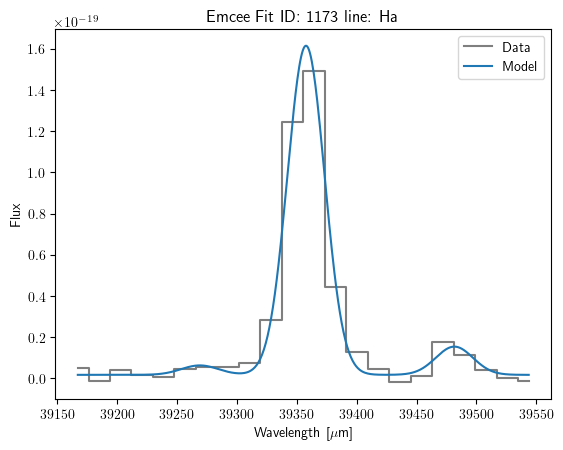

source #78
Minimization Guesses
A: 4.052798363981541e-20
mu: 35998.21498444331
sigma: 0.0
b: 7.067588435957756e-21



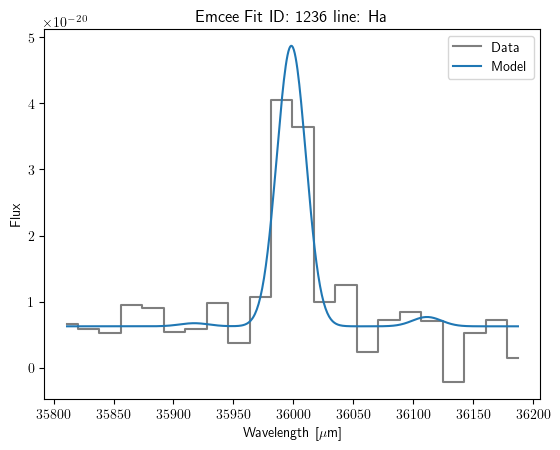

source #79
Minimization Guesses
A: 5.435046409737107e-20
mu: 42694.57570357233
sigma: 17.414522100702015
b: 2.5982783930044466e-21



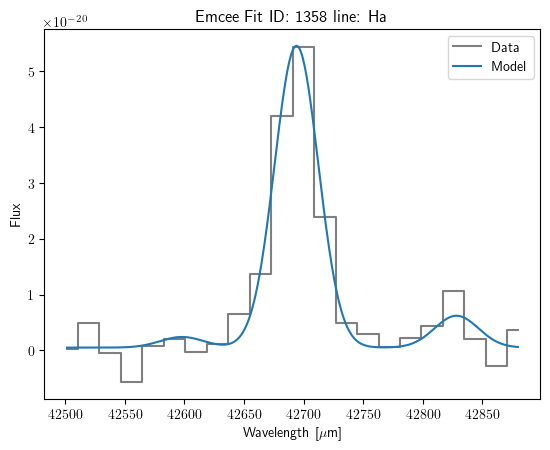

source #80
Minimization Guesses
A: 1.0230007440080309e-19
mu: 41303.71634099888
sigma: 16.44330459259072
b: 1.239157952975621e-20



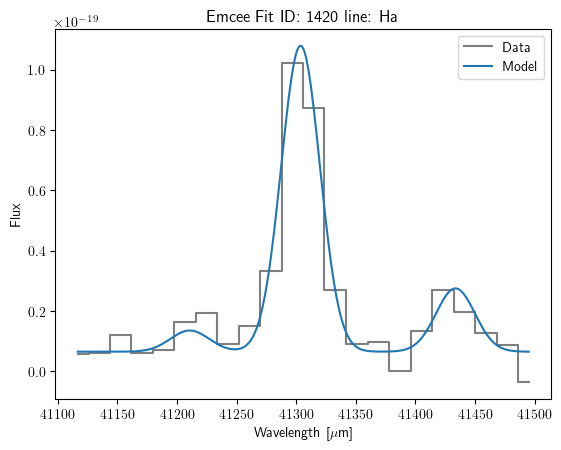

source #81
Minimization Guesses
A: 4.236856403529095e-19
mu: 37758.96493634571
sigma: 17.292403227314935
b: 1.4658805156383477e-20



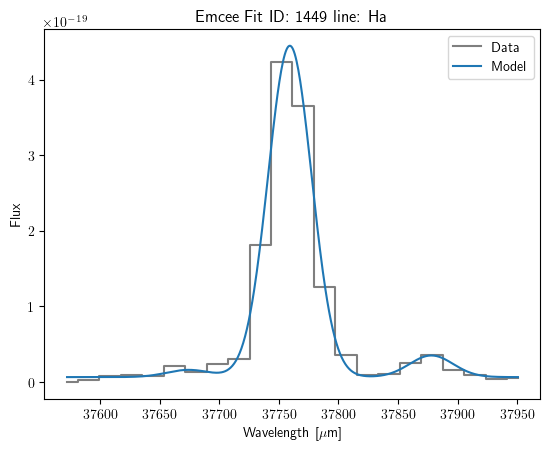

source #82
Minimization Guesses
A: 1.0846002418296503e-19
mu: 34068.24320120237
sigma: 15.676904172873037
b: 2.921241965246287e-21



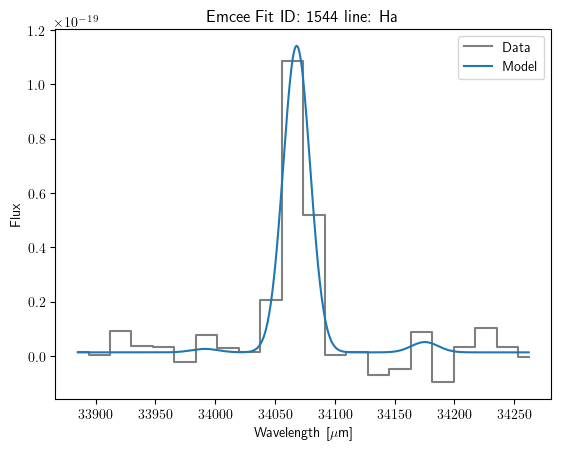

source #83
Minimization Guesses
A: 1.1474725080535312e-19
mu: 36961.49299768978
sigma: 16.780182312697434
b: 8.108589668275597e-21



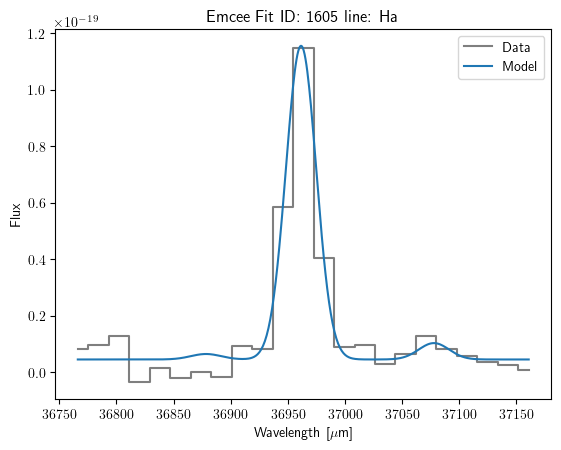

source #84
Minimization Guesses
A: 5.75631872780999e-20
mu: 36960.89158420008
sigma: 16.933093634201214
b: 8.880855358950079e-22



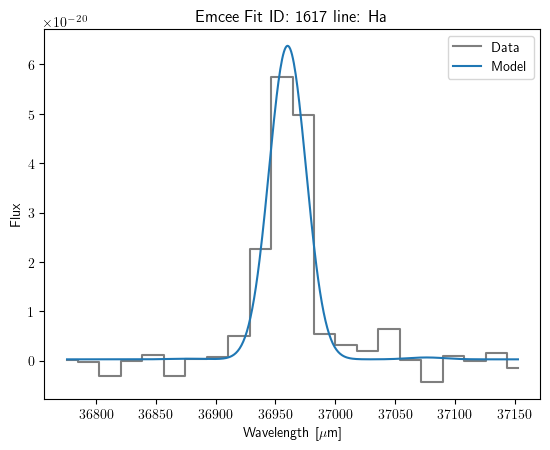

source #85
Minimization Guesses
A: 3.6530927132543837e-20
mu: 36590.75365328864
sigma: 16.076456286307803
b: 2.699938516038743e-21



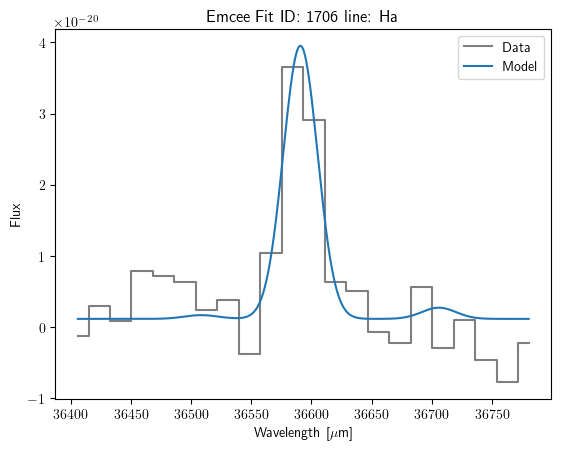

source #86
Minimization Guesses
A: 5.271273330346841e-20
mu: 35904.14445060611
sigma: 9.000226422616834
b: 2.966655134964143e-21



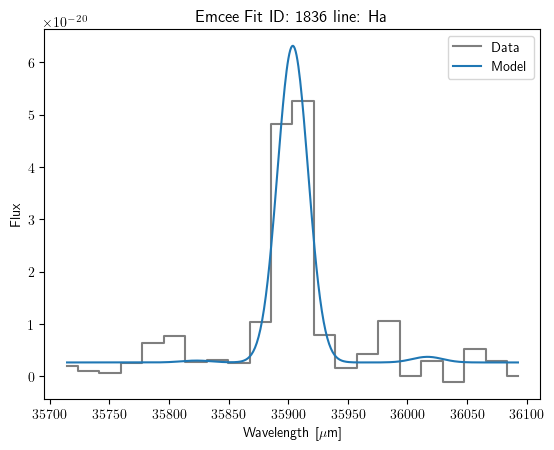

source #87
Minimization Guesses
A: 5.567633451049262e-20
mu: 41372.93690036559
sigma: 17.35389895573462
b: 2.970910242297016e-21



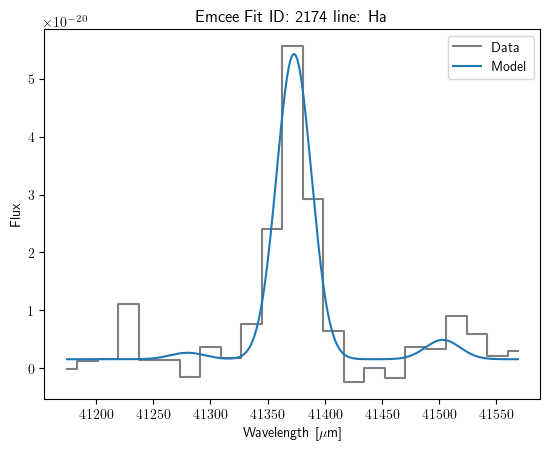

source #88
Minimization Guesses
A: 1.9493175321054878e-19
mu: 30647.830495980677
sigma: 17.82092013267902
b: 1.7578885790237836e-20



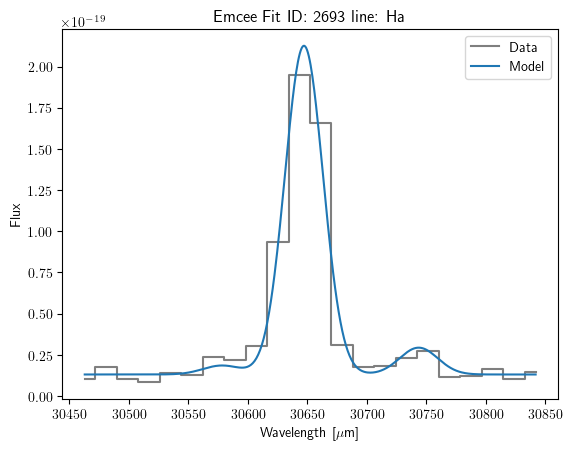

source #89
Minimization Guesses
A: 1.3944782269249185e-18
mu: 20756.28979205393
sigma: 12.109585512453123
b: 1.0540591305097364e-20



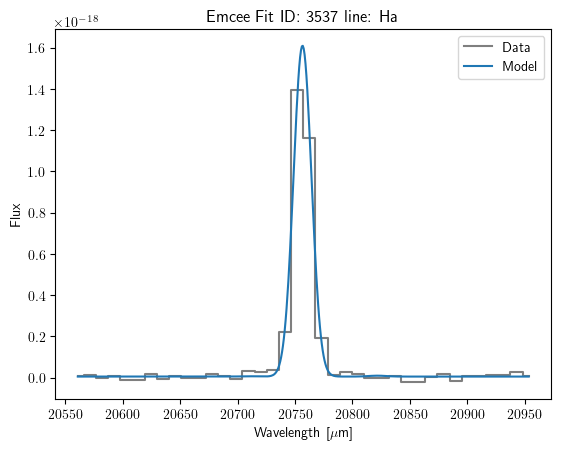

source #90
Minimization Guesses
A: 4.2963999970478227e-19
mu: 22129.293263377225
sigma: 16.213270659627597
b: 2.3646467156464538e-20



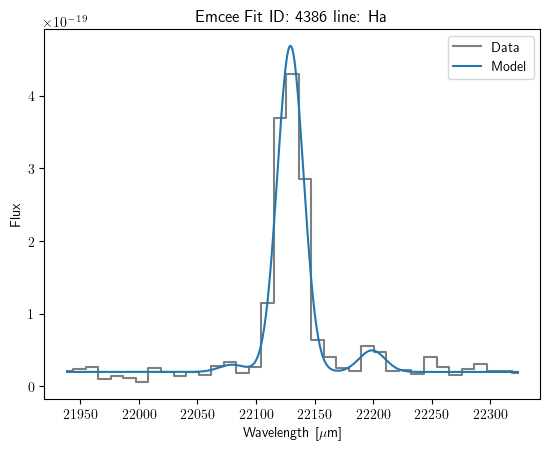

source #91
Minimization Guesses
A: 9.67671112965861e-19
mu: 23175.703515649464
sigma: 15.511280984053883
b: 3.472296612181732e-20



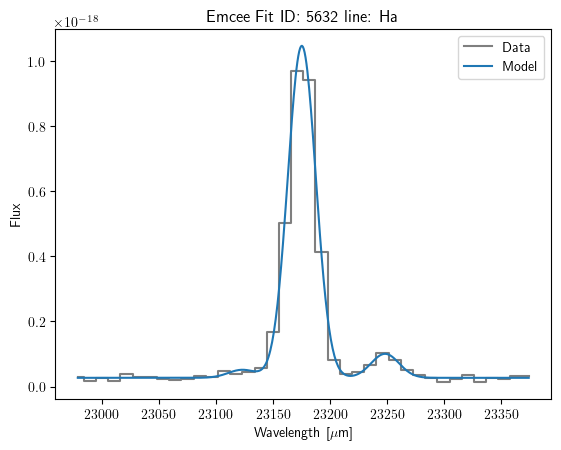

source #92
Minimization Guesses
A: 4.347031329771864e-18
mu: 16913.96220375977
sigma: 9.565823080589325
b: 1.1839008537821788e-19



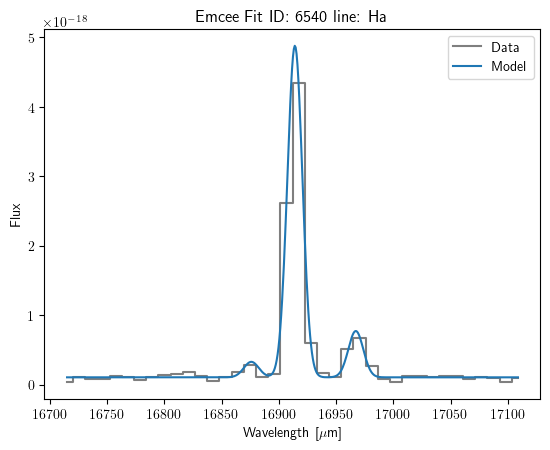

source #93
Minimization Guesses
A: 5.139838148264847e-19
mu: 24560.883397578637
sigma: 15.17147667732388
b: 3.469767505900061e-20



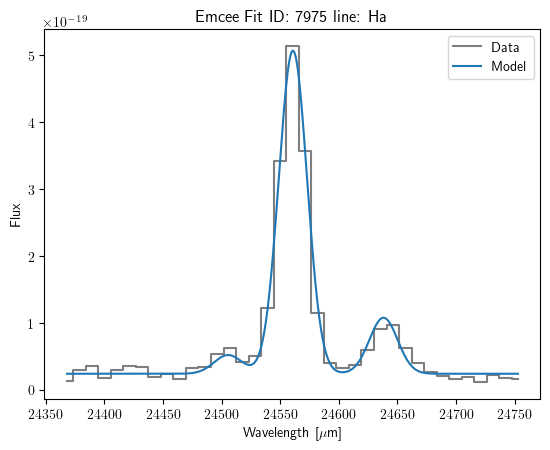

source #94
Minimization Guesses
A: 8.371551530389077e-19
mu: 20721.995506711537
sigma: 13.648565018303998
b: 6.966447460481862e-20



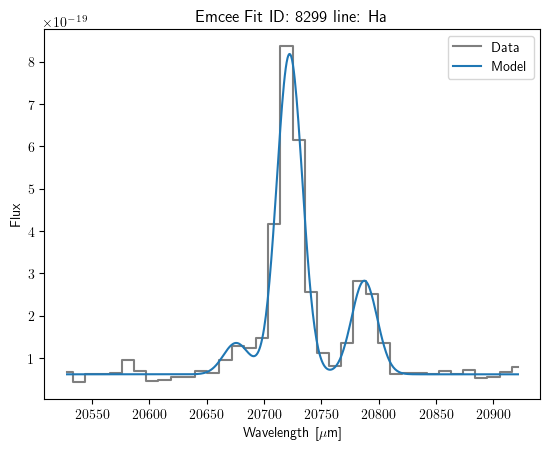

source #95
Minimization Guesses
A: 1.0680873002017454e-18
mu: 17996.5066575724
sigma: 7.238417607046358
b: 3.986064122532298e-20



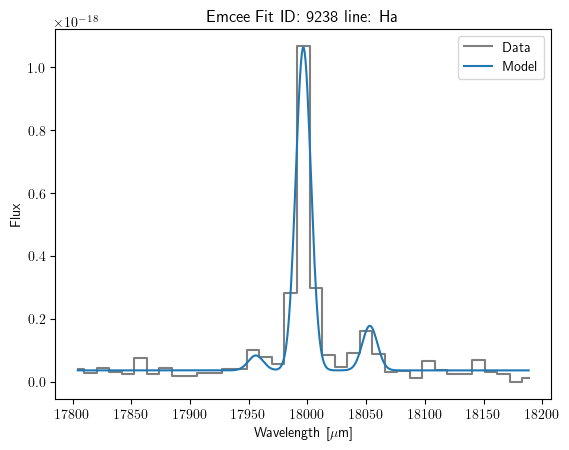

source #96
Minimization Guesses
A: 3.226164611372265e-19
mu: 31963.098009047655
sigma: 16.4944188368936
b: 6.399761418746447e-21



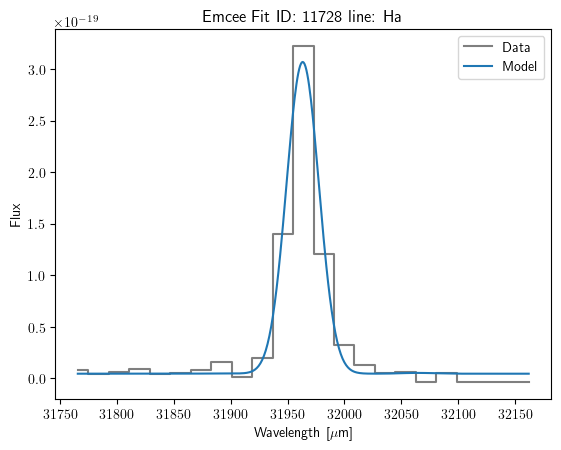

source #97
Minimization Guesses
A: 3.6476546840308204e-20
mu: 34043.793602969556
sigma: 0.0
b: 2.3020474380238436e-21



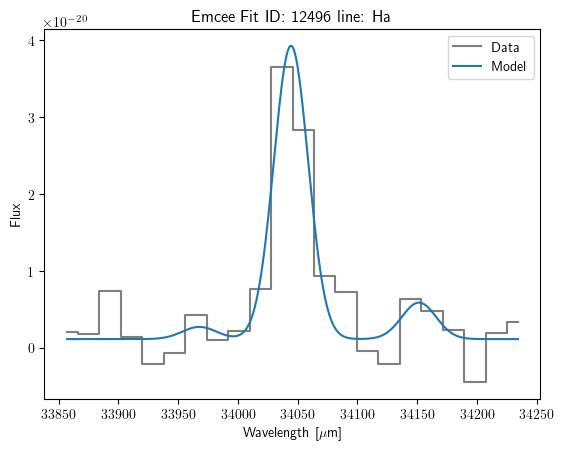

source #98
Minimization Guesses
A: 2.4324877324884095e-19
mu: 23445.174272597735
sigma: 13.143204410833278
b: 5.888014662397164e-21



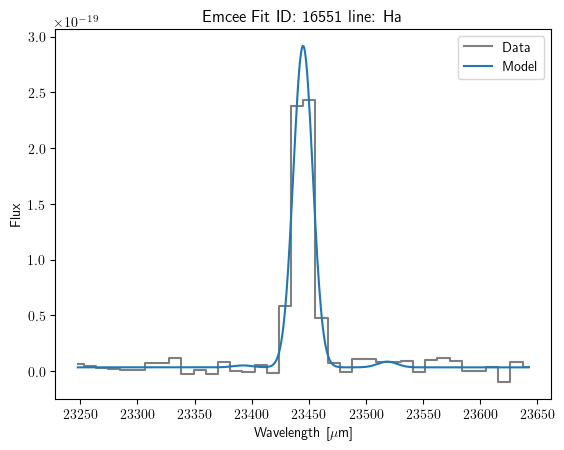

source #99
Minimization Guesses
A: 1.9762525828078461e-19
mu: 24520.2550654989
sigma: 11.658490299199912
b: 6.457180271224321e-21



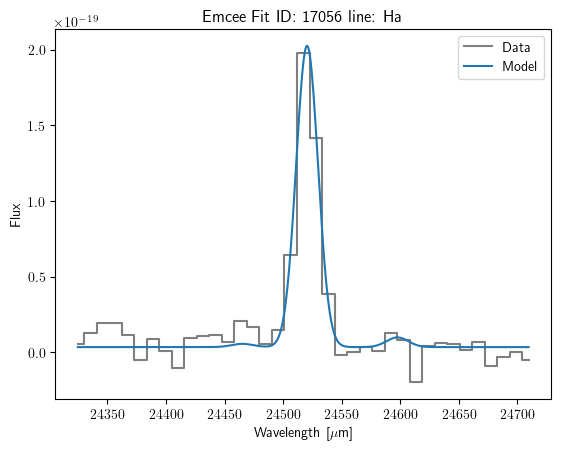

source #100
Minimization Guesses
A: 1.8204943426518713e-19
mu: 21678.531239606153
sigma: 8.411607006904887
b: 5.816820699141463e-21



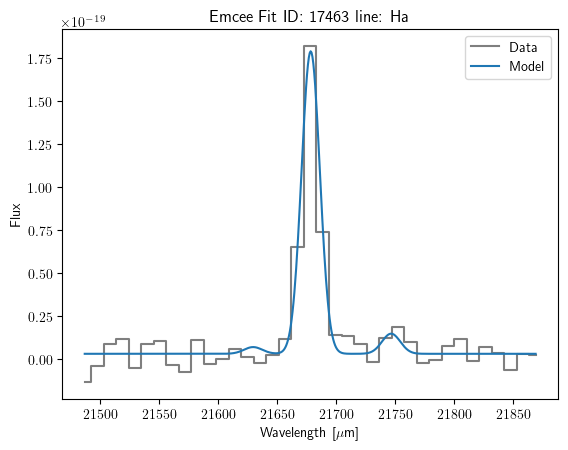

source #101
Minimization Guesses
A: 2.0735282118134606e-18
mu: 14951.383019447321
sigma: 7.467387732614952
b: 6.360497622985723e-20



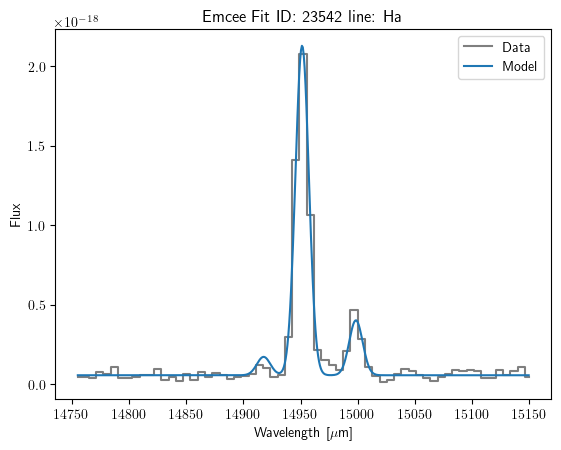

source #102
Minimization Guesses
A: 5.050298696499252e-19
mu: 15800.61902639233
sigma: 5.739053333917582
b: 4.4489358004528555e-20



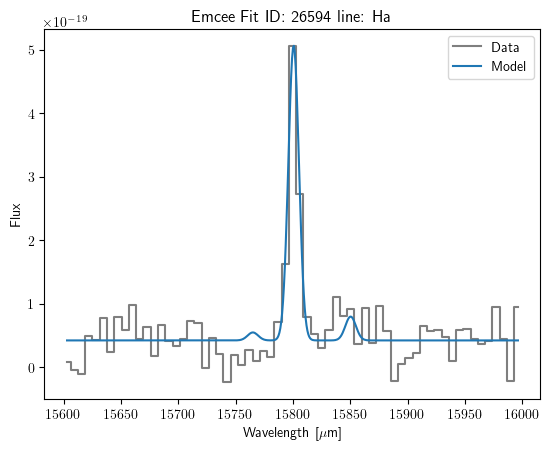

source #103
Minimization Guesses
A: 2.469482959613783e-19
mu: 14703.531086789768
sigma: 5.206877280018489
b: 2.7941769924557363e-20



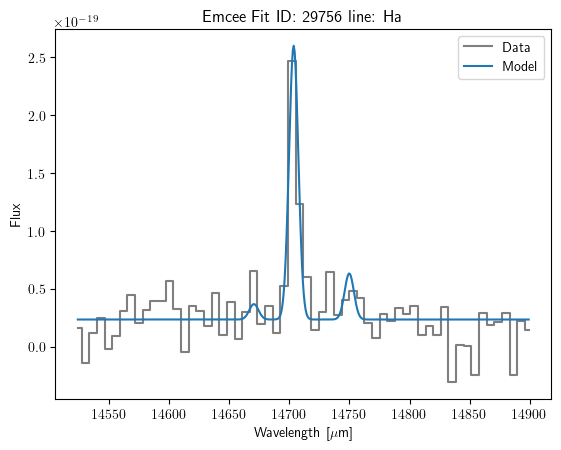

source #104
Minimization Guesses
A: 1.6364014057324893e-19
mu: 17205.11187375393
sigma: 9.070784858045954
b: 7.291453917975315e-21



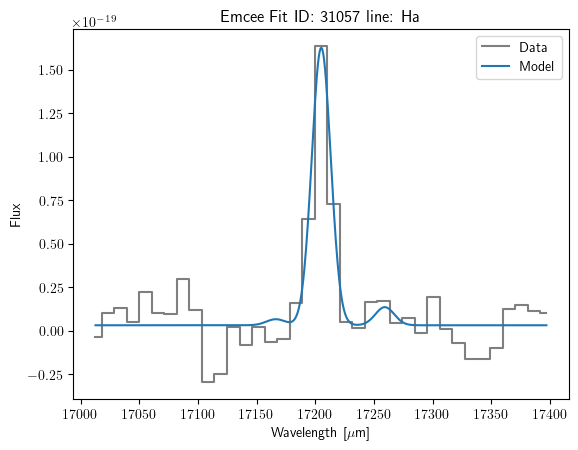

source #105
Minimization Guesses
A: 8.553327831255316e-19
mu: 15862.02367133396
sigma: 5.447343876968262
b: -4.23071185101945e-21



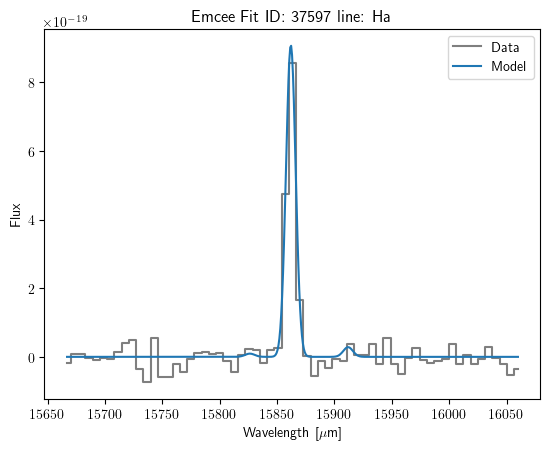

source #106
Minimization Guesses
A: 2.879803875712976e-20
mu: 34660.47600705259
sigma: 17.711834224050108
b: 3.3914596685628175e-21



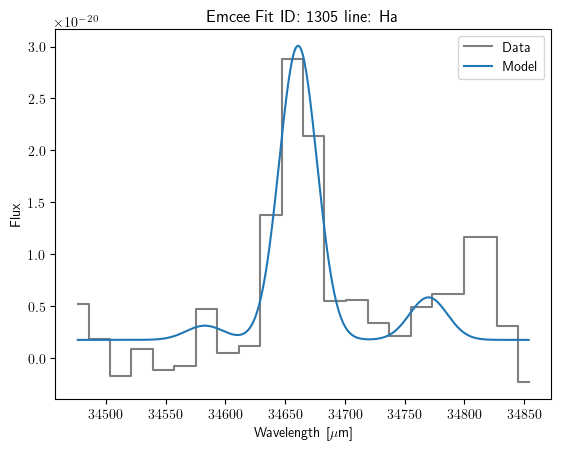

source #107
Minimization Guesses
A: 4.499331071834065e-20
mu: 39440.50989325552
sigma: 16.907863341657503
b: 2.9539228951253314e-21



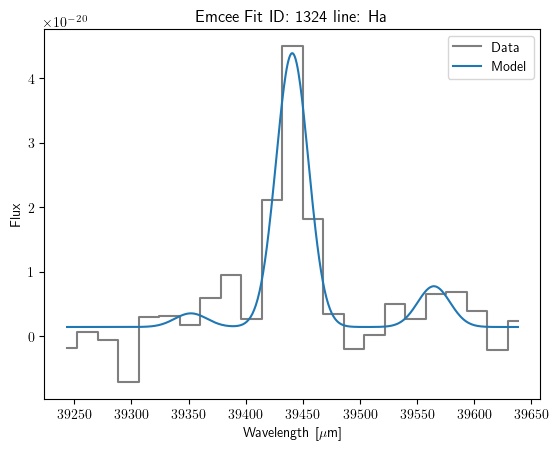

source #108
Minimization Guesses
A: 5.707713679504484e-20
mu: 34839.01932828096
sigma: 17.70104834373342
b: 4.630969484152219e-21



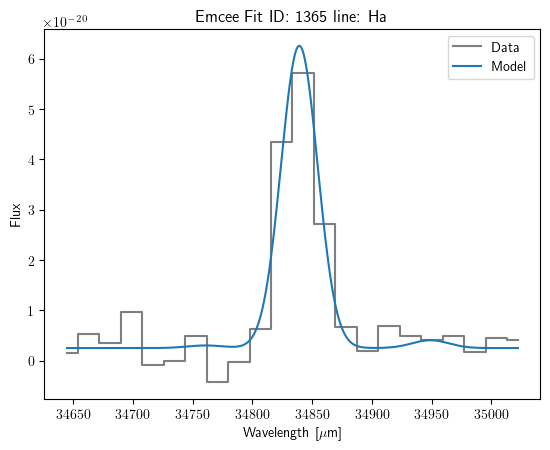

source #109
Minimization Guesses
A: 1.8361201238453848e-20
mu: 38233.611387166275
sigma: 17.479317660556262
b: 1.76930897607368e-21



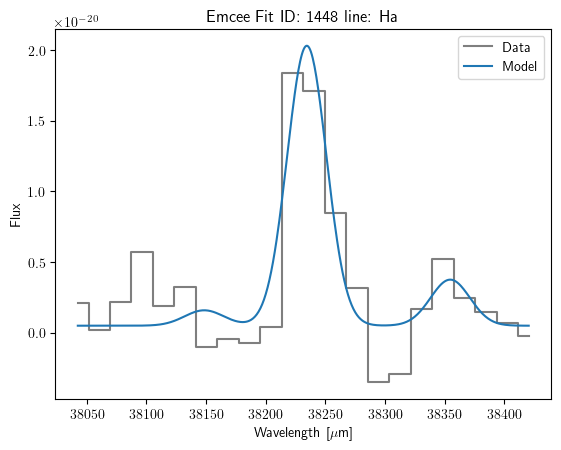

source #110
Minimization Guesses
A: 1.9724466194615246e-19
mu: 39608.87208607738
sigma: 17.5719643628654
b: 6.89699761192989e-21



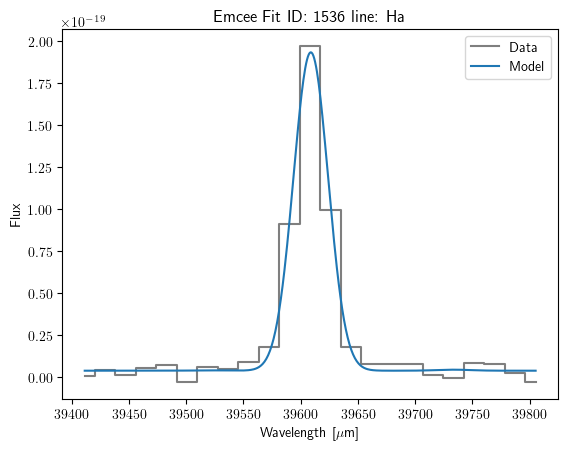

source #111
Minimization Guesses
A: 1.911450198784892e-19
mu: 38624.95276759022
sigma: 0.0
b: 6.776590592627371e-21



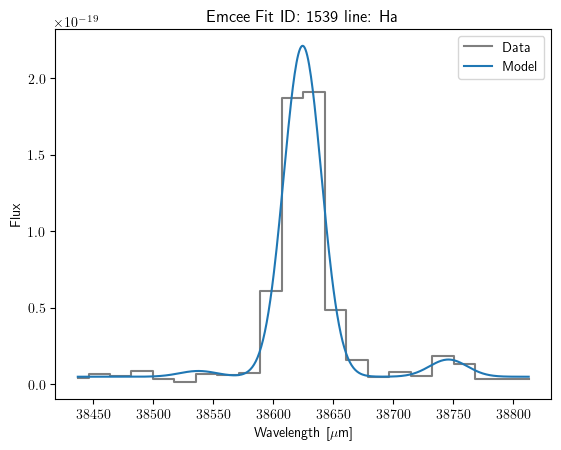

source #112
Minimization Guesses
A: 5.909790767821997e-20
mu: 35509.85007771713
sigma: 8.969244128380524
b: 1.8061104503127153e-21



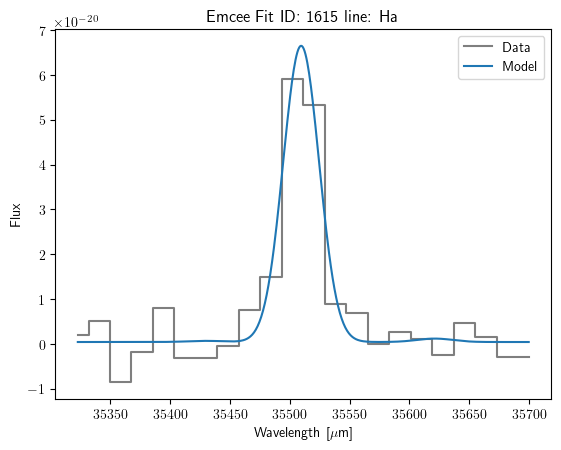

source #113
Minimization Guesses
A: 1.0283675969296472e-19
mu: 28775.558812646348
sigma: 17.54466162634162
b: 8.78982026160281e-21



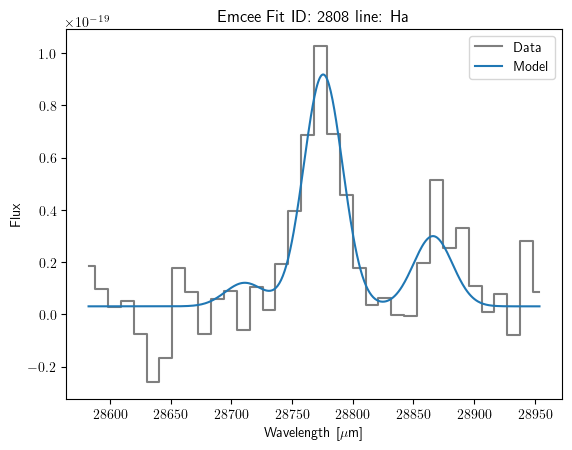

source #114
Minimization Guesses
A: 2.3081488780068684e-19
mu: 23708.02593878166
sigma: 9.65294489468215
b: 9.756886900539175e-22



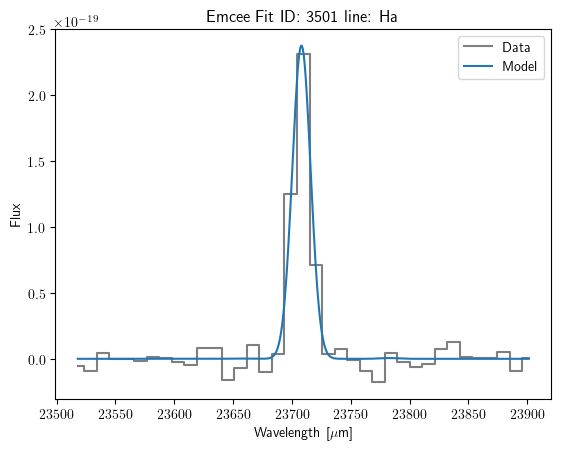

source #115
Minimization Guesses
A: 5.661133146999724e-19
mu: 22901.781508042364
sigma: 13.85384027123655
b: 1.1165118679489284e-20



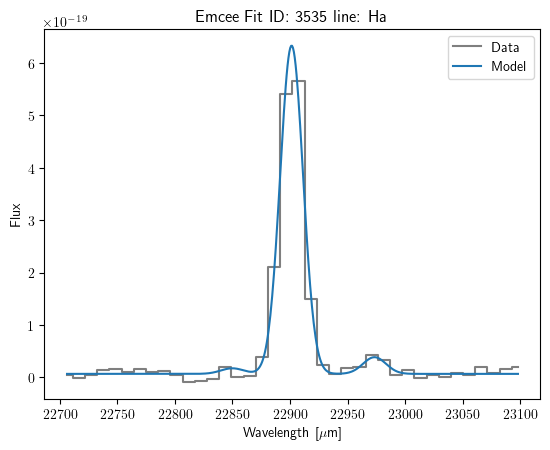

source #116
Minimization Guesses
A: 3.43050790625485e-19
mu: 15761.753422815724
sigma: 6.936957295059983
b: 2.3465460655629182e-20



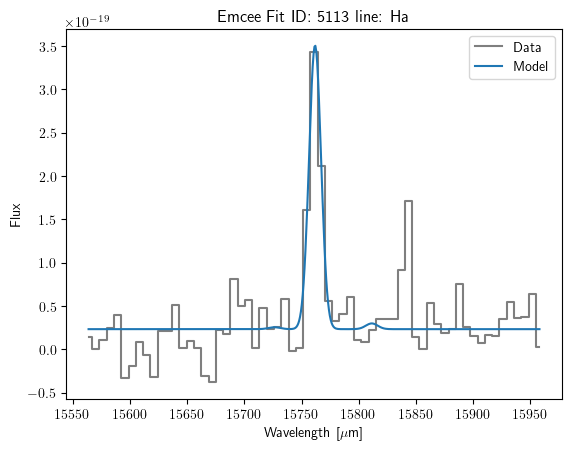

source #117
Minimization Guesses
A: 4.2990068170021125e-19
mu: 20904.021962822735
sigma: 8.355696489519687
b: 2.5062991629136634e-20



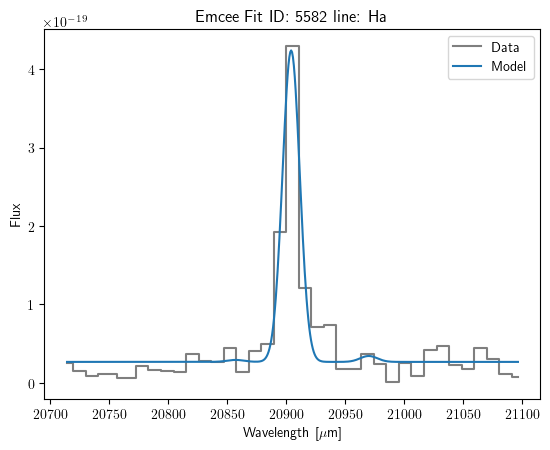

source #118
Minimization Guesses
A: 6.302247566559469e-19
mu: 16845.924520360186
sigma: 9.788940399354033
b: 3.662767528259008e-20



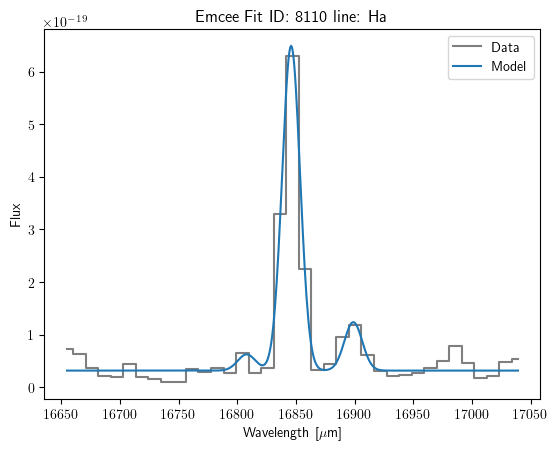

source #119
Minimization Guesses
A: 6.993727838398431e-19
mu: 16853.763954151236
sigma: 11.672359730921016
b: 4.6425891032979056e-20



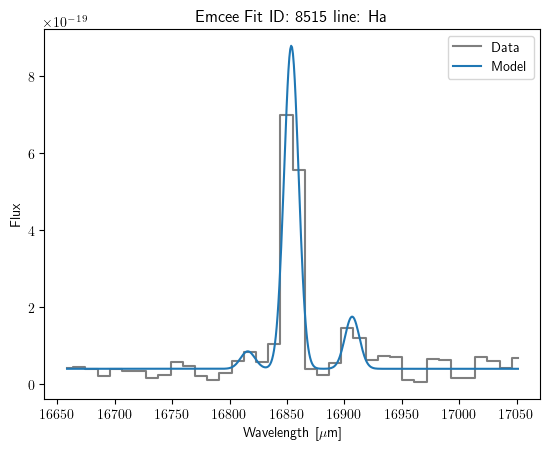

source #120
Minimization Guesses
A: 1.1723296635843458e-18
mu: 20044.238869156317
sigma: 12.440057265295764
b: 5.630902100107296e-20



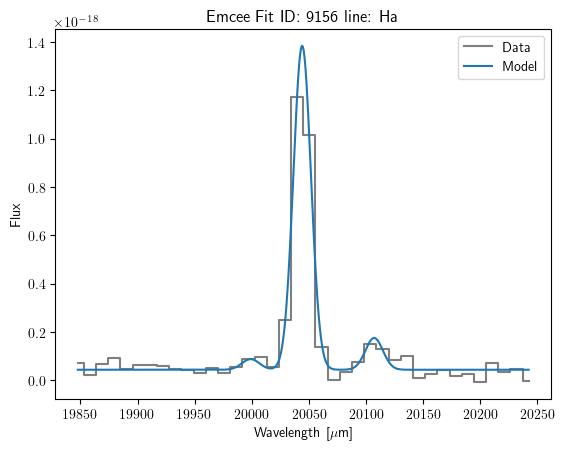

source #121
Minimization Guesses
A: 7.002035247435145e-20
mu: 34588.4308166503
sigma: 17.267293814504228
b: 6.2781506759847116e-21



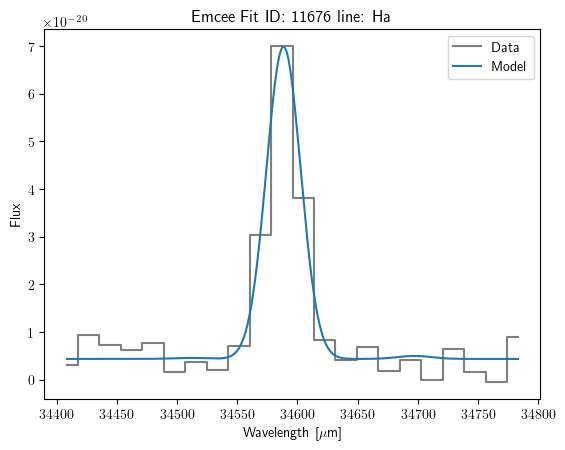

source #122
Minimization Guesses
A: 2.212554219548286e-19
mu: 25963.479858698945
sigma: 12.128742597253222
b: -1.5431060041064036e-21



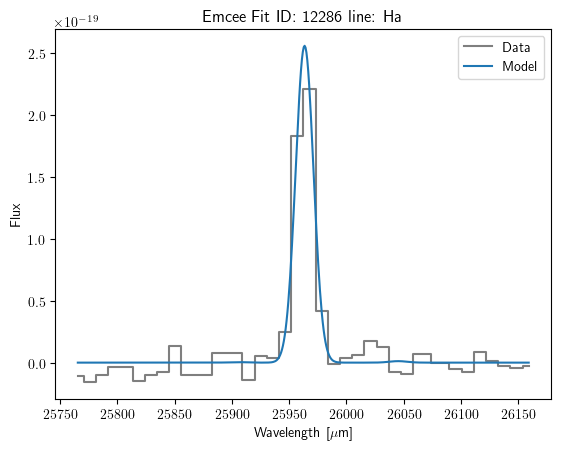

source #123
Minimization Guesses
A: 4.1248126599669662e-19
mu: 28363.79146217865
sigma: 11.796595008232543
b: 5.26041115242284e-21



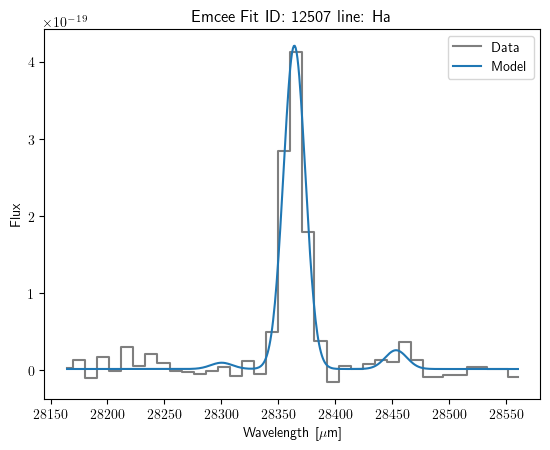

source #124
Minimization Guesses
A: 2.1325114515167767e-19
mu: 24753.082943394777
sigma: 10.443960060581958
b: -2.1944367356677733e-21



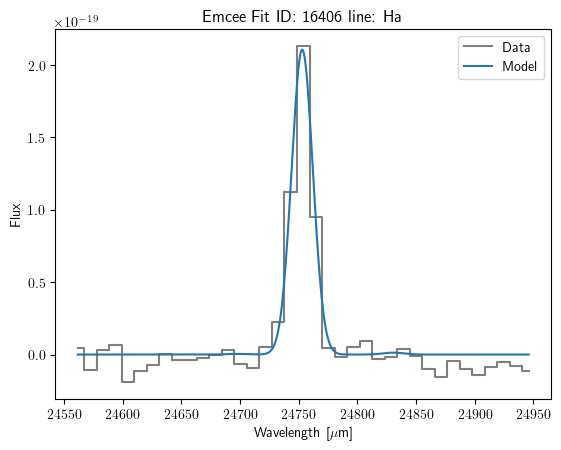

source #125
Minimization Guesses
A: 3.311808050144189e-19
mu: 22143.470466373852
sigma: 12.984475871215182
b: 5.75179114983787e-21



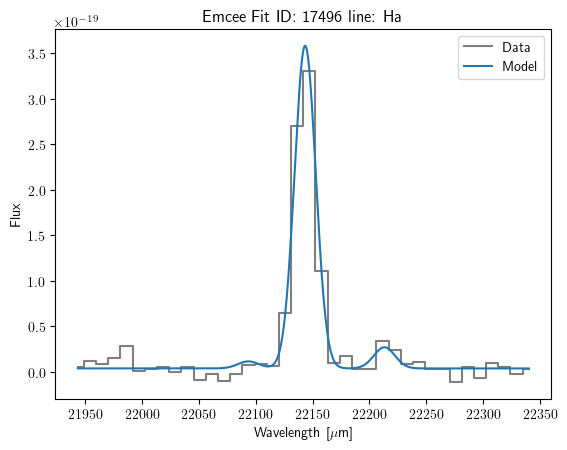

source #126
Minimization Guesses
A: 5.758031755496213e-19
mu: 23866.948359744827
sigma: 13.499099282906172
b: 3.461561831882695e-20



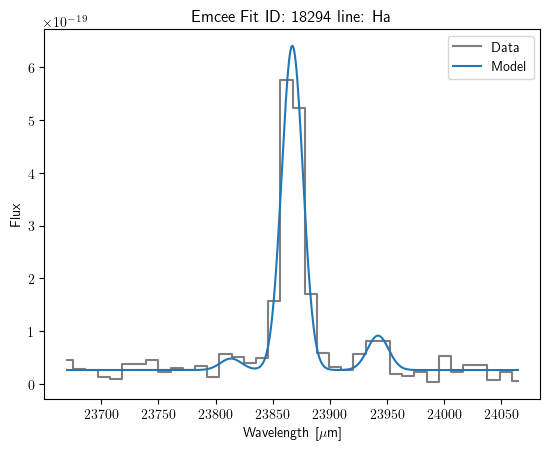

source #127
128 fitted sources


df  \
0                    A         A_NII            m...   
1                    A         A_NII            m...   
2                    A         A_NII            m...   
3                    A         A_NII            m...   
4                    A         A_NII            m...   

                                                wavs  \
0  [43556.32946462007, 43574.22443081797, 43592.1...   
1  [46067.36729967215, 46085.35961188798, 46103.3...   
2  [43557.848340112374, 43575.851156317, 43593.85...   
3  [38516.930193504515, 38534.85695213741, 38552....   
4  [34450.24707356718, 34468.184677674086, 34486....   

                                              fluxes  \
0  [-1.2931749924355932e-21, -3.561023276121144e-...   
1  [-3.226700629829683e-21, -5.858832447144742e-2...   
2  [8.542738489214365e-21, 7.397328980987137e-21,...   
3  [-7.638257788041301e-22, 2.1733986785801787e-2...   
4  [9.899100184192686e-21, 8.112499127641636e-21,...   

                                          fluxes_err  \
0  [1.933020301215386e-21, 2.0795483861654433e-21...   
1  [4.19804204155007e-21, 2.8922180228117473e-21,...   
2  [1.9462564436333866e-21, 1.83115196351393e-21,...   
3  [1.5141287486447222e-21, 1.3824149882488922e-2...   
4  [2.5149090457439007e-21, 2.2416908141373868e-2...   

                                       median_params             A  \
0  [8.067921154138704e-20, 8.972930151685143e-23,...  8.067921e-20   
1  [4.5903611421855074e-20, 9.72321902984496e-22,...  4.590361e-20   
2  [4.3320819962444996e-20, 9.951532657555904e-23...  4.332082e-20   
3  [3.0460900361682596e-20, 4.15126389695687e-22,...  3.046090e-20   
4  [3.0224721662129357e-20, 4.933298099895226e-22...  3.022472e-20   

                                               A_err         A_NII  \
0  [1.2528908612076787e-22, 3.2458927993797898e-2...  8.972930e-23   
1  [1.3145736759690878e-23, 4.0717517520875036e-2...  9.723219e-22   
2  [1.250636889226423e-22, 2.3629281622745932e-21...  9.951533e-23   
3  [2.431895998792868e-23, 2.4119582278136955e-21...  4.151264e-22   
4  [1.906548729127782e-23, 2.666155450505615e-21,...  4.933298e-22   

             mu      sigma                                          sigma_err  \
0  43750.166262  23.395300  [0.0024597193747268875, 0.8639202214476676, 0....   
1  46266.957923  17.931222  [0.015787389454093415, 1.4425945831980904, 1.4...   
2  43755.870557  36.765455  [0.03905782223549892, 2.597334762964401, 2.519...   
3  38702.140397  22.372860  [0.026563246523060968, 1.3421318828186273, 1.3...   
4  34642.442823  23.071327  [0.060067913707055, 1.5186176552096704, 1.6387...   

              b  
0  4.195405e-23  
1  1.071226e-21  
2  5.336595e-21  
3  2.009798e-21  
4  2.493061e-21

In [43]:
# intializing dataframe
line_name = 'Ha'
line_window = 200  # [A]
columns = ['df', 'wavs','fluxes','fluxes_err','median_params','A','A_err','A_NII','mu','sigma','sigma_err','b']
Ha_emcee_df = pd.DataFrame(columns=columns)

for source in range(len(NIRSpec_df['ID'])):

    try:
        check_wave, check_flux, check_flux_err, check_df = fitting_Ha_line(wavs_cleaned[source],
                                                                           fluxes_cleaned[source],
                                                                           fluxes_err_cleaned[source],
                                                                           Ha_curve_fit_df['mu'][source],
                                                                           line_window, NIRSpec_df['ID'][source],
                                                                           line_name,save=False,diagnose=True)
        
        # median A, A_NII, mu, sigma, b parameter values
        median_params = check_df.quantile(q=0.5).values[:-2]
        A = median_params[0]
        A_NII = median_params[1]
        mu = median_params[2]
        sigma = median_params[3]
        b = median_params[4]
        
        # gathering errors
        A_quantile_16 = check_df.quantile(q=0.16).values[0]
        A_qunatile_84 = check_df.quantile(q=0.84).values[0]
        A_mean_quantiles = np.mean([A_quantile_16,A_qunatile_84])
    
        sigma_quantile_16 = check_df.quantile(q=0.16).values[3]
        sigma_qunatile_84 = check_df.quantile(q=0.84).values[3]
        sigma_mean_quantiles = np.mean([sigma_quantile_16,sigma_qunatile_84])
    
        # [mean err (mean of 16% & 84%), 16% err, 84% err]
        A_err = [np.abs(A-A_mean_quantiles),A-A_quantile_16,A_qunatile_84-A]
        sigma_err = [np.abs(sigma-sigma_mean_quantiles),sigma-sigma_quantile_16,sigma_qunatile_84-sigma]
        
        new_row = [check_df,check_wave,check_flux,check_flux_err,median_params,A,A_err,A_NII,mu,sigma,sigma_err,b]
        df_extended = pd.DataFrame(data=[new_row], columns=columns)
        Ha_emcee_df = pd.concat([Ha_emcee_df, df_extended],ignore_index=True)
        print(f'source #{source}')

    except Exception as e:
        print(f"Error processing source {source}: {e}")

print(len(Ha_emcee_df),'fitted sources')
Ha_emcee_df.head()

### Defining emcee for H-beta fitting

In [45]:
def log_likelihood(theta, x, y, yerr):
    '''
    This is the likelihood function we are using for emcee to run
    
    This likelihood function is the maximum likelihood assuming gaussian errors.
    '''
    ################
    # The value we are trying to fit
    #A, mu, sigma, m, b = theta
    
    #Making the model of the emission line
    model = Hb_line_model(x, *theta)
    
    #getting the log likelihood, this is similar to chi2
    lnL = -0.5 * np.nansum((y - model) ** 2 / yerr**2)
    
    return lnL

def log_prior(theta, wave_center, Amp_max):
    '''
    The prior function to be used against the parameters to impose certain criteria for the fitting
    '''
    #Theta values that goes into our Gaussian Model
    A, mu, sigma, b = theta
    
    #the left most and right most the central wavelength can vary
    left_mu = wave_center - 20  # [A] # had to change these as well this is how much mu can vary
    right_mu = wave_center + 20 # [A] # had to change these as well this is how much mu can vary
    
    #min and max amplitude of the emission line
    min_A = 0
    max_A = Amp_max * 2
    
    sigma_window_left = 1 # [A] # had to change these for the input spectra these are left bounds for sigma
    sigma_window_right = 50 # [A] # had to change these for the input spectra these are right bounds for sigma
        
    if (0 < A < max_A) & (left_mu <= mu <= right_mu) & (sigma_window_left <= sigma < sigma_window_right) & (b > 0):
        return 0.0
    else:
        return -np.inf
    
def log_probability(theta, x, y, yerr, first_wave, Amp_max):
    
    lp = log_prior(theta, first_wave, Amp_max)
    if not np.isfinite(lp):
        #print('Probability is infinite')
        return -np.inf
    
    prob = lp + log_likelihood(theta, x, y, yerr)

    #print(f'Prob:{prob:.3E}')
    return prob
                                                        # added source_id input for diagnosis purposes
def initial_fits_Hb(wave, spectrum, err_spec, window, line_center, source_id, line_name,diagnose = False):
    '''
    This function does an initial fit on the data using curve fit which we then pass in those parameters into emcee
    to do the full MCMC fit later
    '''
    window_check = np.log10(window)
    
    #if window_check > -2:
        #print('WARNING: Search window may be too big double check input value')
    
    
    #the range where the optimization can look between 
    min_window = line_center - window
    max_window = line_center + window
    
    #getting emission line near the line center
    #line_center +/- window
    indx = np.where((min_window < wave) & ((wave < max_window)))[0]

    spec_window = spectrum[indx]
    wave_window = wave[indx]
    err_spec_window = err_spec[indx]
    
    #initial guesses for the optimization
    guess_A = np.amax(spec_window)
    guess_mu = line_center
    med_continuum = np.median(spec_window)

    # setting new window for sigma guess, to avoid noisy peaks contaminating the guess
    # for H-beta, sigma should be less than ~40 A
    small_min_window = line_center - 20 # [A]
    small_max_window = line_center + 20 # [A]
    small_indx = np.where((small_min_window < wave) & ((wave < small_max_window)))[0]
    small_spec_window = spectrum[small_indx]
    small_wave_window = wave[small_indx]

    # interpolating small window
    spec_interp = Akima1DInterpolator(small_wave_window, small_spec_window)
    x = np.linspace(small_wave_window[0], small_wave_window[-1], 10000)
    spec = spec_interp(x)
    half_max = guess_A / 2
    idx = np.where(spec > half_max)[0]
    wave_left, wave_right = x[idx[0]], x[idx[-1]]
    
    guess_sigma = (wave_right - wave_left)/2
    
    if diagnose == True:
        
        print('Minimization Guesses')
        print(f"A: {guess_A}")
        print(f"mu: {guess_mu}")
        print(f"sigma: {guess_sigma}")
        print(f"b: {med_continuum}")
        print() 

    x0 = [guess_A, guess_mu, guess_sigma, med_continuum]

    #Code to add to account for negative continuum (b)
    if med_continuum < 0:
        low_bounds = [0, min_window, 0, np.median(spec_window)*2]
        high_bounds = [2*guess_A, max_window, 50, np.median(spec_window)/2] # [A]
    else:
        low_bounds = [0, min_window, 0, np.median(spec_window)/2]
        high_bounds = [2*guess_A, max_window, 50, np.median(spec_window)*2] # [A]
    
    # Optimization of the initial gaussian fit
    result,_ = curve_fit(Hb_line_model, wave_window, spec_window, p0 = x0, 
                          bounds = [low_bounds, high_bounds])  #bounds on b
    
    ########
    # Diagnostic Plotting: making sure we are getting the emission line
    ########
    # if diagnose == True:
        
    #     print('Minimization Results')
    #     print(f"A: {result[0]}")
    #     print(f"mu: {result[1]}")
    #     print(f"sigma: {result[2]}")
    #     print(f"b: {result[3]}")
    #     print()
        
    #     xarr = np.linspace(wave_window[0], wave_window[-1], 100)
    #     plt.figure()
    #     plt.plot(wave_window, spec_window, color = 'blue', label = 'Data')
    #     plt.scatter(wave_window, spec_window, color = 'blue')
    #     plt.plot(xarr, Hb_line_model(xarr, *result), color = 'black', label = 'Model')
    #     plt.axhline(0, linestyle = '--')
    #     plt.ylabel('Flux')
    #     plt.xlabel(r'Wavelength $\mu$m')
    #     plt.title('Initial Curvefit ID: '+str(source_id)+' line: '+str(line_name))
    #     plt.legend()
    #     plt.show()

    return result
                                    # added source_id input for diagnosis purposes
def fitting_Hb_line(wave, flux, flux_err, line_center, window_wavelength, source_id, line_name, 
                 diagnose = False,save=True, filename = 'Emcee_Chains_Galaxy.txt'):
    '''
    The code that fits the line using the emcee approach
    '''
    result = initial_fits_Hb(wave, flux, flux_err, window_wavelength, line_center, source_id, line_name, diagnose = diagnose)
    
    #getting the results from the initial fit to then pass into emcee
    guess_A = result[0]
    guess_mu = result[1]
    guess_sigma = result[2]
    guess_b = result[3]
    
    
    #making walkers so that we can use emcee to explore the parameter space
    #centered on the best results from minimization
    amp_jump = np.random.normal(loc = guess_A,            #centered on best A from minimization
                                scale = guess_A/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
    
    wavelength_jump = np.random.normal(loc = guess_mu,    #centered on best mu from minimization
                                       scale = 50,      #can wander +/- 0.005 microns 
                                       size = 32).reshape(-1, 1)
    
    
    sigma_jump = np.random.normal(loc = guess_sigma, scale = 20, size = 32).reshape(-1, 1)
    powerb = np.log10(np.abs(guess_b))
    b_jump = np.random.normal(loc = guess_b, scale = 1*10**powerb, size = 32).reshape(-1, 1)
    
    #################
    # Diagnostic plotting to see if the parameters were jumping to large values
    # The should be concentrated near their best fit results values
    #################
    # if diagnose == True:
    #     print('Checking the Walker Jumps')
    #     fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
    #     ax[0, 0].hist(amp_jump)
    #     ax[0, 0].set_xlabel('Amplitude')
        
    #     ax[0, 1].hist(wavelength_jump)
    #     ax[0, 1].set_xlabel(r'$\mu$')
        
    #     ax[1, 0].hist(sigma_jump)
    #     ax[1, 0].set_xlabel(r'$\sigma$')
        
    #     ax[1, 1].hist(b_jump)
    #     ax[1, 1].set_xlabel('b')
        
    #     plt.show()
    
    #stacking along the columns
    starting_walkers = np.hstack((amp_jump,
                                  wavelength_jump, 
                                  sigma_jump, 
                                  #m_jump, 
                                  b_jump))

    #initializing window for emcee around the best result mu
    emcee_window = window_wavelength #in units of microns
    emcee_indx = np.where((wave >= (line_center - emcee_window)) & 
                          (wave <= (line_center + emcee_window)))[0]

    #emcee subsections
    emcee_spec = flux[emcee_indx]
    emcee_wave = wave[emcee_indx]
    emcee_err = flux_err[emcee_indx]
    
    ###########
    #NOTE:
    #need to change output name everytime you run otherwise it will overwrite
    ###########
    
    #saves the input emcee spectra
    emcee_spec_matrix = np.c_[emcee_wave, emcee_spec, emcee_err]
    np.savetxt(f'Emcee_Spectra.txt', emcee_spec_matrix)

    #initializing walker positions
    pos = starting_walkers
    nwalkers, ndim = pos.shape

    #initializing sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(emcee_wave, emcee_spec, emcee_err, guess_mu, guess_A), 
                                    moves = [(emcee.moves.DEMove(), 0.5),
                                             (emcee.moves.DESnookerMove(), 0.5)])
    #running it
    '''
    added skip_initial_state_check=True to fix the following error
    "Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance"
    '''
    sampler.run_mcmc(pos, 3000, progress=False, skip_initial_state_check=True)

    #getting values back
    #samples = sampler.get_chain()
    flat_samples = sampler.get_chain(flat=True)
    LnL_chain = sampler.flatlnprobability
    burn_in = 1000 
    
    emcee_df = pd.DataFrame()
    emcee_df['A'] = flat_samples[burn_in:, 0]
    emcee_df['mu'] = flat_samples[burn_in:, 1]
    emcee_df['sigma'] = flat_samples[burn_in:, 2]
    emcee_df['b'] = flat_samples[burn_in:, 3]
    emcee_df['LnL'] = LnL_chain[burn_in:]
    
    emcee_df = emcee_df[np.isfinite(emcee_df.LnL.values)]
    
    fluxes_emcee = emcee_df['A'] * emcee_df['sigma'] * np.sqrt(2 * np.pi) # M: calculating area of Gaussian
    emcee_df['Fluxes'] = fluxes_emcee
    
    # if diagnose == True:
        
    #     print('Checking Parameter Posterior Distributions')
    #     fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
    #     emcee_df.A.hist(ax = ax[0, 0])
    #     emcee_df.mu.hist(ax = ax[0, 1])
    #     emcee_df.sigma.hist(ax = ax[1, 0])
    #     #emcee_df.m.hist(ax = ax[1, 0])
    #     emcee_df.b.hist(ax = ax[1, 1])
        
    #     plt.show()
    
    if diagnose == True:
        xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 500)
        
        plt.figure()
        plt.title('Emcee Fit ID: '+str(source_id)+' line: '+str(line_name))
        plt.step(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data', where='mid')
        #plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(xarr, Hb_line_model(xarr, *emcee_df.quantile(q = 0.5).values[:-2]), label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()
    
    ###########
    #NOTE:
    #need to also give the filename argument otherwise it will overwrite the default file
    ###########
    if save == True:
        emcee_df.to_csv(filename, sep = ' ')
        
    else:
        return emcee_wave, emcee_spec, emcee_err, emcee_df

### Fitting H-beta with emcee

Minimization Guesses
A: 1.8045528905483534e-20
mu: 32401.836482720224
sigma: 0.0
b: 2.27442774840083e-21



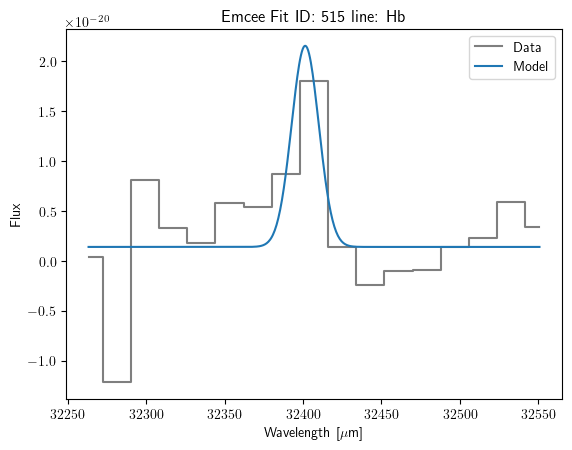

Minimization Guesses
A: 1.469663076512205e-20
mu: 34267.82680382422
sigma: 18.02626198426151
b: 9.915073711495992e-22



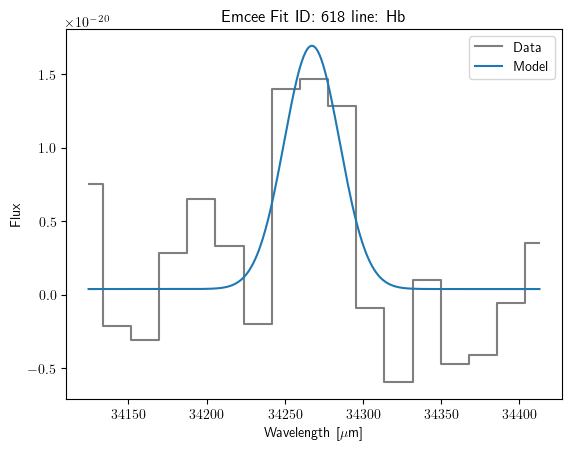

Minimization Guesses
A: 5.192924461797191e-21
mu: 32413.083320183563
sigma: 9.010854359290533
b: 1.6259315580446982e-21



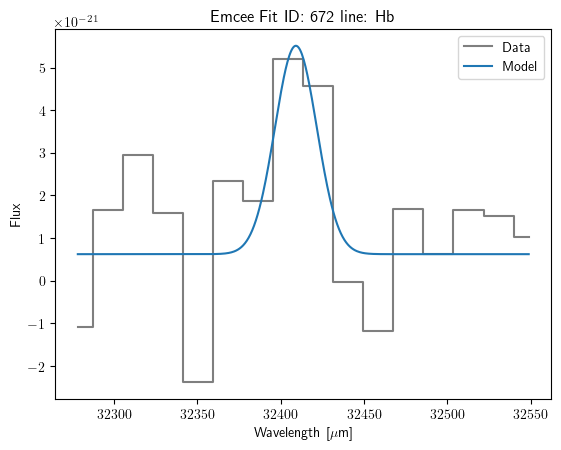

Minimization Guesses
A: 1.4059798534127958e-20
mu: 28665.27516350971
sigma: 8.506160575190734
b: 4.23773663001198e-21



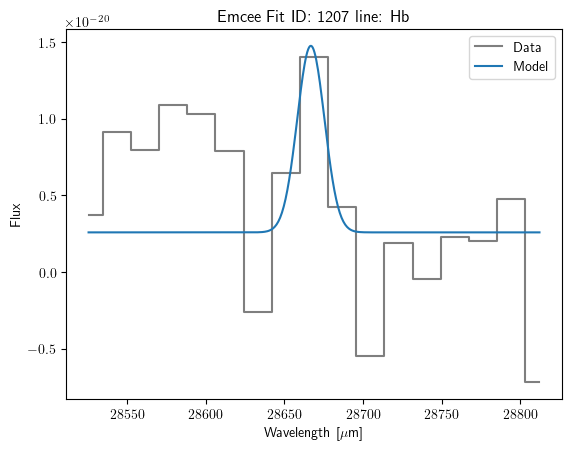

Minimization Guesses
A: 1.672732249686885e-20
mu: 25655.943265181577
sigma: 14.040411968271655
b: 2.2348534126238133e-21



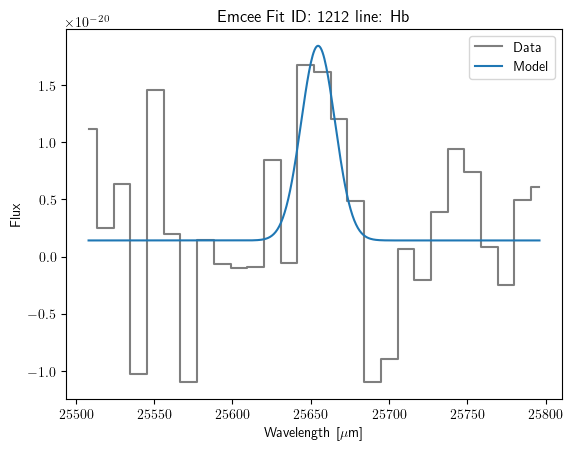

Minimization Guesses
A: 3.458275525529729e-20
mu: 28593.573357440368
sigma: 8.973784609655922
b: 3.972588832238054e-21



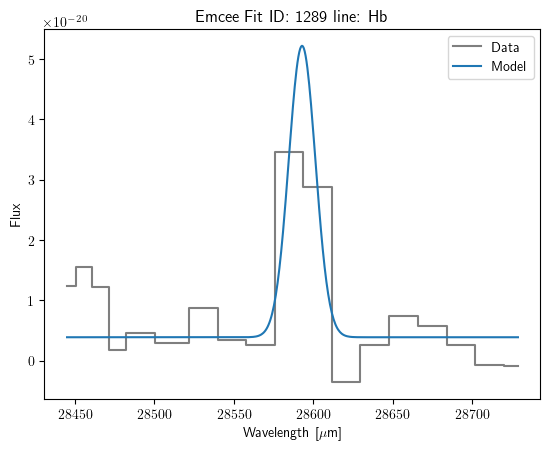

Minimization Guesses
A: 2.526988414051299e-19
mu: 29175.444329840255
sigma: 8.97417855866297
b: 1.812046497466174e-20



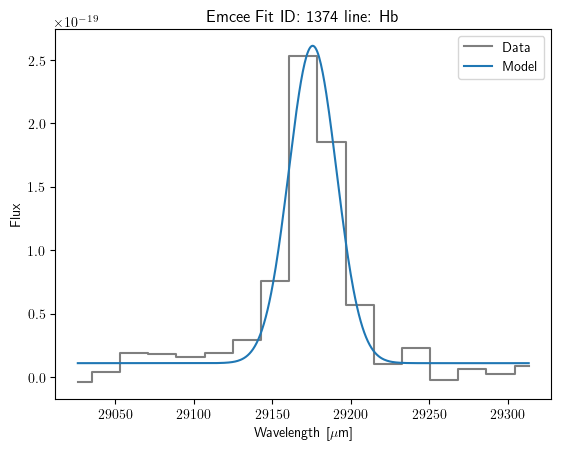

Minimization Guesses
A: 1.6222681140028919e-19
mu: 10669.371804844332
sigma: 14.893805193474691
b: 7.816359170664416e-20



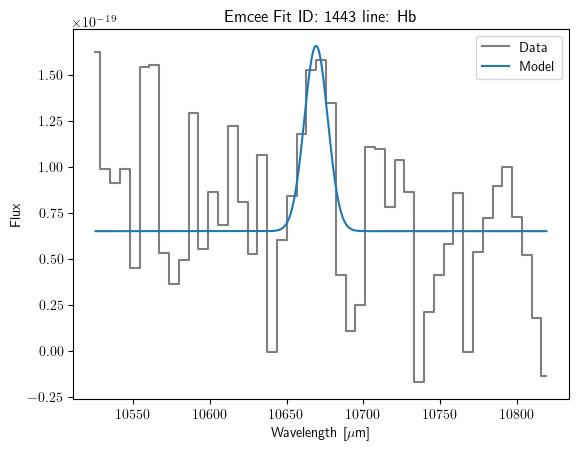

Minimization Guesses
A: 1.9790086227412263e-19
mu: 12106.626172337721
sigma: 5.490407418568793
b: 5.681634948525458e-20



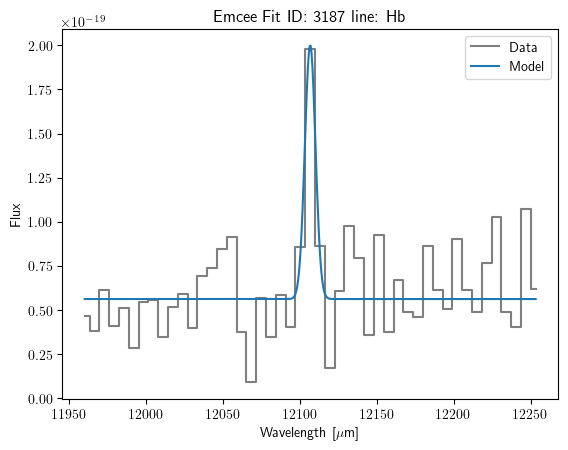

Minimization Guesses
A: 1.1427256233880657e-18
mu: 16023.256552493942
sigma: 8.704073392143073
b: 7.371219538346054e-20



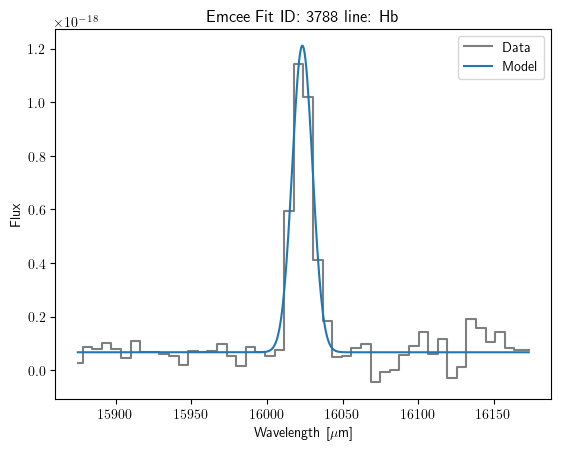

Minimization Guesses
A: 1.1886083524050094e-19
mu: 14210.200922806598
sigma: 10.664153491668003
b: 3.891340360764643e-20



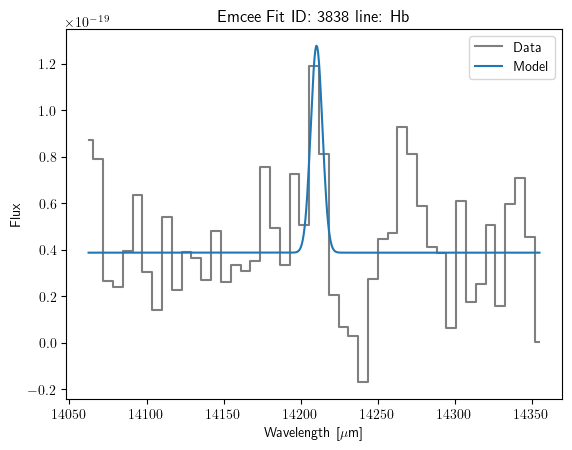

Minimization Guesses
A: 7.237000563711694e-20
mu: 15282.839620071767
sigma: 3.2748433124506846
b: 2.4751285448096143e-21



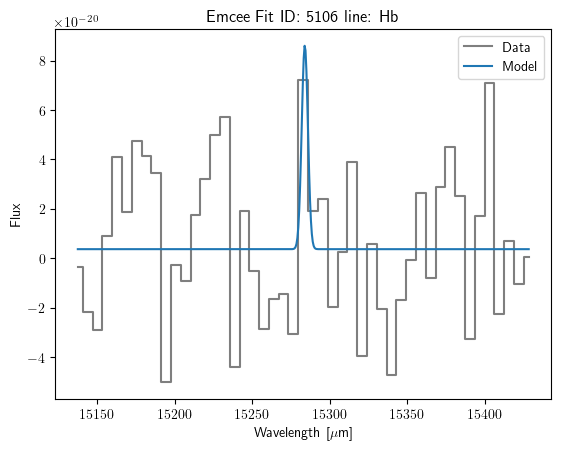

Minimization Guesses
A: 1.6028182066650468e-19
mu: 19972.936505985454
sigma: 12.070291027976054
b: 1.4321901505820452e-20



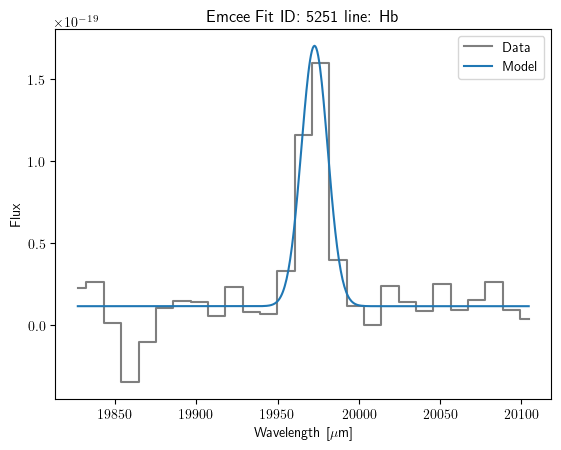

Minimization Guesses
A: 2.9198292413400027e-19
mu: 15251.255813597454
sigma: 7.926234021646451
b: 4.1467867999061344e-20



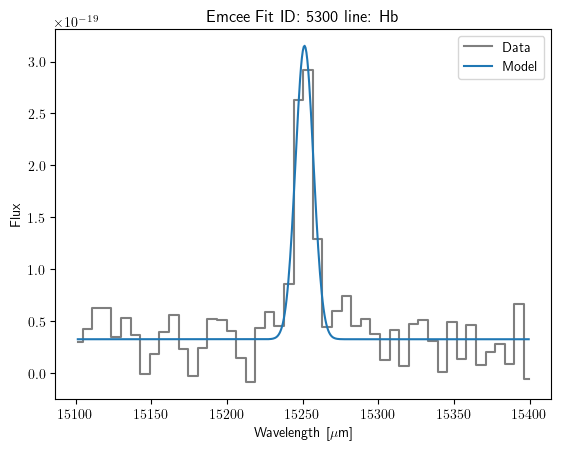

Minimization Guesses
A: 8.677523822423654e-20
mu: 13207.574313485575
sigma: 10.405499151294862
b: 3.415179964193267e-20



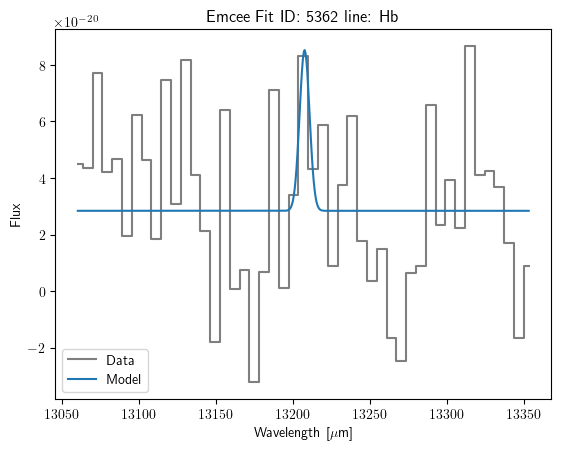

Minimization Guesses
A: 5.064919953956742e-19
mu: 13125.393575928201
sigma: 10.571411083762541
b: 1.3996597536772017e-19



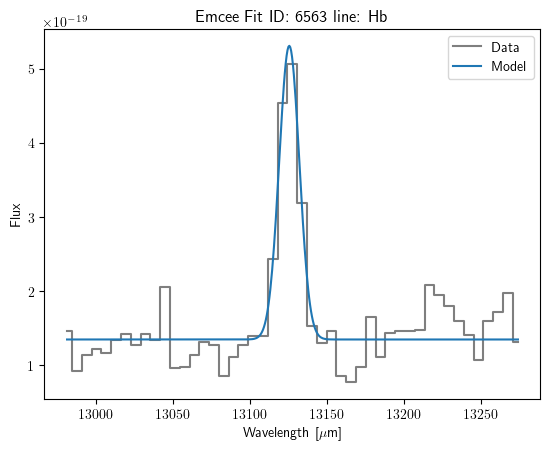

Minimization Guesses
A: 1.3322846285116042e-19
mu: 16220.239563707935
sigma: 10.027662370396683
b: 3.0631987157786356e-20



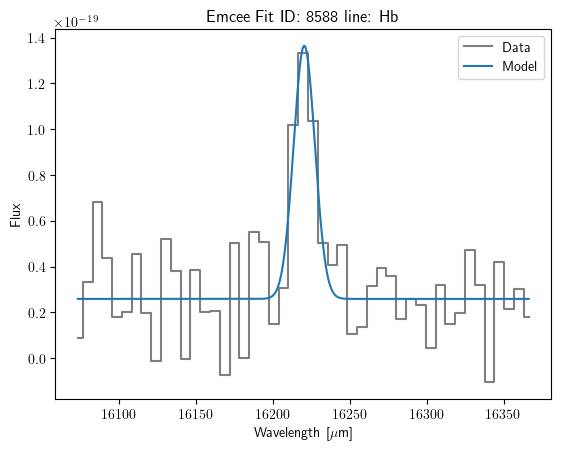

Minimization Guesses
A: 2.4098938322314847e-19
mu: 16223.179725455595
sigma: 9.383429297807197
b: 2.7853245562759645e-20



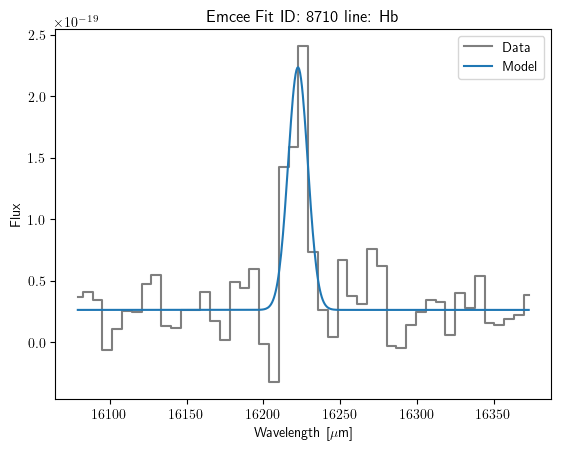

Minimization Guesses
A: 3.0662723410773335e-19
mu: 12419.948340860263
sigma: 8.297700752500532
b: 9.25366177493306e-20



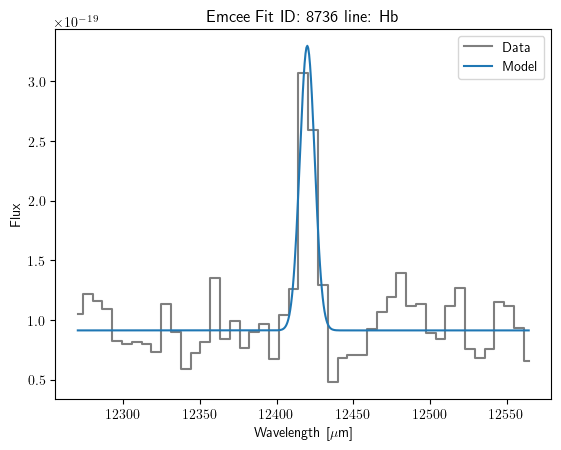

Minimization Guesses
A: 4.1394419669317705e-19
mu: 20918.791170147473
sigma: 12.706942417911705
b: 2.242183453521732e-20



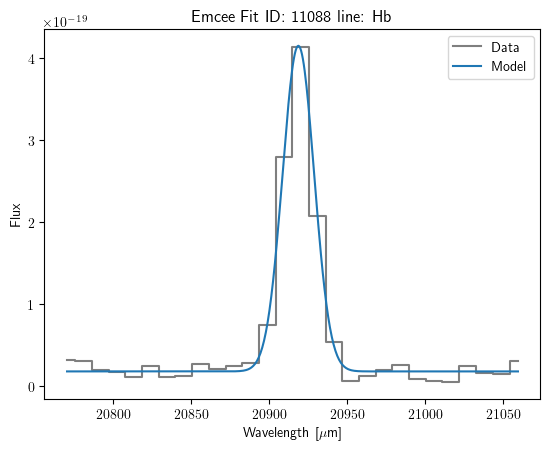

Minimization Guesses
A: 4.044964353571168e-20
mu: 20559.691644378738
sigma: 11.162697533565733
b: 9.492528600941005e-21



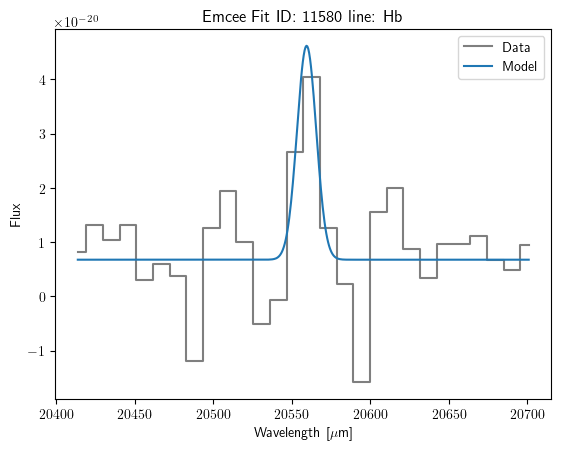

Minimization Guesses
A: 3.479880021631507e-20
mu: 19453.85845670452
sigma: 14.439650695452656
b: 8.686343668826764e-21



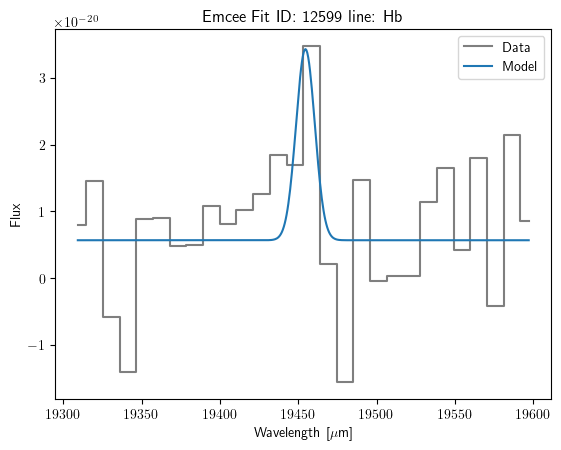

Minimization Guesses
A: 2.9599853073222587e-19
mu: 17214.81607134172
sigma: 9.632600470720718
b: 1.6686314714749256e-20



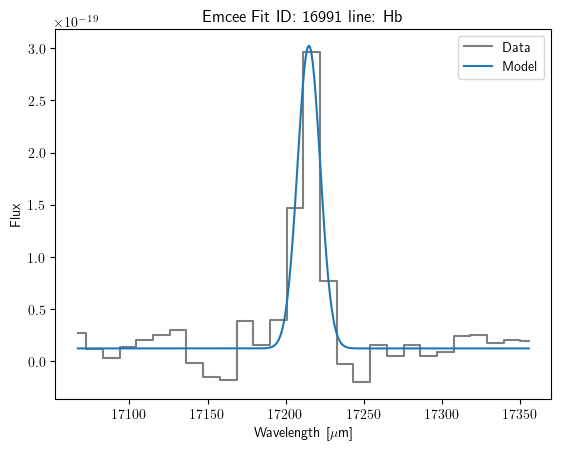

Minimization Guesses
A: 1.549912199176597e-19
mu: 14637.800842212931
sigma: 6.3814647074596
b: 1.3303632199149621e-20



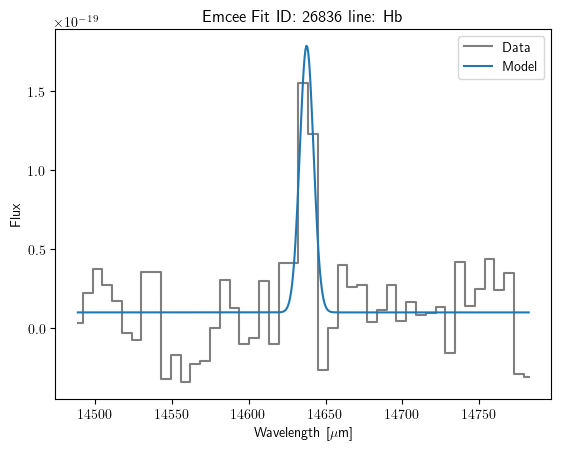

Minimization Guesses
A: 6.172639437101515e-20
mu: 13038.371020469183
sigma: 9.96097001175076
b: 2.4582890304564278e-20



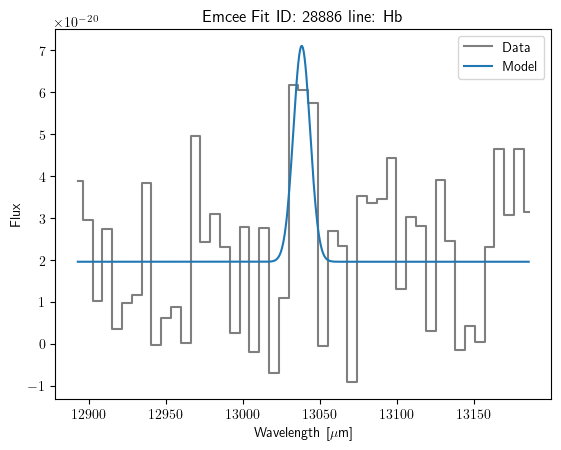

Minimization Guesses
A: 7.989967266849665e-20
mu: 14159.705775072274
sigma: 8.022640446144578
b: 2.121365591747753e-20



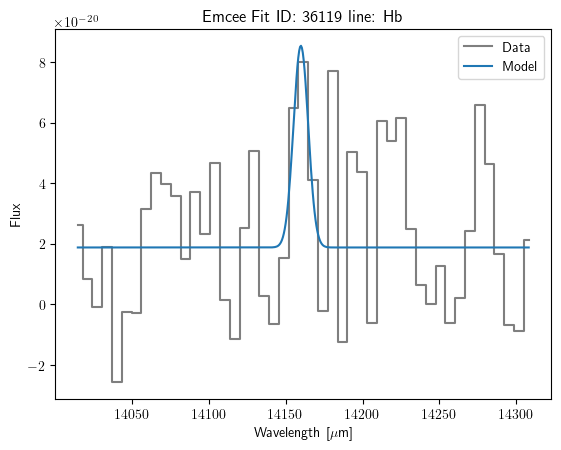

Minimization Guesses
A: 6.551669718187389e-20
mu: 32413.934440499157
sigma: 16.658433880102166
b: 1.2775779109619114e-21



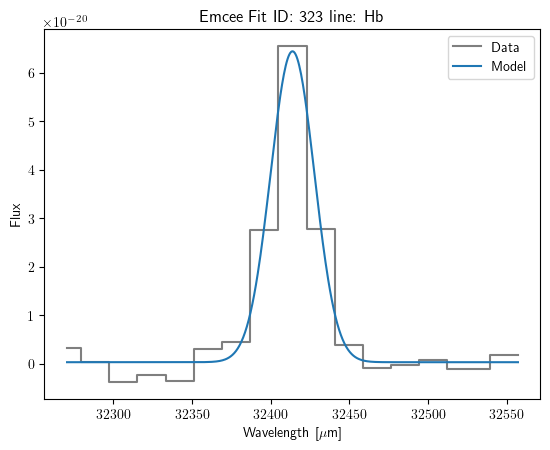

Minimization Guesses
A: 4.154359996463067e-20
mu: 34520.73928152889
sigma: 8.537934447977023
b: 3.6634852905529854e-21



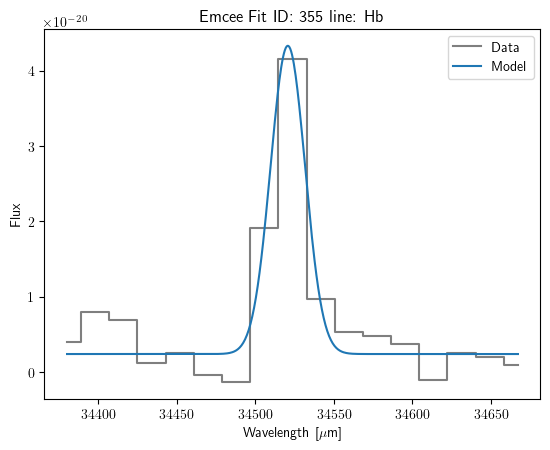

Minimization Guesses
A: 1.855601551558788e-20
mu: 31642.696557932606
sigma: 5.06888522288682
b: 6.438868138622605e-21



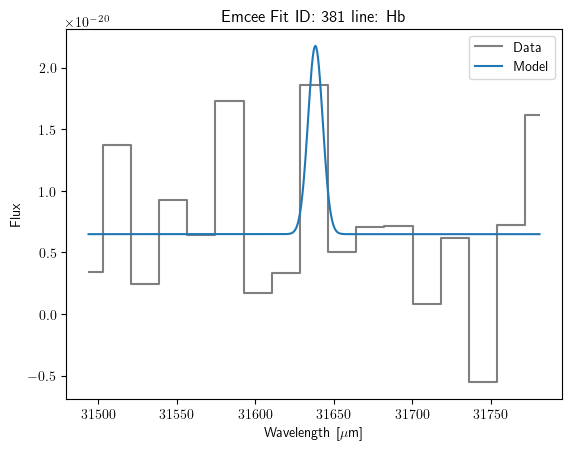

Minimization Guesses
A: 1.0478510494186296e-20
mu: 37046.986059525734
sigma: 8.945311923482222
b: 1.801509108456406e-21



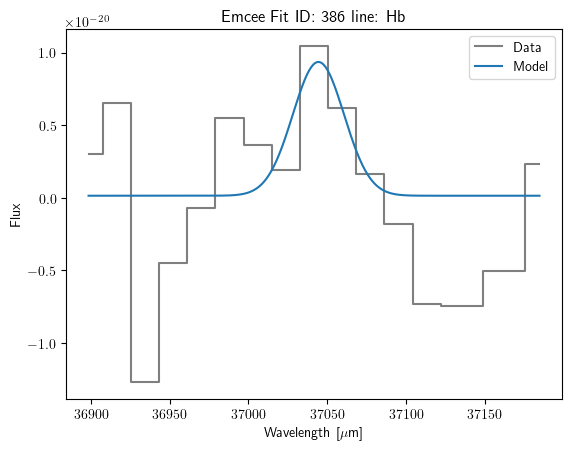

Minimization Guesses
A: 1.3904873183952915e-19
mu: 34041.74820663525
sigma: 8.956191684581427
b: 6.662986913131154e-21



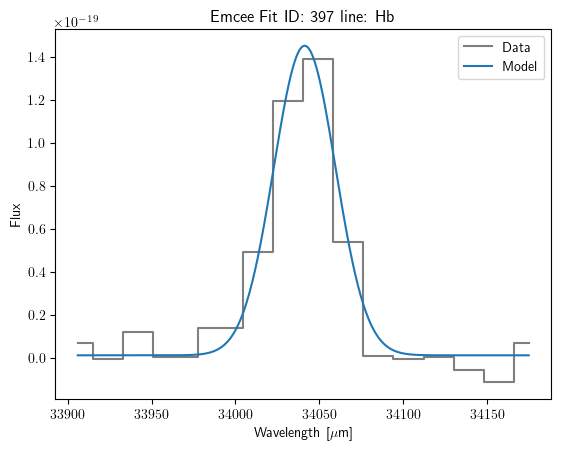

Minimization Guesses
A: 3.598056768812598e-20
mu: 32878.244425887686
sigma: 8.973016999007086
b: 4.3650388697934734e-21



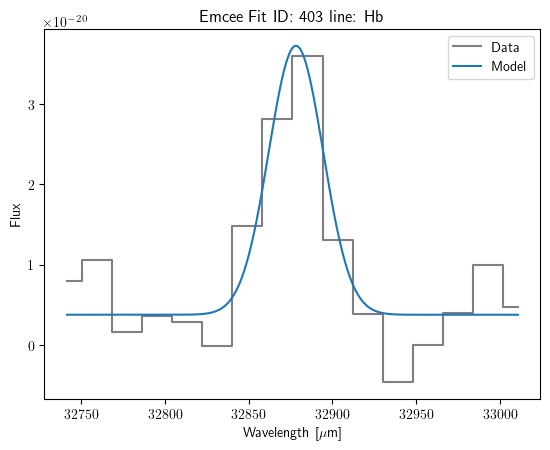

Minimization Guesses
A: 7.9441085266043e-21
mu: 32317.92818959795
sigma: 9.011082501321653
b: 2.049299521035585e-22



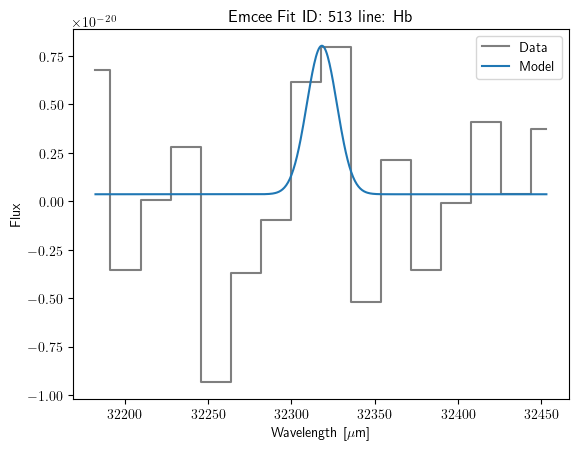

Minimization Guesses
A: 2.9019458613693106e-20
mu: 34315.0839160813
sigma: 8.98169215704911
b: 4.605666922522516e-21



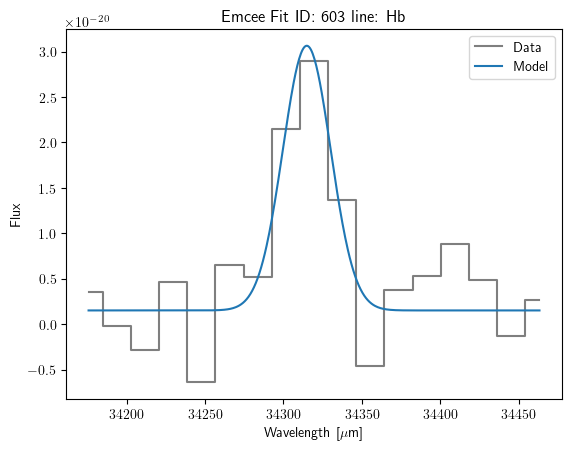

Minimization Guesses
A: 1.2217142506590108e-20
mu: 32202.32039301496
sigma: 16.115005297528114
b: 3.557192024214555e-21



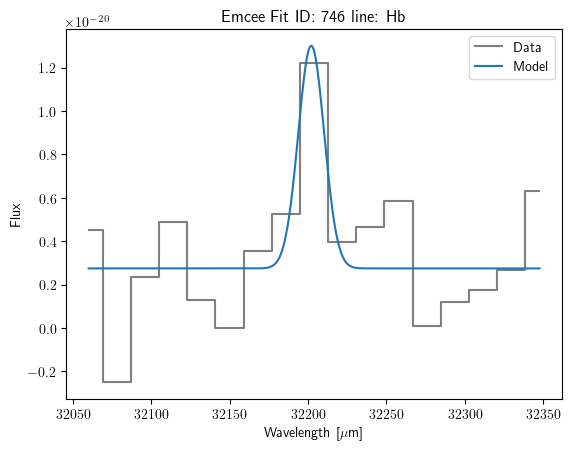

Minimization Guesses
A: 1.5833844191038923e-20
mu: 35290.9518443828
sigma: 8.978403026114393
b: 2.7441376561720435e-21



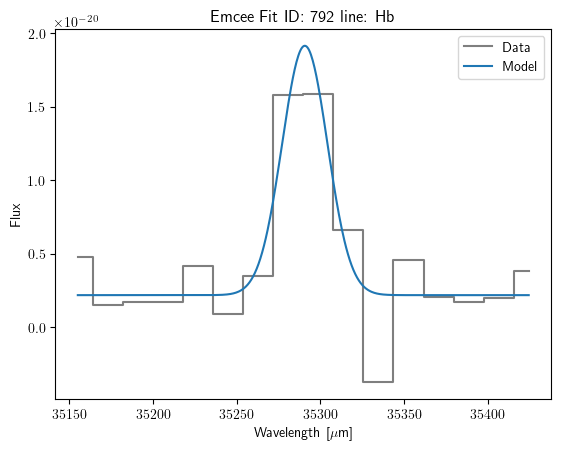

Minimization Guesses
A: 2.5105847013451914e-20
mu: 30476.433241762013
sigma: 8.924232538129218
b: 3.038168055855668e-21



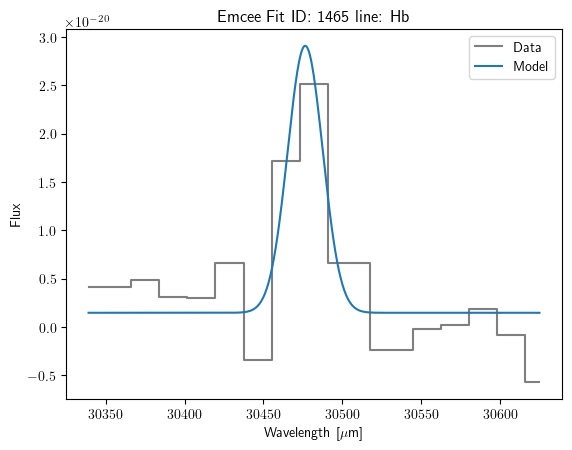

Minimization Guesses
A: 2.78684984466249e-20
mu: 21616.430686186526
sigma: 8.968015238238877
b: 5.1491469611278785e-21



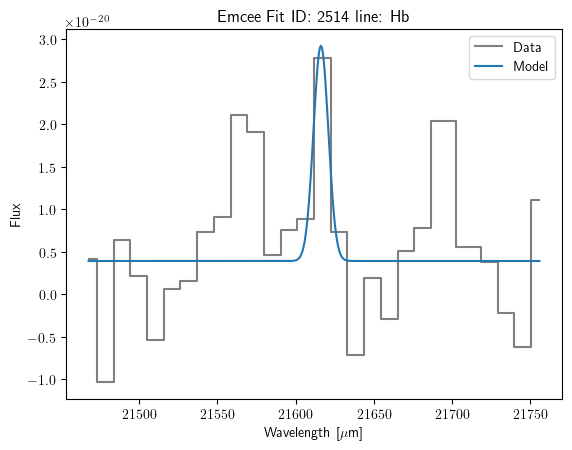

Minimization Guesses
A: 5.1874028435012216e-20
mu: 30345.956757258467
sigma: 9.007334310157603
b: 2.1330573724261427e-21



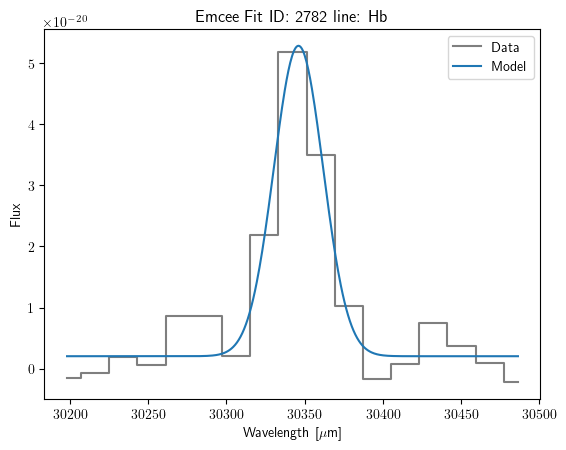

Minimization Guesses
A: 1.0900267449412536e-19
mu: 20914.67692128316
sigma: 14.493995203614759
b: 1.4023739342025923e-20



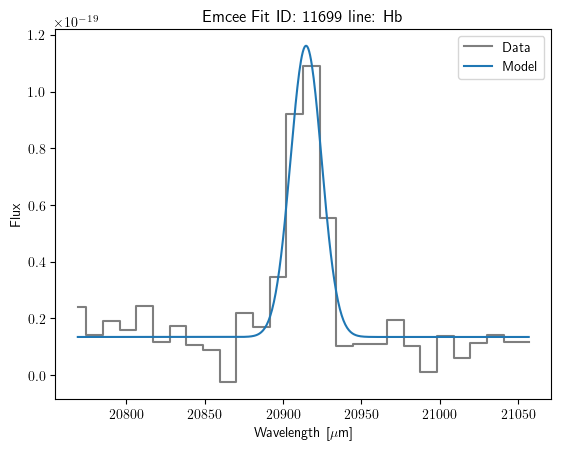

Minimization Guesses
A: 4.4339303766926e-20
mu: 23717.36478149842
sigma: 7.760227163356831
b: 6.041256225057149e-21



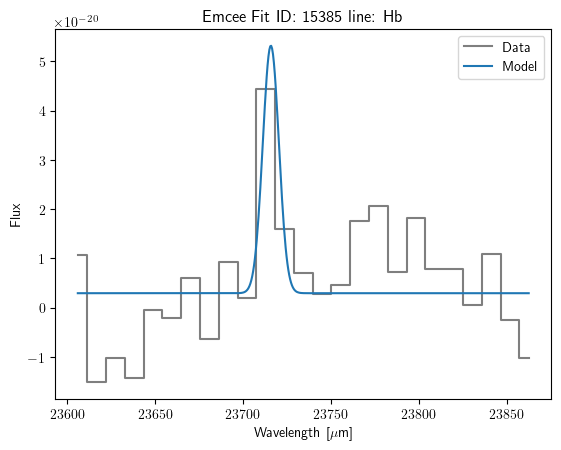

Minimization Guesses
A: 1.1303862117319578e-19
mu: 27380.163590445274
sigma: 12.016601664276095
b: 3.857325239320978e-21



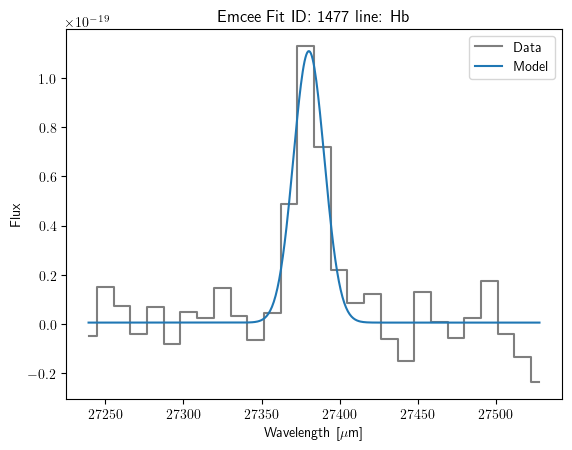

Minimization Guesses
A: 2.4943390601783367e-20
mu: 26716.239337608833
sigma: 12.110185376111986
b: 8.021032698317285e-22



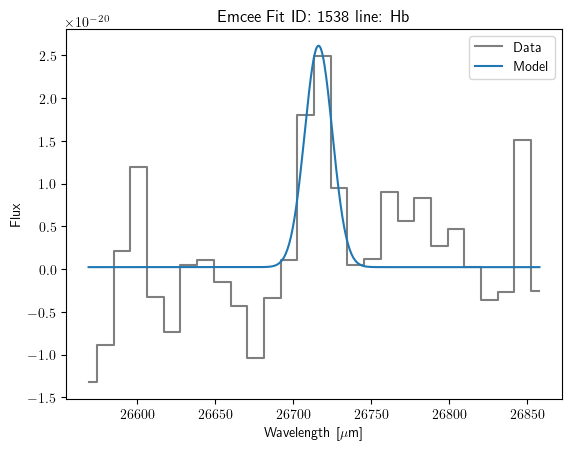

Minimization Guesses
A: 1.0404021151290412e-19
mu: 27036.86388315013
sigma: 12.971777805068996
b: 5.735105554901906e-21



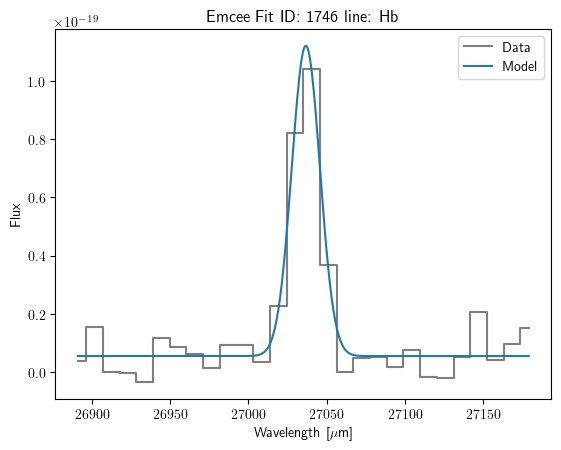

Minimization Guesses
A: 1.2379220055379076e-20
mu: 26757.142271011813
sigma: 14.588970140352103
b: 2.4790350131679344e-21



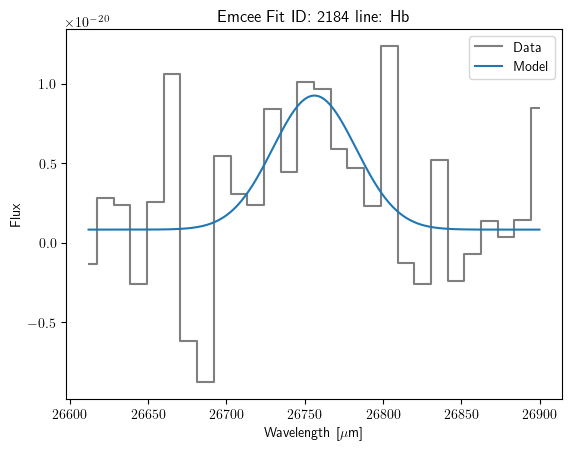

Minimization Guesses
A: 4.6389439306778417e-20
mu: 21741.154312896168
sigma: 12.40082508859632
b: 7.160567561248251e-21



Minimization Guesses
A: 9.684005681723571e-20
mu: 23663.611596161176
sigma: 10.14118753101684
b: -1.5633330804876283e-21



Minimization Guesses
A: 3.9565975123920317e-19
mu: 10038.211756532775
sigma: 13.782746920175668
b: 1.302177283446139e-19



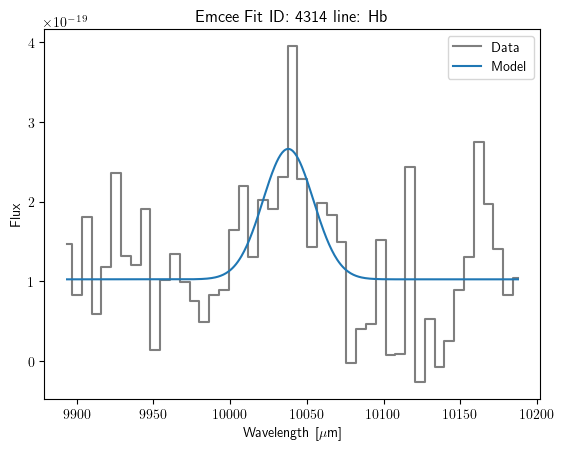

Minimization Guesses
A: 1.468995589068935e-19
mu: 21052.514430278192
sigma: 13.7488804449913
b: 2.0330105388401358e-20



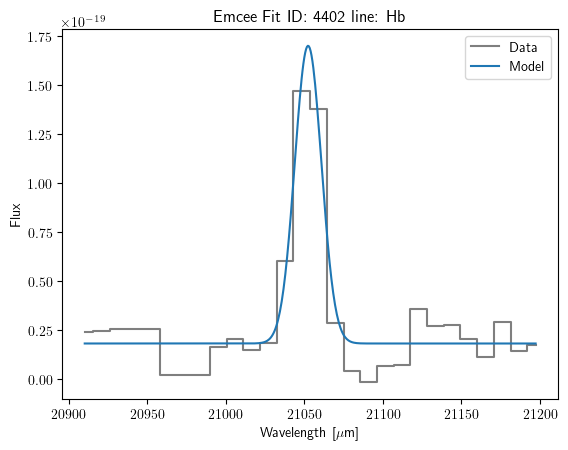

Minimization Guesses
A: 1.6057220388868453e-19
mu: 12511.31105288463
sigma: 6.885561766112005
b: 3.6810992427109816e-20



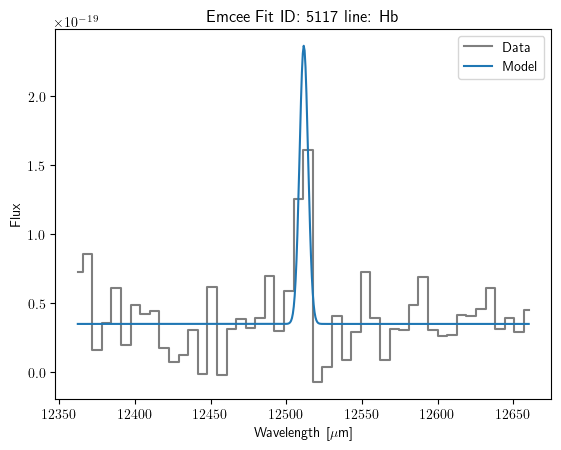

Minimization Guesses
A: 1.9103350399776943e-19
mu: 11613.994162454866
sigma: 14.566254134079827
b: 7.727135150901878e-20



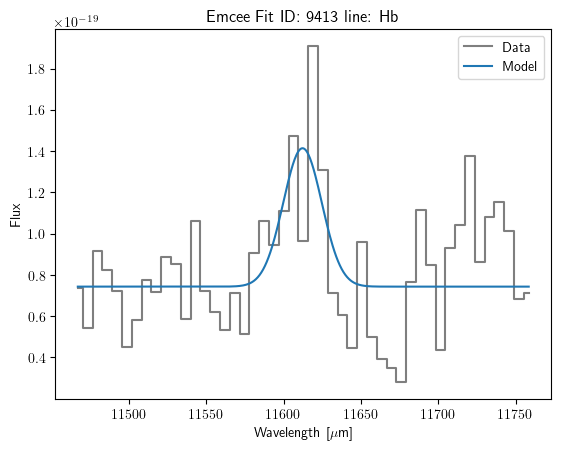

Minimization Guesses
A: 4.34694637328887e-19
mu: 13012.729280453814
sigma: 8.967875635367818
b: 1.8017113633164484e-19



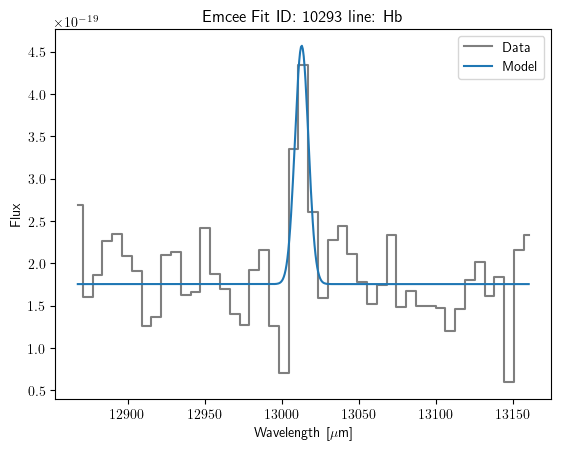

Minimization Guesses
A: 7.79576131761251e-20
mu: 21045.470046008566
sigma: 11.810363649723513
b: 1.3026656314152423e-20



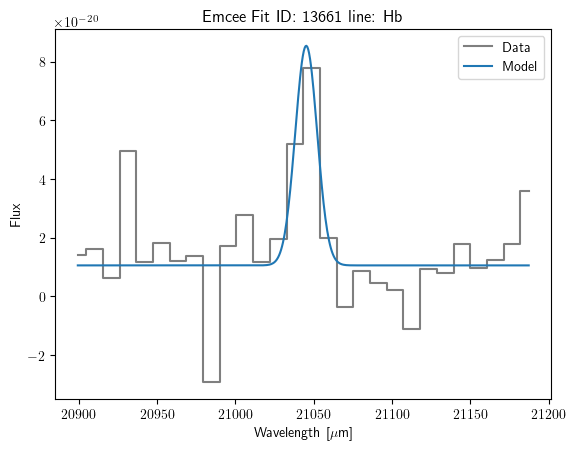

Minimization Guesses
A: 2.2904592074500545e-20
mu: 24858.696307054794
sigma: 12.813007445320181
b: 2.3377267642830225e-21



Minimization Guesses
A: 9.352877153248115e-20
mu: 18056.26824787976
sigma: 10.666905971673259
b: 1.8953354726407494e-20



Minimization Guesses
A: 7.141575416564877e-20
mu: 14237.388929362154
sigma: 11.13445939968824
b: 1.3411024464082591e-20



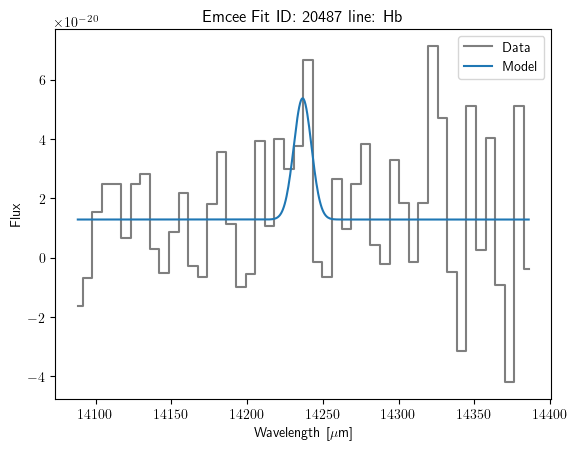

Minimization Guesses
A: 7.610264851650902e-19
mu: 11102.63951743462
sigma: 4.842670126034136
b: 2.4875975927188566e-20



Minimization Guesses
A: 5.594487191430189e-20
mu: 35499.45997845921
sigma: 8.951554870440305
b: 9.583744880341166e-21



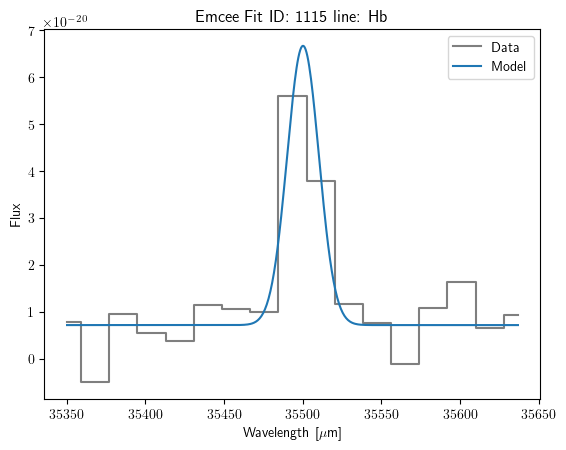

Minimization Guesses
A: 1.968965256633222e-20
mu: 29913.103077314827
sigma: 8.977492401401832
b: 3.526001428811674e-21



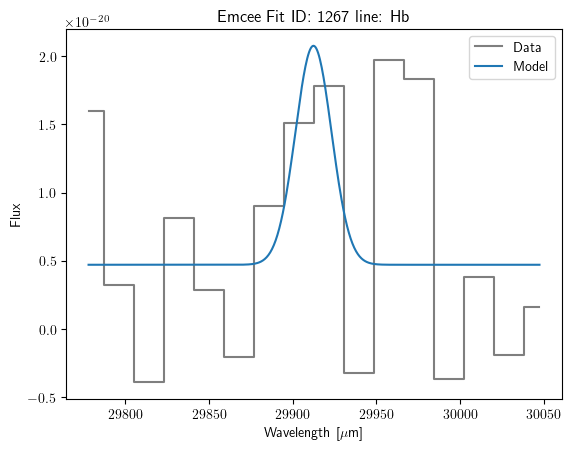

Minimization Guesses
A: 6.227311498667556e-20
mu: 30996.3979946616
sigma: 8.928251043538694
b: 9.463968859965778e-21



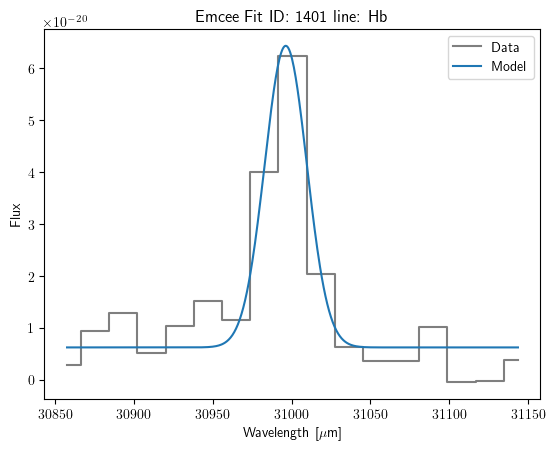

Minimization Guesses
A: 3.071021645390273e-20
mu: 30423.17384104432
sigma: 8.950557110711088
b: 3.722165184070074e-21



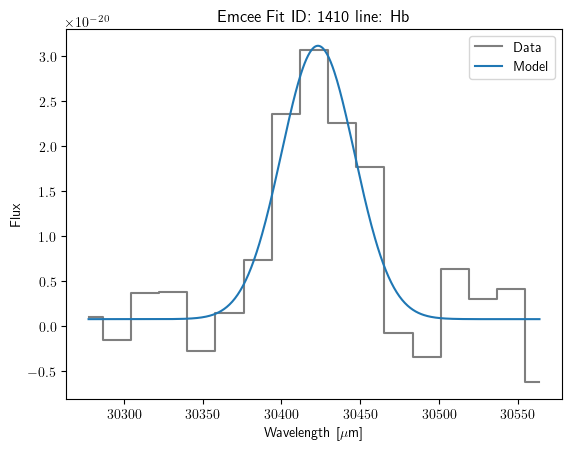

Minimization Guesses
A: 5.48737369355598e-20
mu: 34989.42474532176
sigma: 8.956150129026355
b: 5.092681530832855e-21



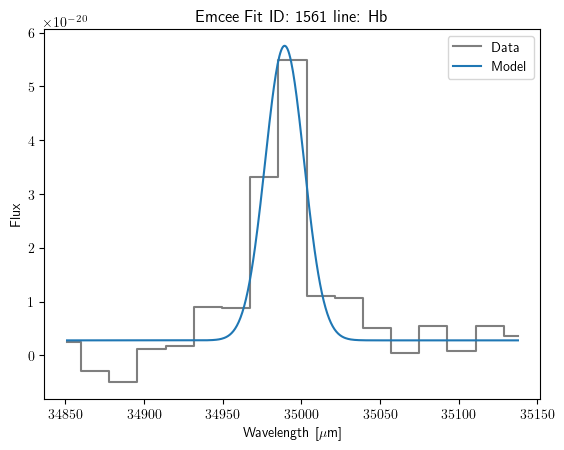

Minimization Guesses
A: 3.29681025528645e-19
mu: 26659.87855583913
sigma: 10.637512572957348
b: 2.197286869433639e-20



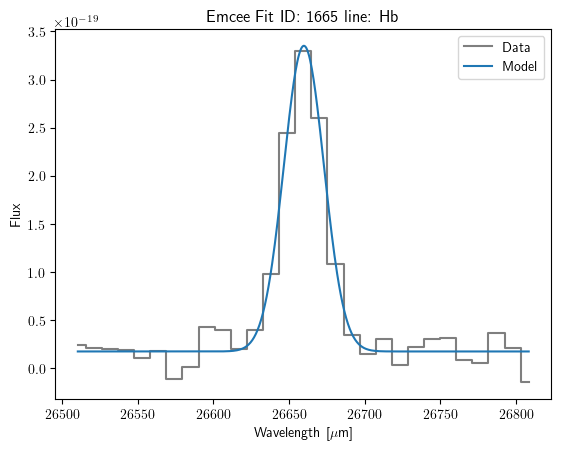

Minimization Guesses
A: 1.459983306903797e-20
mu: 33391.3729019183
sigma: 17.922245006357116
b: 1.8420274615837935e-21



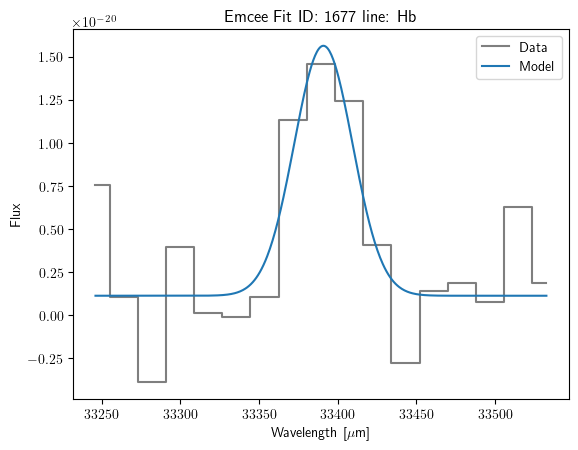

Minimization Guesses
A: 3.648890652854073e-20
mu: 29333.61029629115
sigma: 7.775330796610433
b: 3.904491783539189e-21



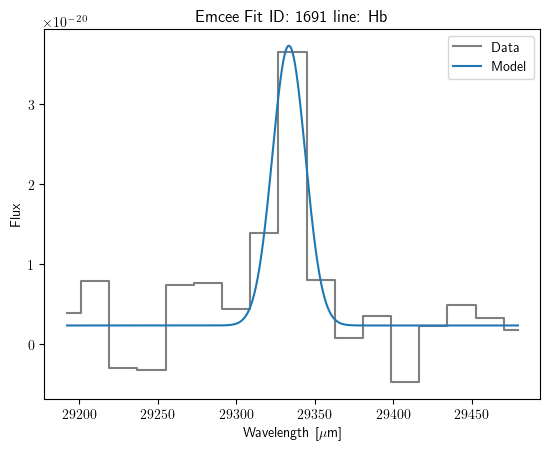

Minimization Guesses
A: 1.0243921904743219e-19
mu: 27516.654339969617
sigma: 14.711114735511728
b: 1.644315249412037e-20



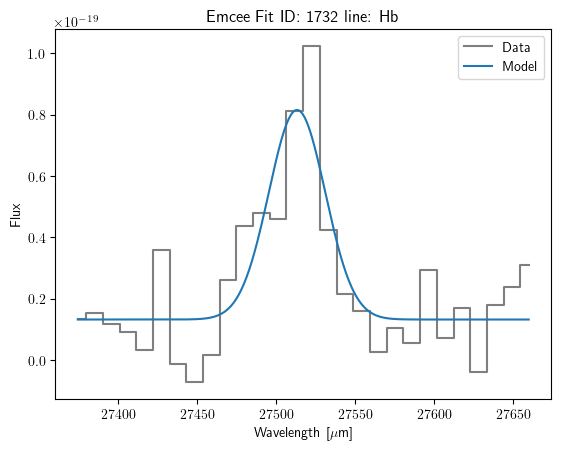

Minimization Guesses
A: 6.646292945591474e-18
mu: 14858.867045038767
sigma: 6.022333829448144
b: 9.403167916314513e-20



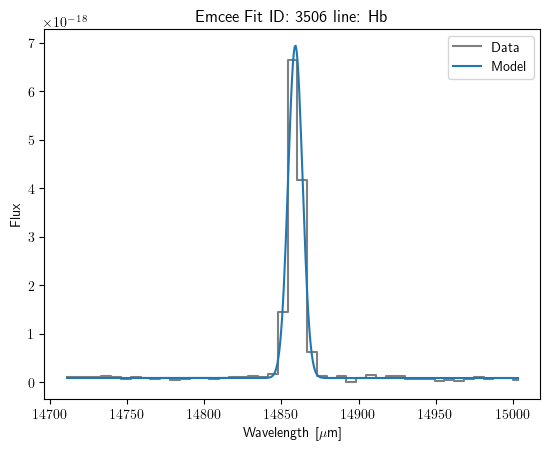

Minimization Guesses
A: 5.206357698010073e-20
mu: 27542.266565101552
sigma: 10.623981845161325
b: 7.780131745905987e-21



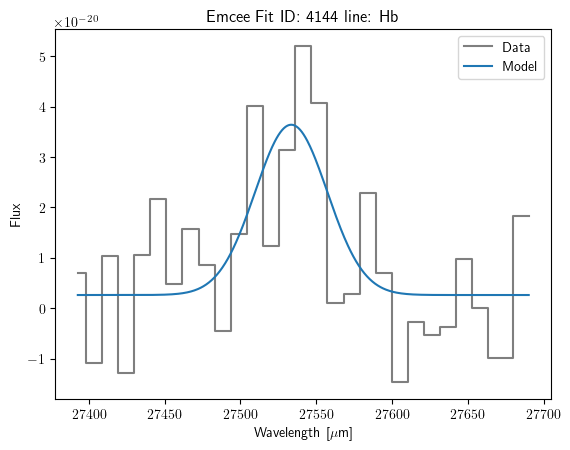

Minimization Guesses
A: 6.322811998238534e-20
mu: 30416.510717126916
sigma: 13.537406499423014
b: 7.663495536456534e-21



Minimization Guesses
A: 1.0031554007824447e-19
mu: 21503.871490539525
sigma: 10.659623337021912
b: 8.815641228348643e-21



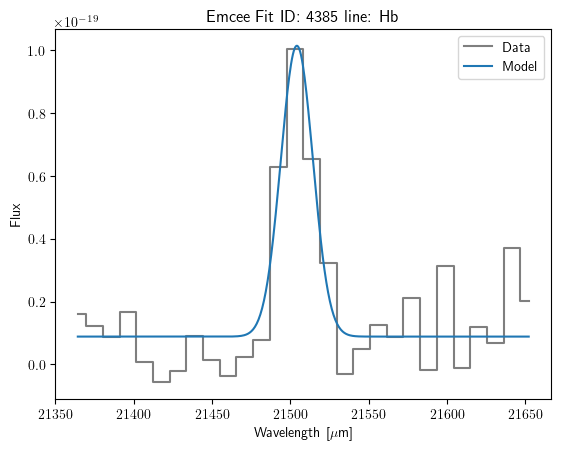

Minimization Guesses
A: 1.3563695309269786e-19
mu: 14106.09429712924
sigma: 11.730983642889441
b: 5.2698456653325374e-20



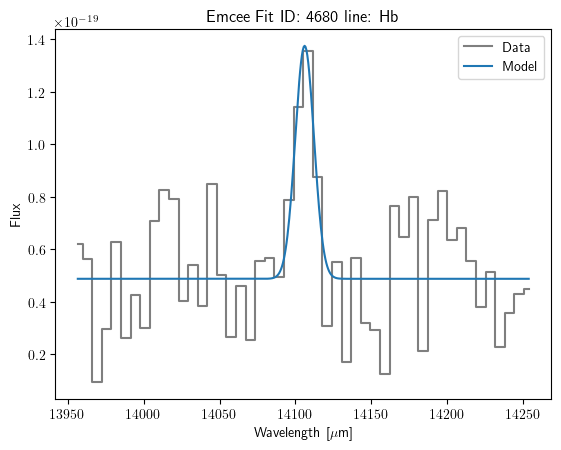

Minimization Guesses
A: 7.370272608546556e-19
mu: 13058.636111682119
sigma: 8.455327086389843
b: 1.8513897325237193e-19



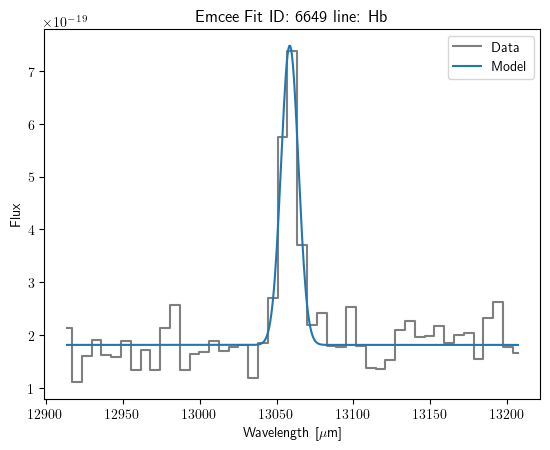

Minimization Guesses
A: 7.967181770390557e-19
mu: 12513.743756436766
sigma: 7.927147945850265
b: 1.613199031654975e-19



Minimization Guesses
A: 8.692685495141232e-19
mu: 12795.388766749786
sigma: 7.095323619610099
b: 7.771361560067703e-20



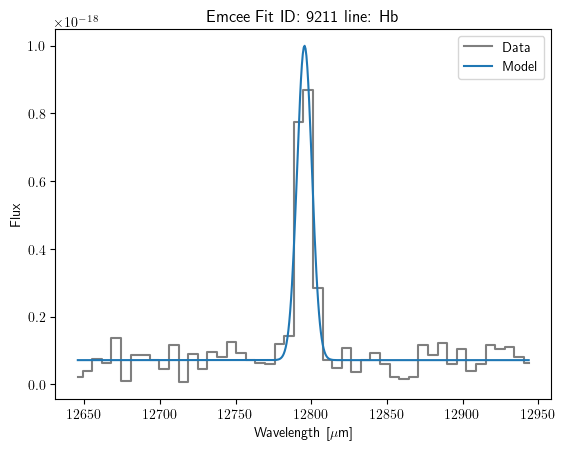

Minimization Guesses
A: 3.7266277577877077e-20
mu: 19973.422405789166
sigma: 14.09496814069098
b: 5.940418966436817e-21



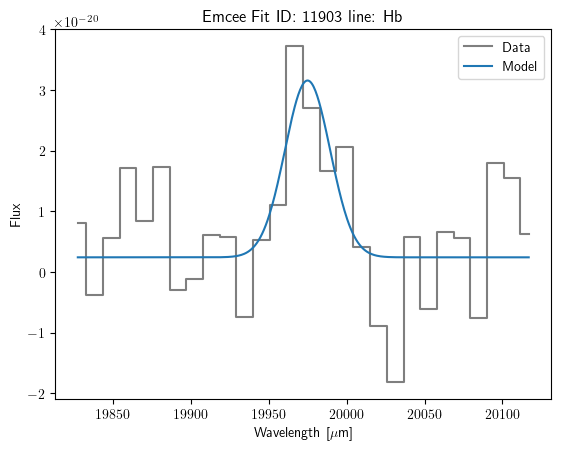

Minimization Guesses
A: 6.098960731716694e-20
mu: 21140.198949084886
sigma: 12.346752468591148
b: 3.7880664606090895e-21



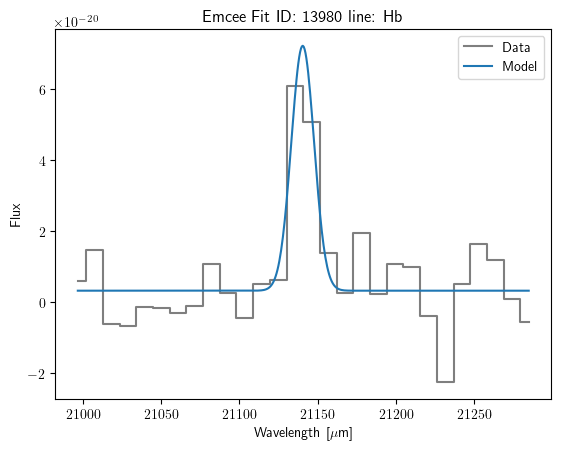

Minimization Guesses
A: 2.6803423731579296e-19
mu: 11347.107904186183
sigma: 6.118454774641577
b: 1.6284289022413172e-20



Minimization Guesses
A: 9.500451113087145e-20
mu: 12614.781793324808
sigma: 16.314490069734347
b: 4.0820846160960025e-20



Minimization Guesses
A: 4.518944663710659e-20
mu: 29156.238610390334
sigma: 9.174892140492375
b: 4.644556064562905e-21



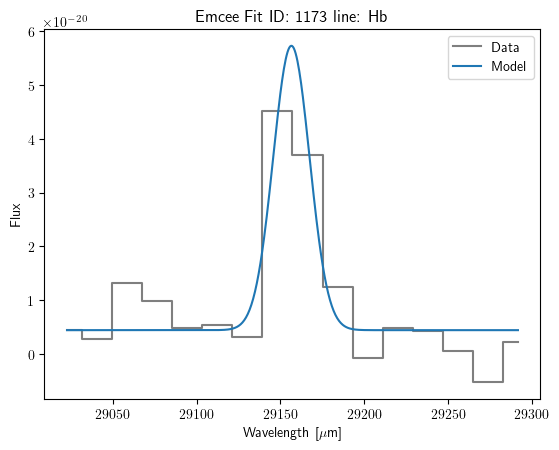

Minimization Guesses
A: 2.6219019511486506e-20
mu: 26660.34155917973
sigma: 15.42452015062372
b: 4.269584199125938e-21



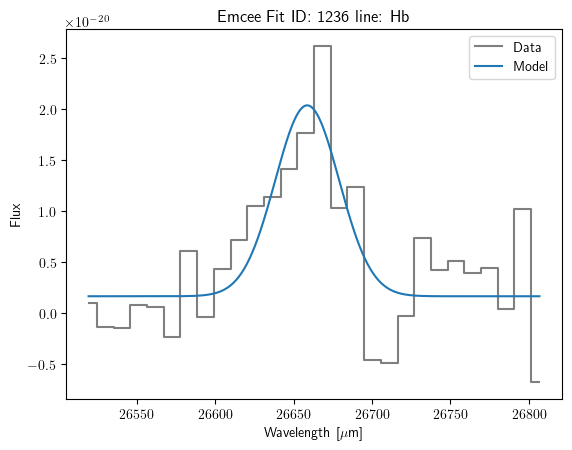

Minimization Guesses
A: 2.792478909397966e-20
mu: 31625.45628572538
sigma: 9.00166773932142
b: 4.614370264265907e-21



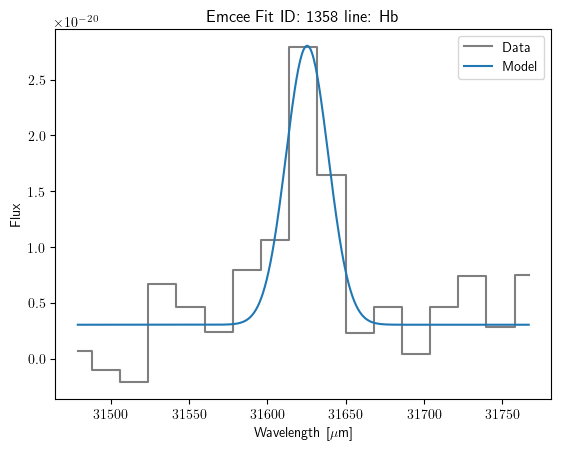

Minimization Guesses
A: 3.431342254934891e-20
mu: 30589.49917681964
sigma: 9.001638212655962
b: 2.4351004378885332e-21



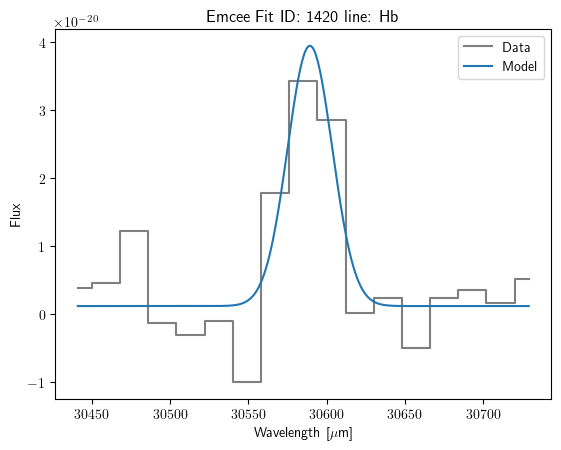

Minimization Guesses
A: 1.9593717233276703e-19
mu: 27969.596529561924
sigma: 14.617729056417375
b: 9.405279082662015e-21



Minimization Guesses
A: 3.8357158849649947e-20
mu: 25235.852973190908
sigma: 14.358376035272158
b: -3.678913499696068e-21



Minimization Guesses
A: 6.146465514936473e-20
mu: 27378.78308237585
sigma: 11.29803511029968
b: 6.5191763335987135e-21



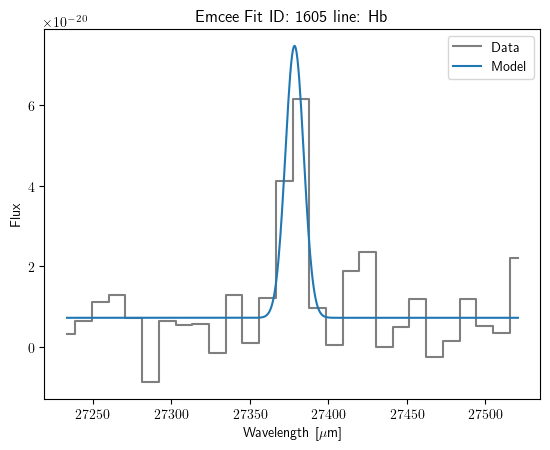

Minimization Guesses
A: 3.4305954675419276e-20
mu: 27382.672550499745
sigma: 10.527393337442845
b: 1.9970078633899227e-21



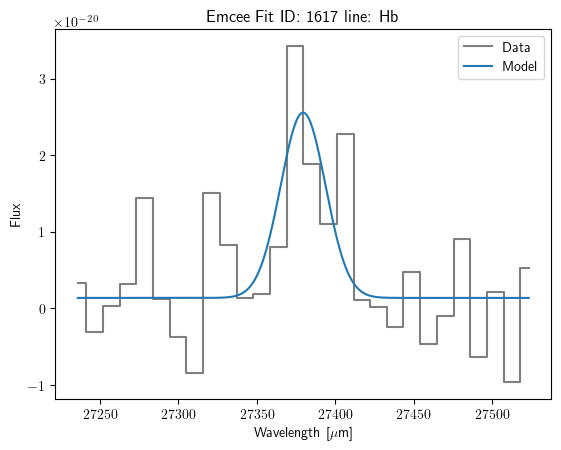

Minimization Guesses
A: 1.534251398789364e-20
mu: 27135.734047709153
sigma: 15.147665231490464
b: 7.683657020317436e-22



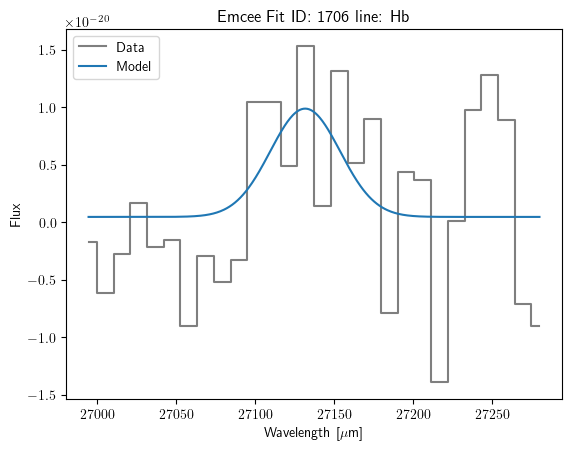

Minimization Guesses
A: 2.8493592912394595e-20
mu: 26596.57331961261
sigma: 7.426883064157664
b: -3.522576792841224e-22



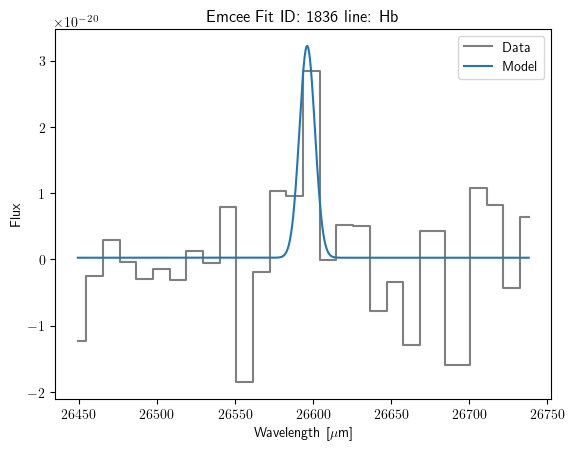

Minimization Guesses
A: 1.7999336158064612e-20
mu: 30688.573941862953
sigma: 17.969771612635668
b: 4.756215274532753e-21



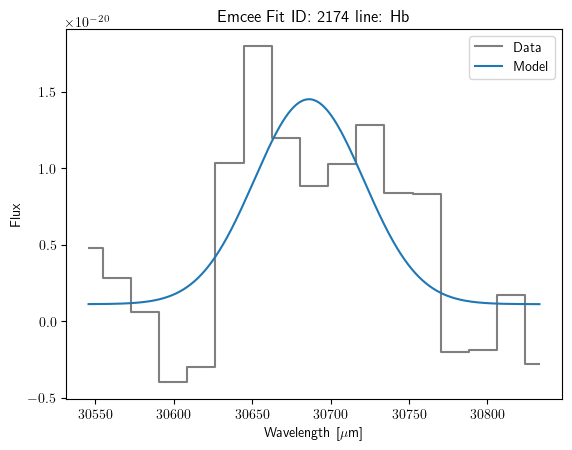

Minimization Guesses
A: 8.7527002340752e-20
mu: 22699.82862957449
sigma: 15.955255163802576
b: 1.9529736145873428e-20



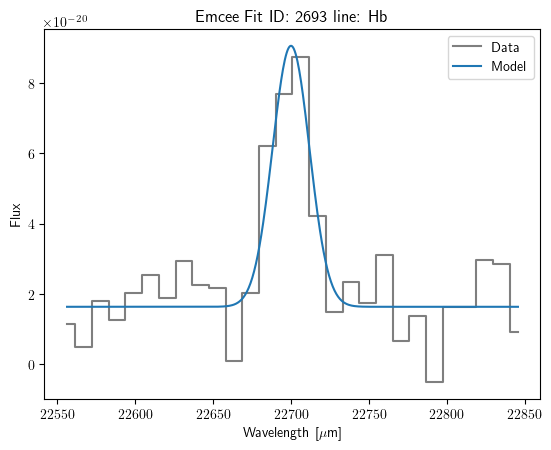

Minimization Guesses
A: 7.839118489430118e-19
mu: 15375.949502050393
sigma: 6.552226401298867
b: 1.3363657951547441e-20



Minimization Guesses
A: 2.303917129226676e-19
mu: 16393.458191645605
sigma: 10.540337080076824
b: 4.7706437584719275e-20



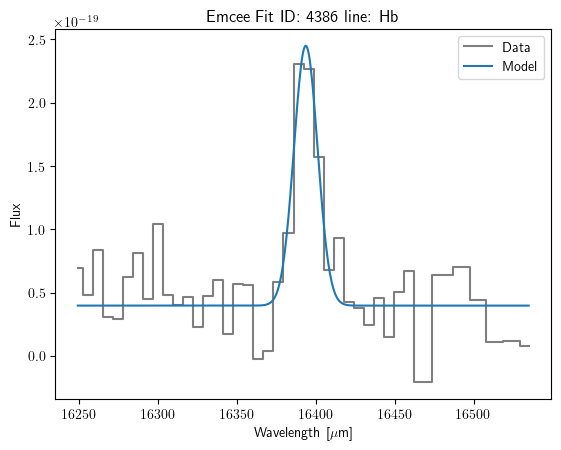

Minimization Guesses
A: 4.185486964619303e-19
mu: 17167.79800889945
sigma: 13.03147875047216
b: 5.416671602812656e-20



Minimization Guesses
A: 1.599737789561052e-18
mu: 12528.795270600493
sigma: 6.328171791962632
b: 1.2649163842448548e-19



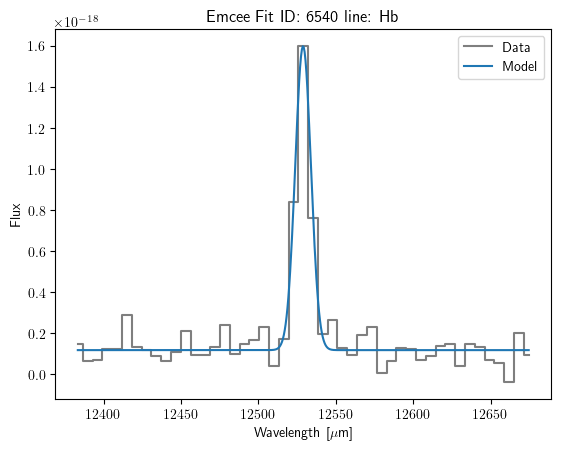

Minimization Guesses
A: 2.176830348127876e-19
mu: 18193.368131840783
sigma: 12.803797829483301
b: 5.0000402141337454e-20



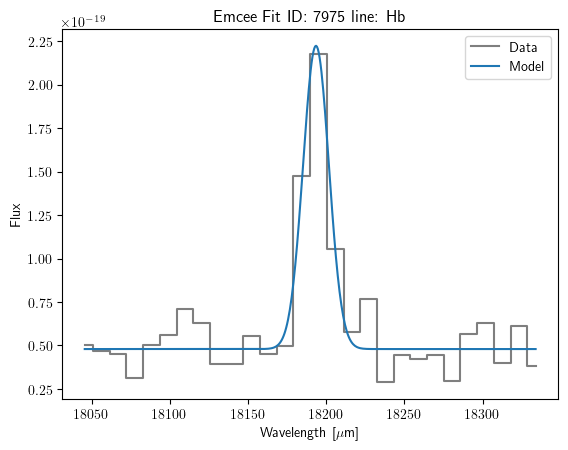

Minimization Guesses
A: 2.526113618657621e-19
mu: 15352.302588983162
sigma: 13.359651573706287
b: 7.581887526711486e-20



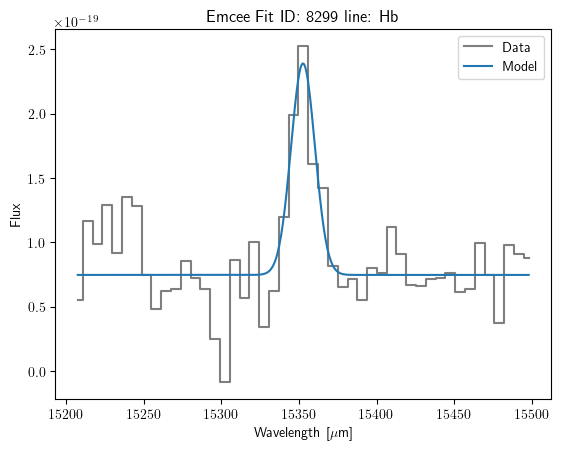

Minimization Guesses
A: 3.549688409453632e-19
mu: 13334.392510389374
sigma: 7.097388251902885
b: 3.7003097228698926e-20



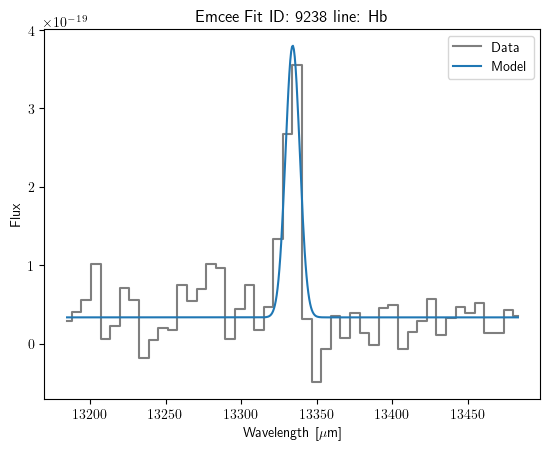

Minimization Guesses
A: 1.7838518010706581e-19
mu: 23676.443784658597
sigma: 10.366795619616823
b: 3.1745870663323794e-21



Minimization Guesses
A: 2.3441136343839908e-20
mu: 25218.146944908814
sigma: 10.657659207778124
b: 2.7390239233398734e-21



Minimization Guesses
A: 1.3585921367235102e-19
mu: 17365.02656546635
sigma: 10.408297407504506
b: -7.496371690864185e-23



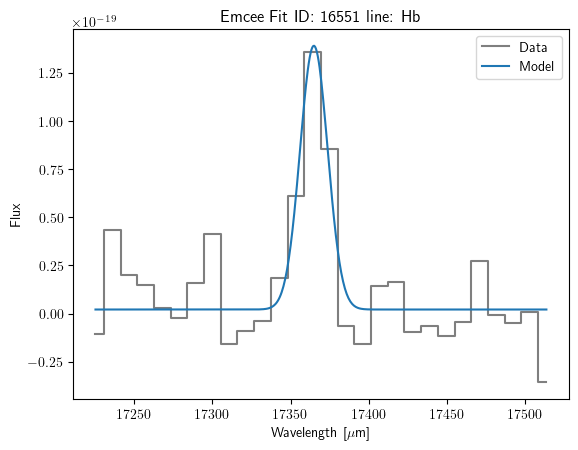

Minimization Guesses
A: 8.369355148696863e-20
mu: 18164.87603558767
sigma: 12.407201782680204
b: 1.2051709419271063e-20



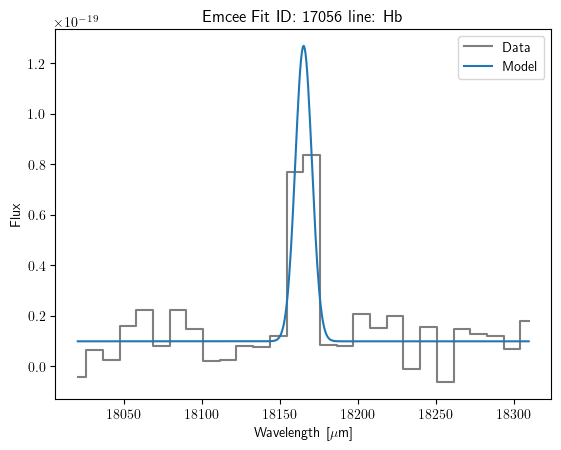

Minimization Guesses
A: 1.1022845265385923e-19
mu: 16057.42851210402
sigma: 8.235281597694666
b: 5.4116288355700864e-21



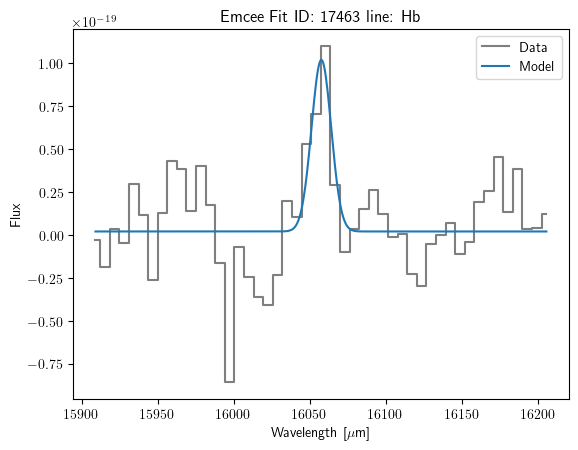

Minimization Guesses
A: 6.826132627103612e-19
mu: 11074.920591927697
sigma: 6.183324775963229
b: 9.076925348666972e-20



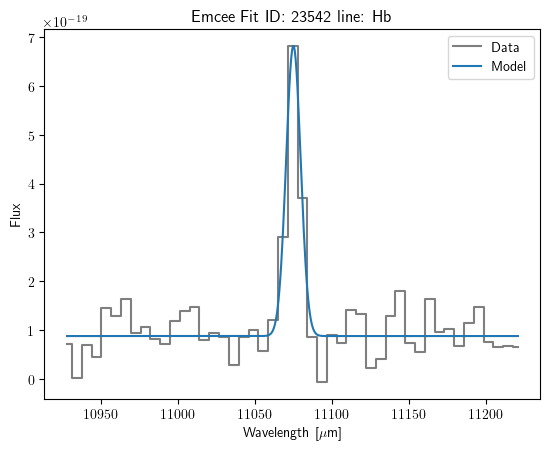

Minimization Guesses
A: 2.432895699899354e-19
mu: 11703.899251472907
sigma: 7.786518804894513
b: 4.093151128450466e-20



Minimization Guesses
A: 9.669038841832392e-20
mu: 10893.568454962186
sigma: 6.076233986260377
b: 3.3230925611510064e-20



Minimization Guesses
A: 1.0532611890108144e-19
mu: 12743.994398052828
sigma: 6.331763887050329
b: 1.0907552430411413e-20



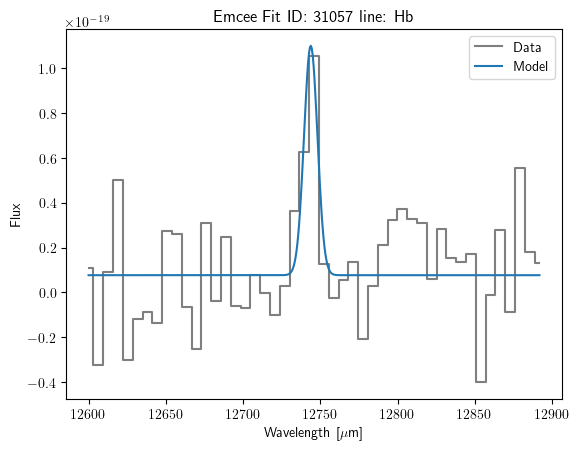

Minimization Guesses
A: 3.6026486267334354e-19
mu: 11748.229240634673
sigma: 4.758120416365273
b: -7.801264197971702e-21



Minimization Guesses
A: 1.8929681236848296e-20
mu: 25684.64062752706
sigma: 10.675768468228853
b: -2.083735868728823e-21



Minimization Guesses
A: 2.3694325074786825e-20
mu: 29218.731568535586
sigma: 17.962656283396427
b: 5.6651428209048016e-21



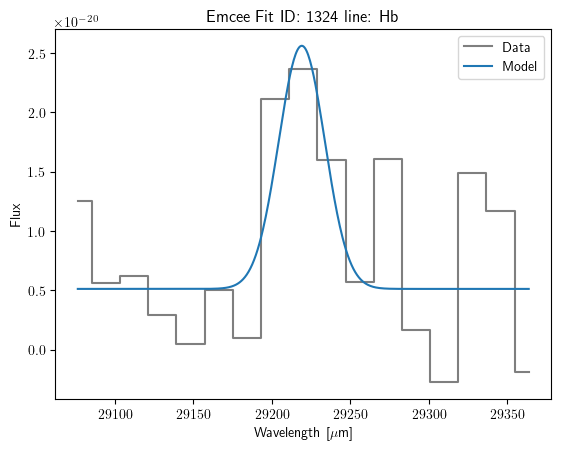

Minimization Guesses
A: 3.015455912601218e-20
mu: 25809.899850268906
sigma: 10.664833808867115
b: 4.011566341681148e-21



Minimization Guesses
A: 9.847662249772288e-21
mu: 28279.6811692728
sigma: 10.341357954337582
b: -4.7537996392260405e-21



Minimization Guesses
A: 7.029735150173492e-20
mu: 29340.167783512203
sigma: 8.976855075812637
b: 8.427226846241387e-22



Minimization Guesses
A: 6.894668659555697e-20
mu: 28613.02946752956
sigma: 7.932652921957924
b: -1.9694993501712204e-21



Minimization Guesses
A: 4.357584960494034e-20
mu: 26300.16119319866
sigma: 12.807255162228103
b: 9.772059780888677e-21



Minimization Guesses
A: 3.484654257671026e-20
mu: 21320.23550039341
sigma: 10.987603918019886
b: 3.8808751983282805e-22



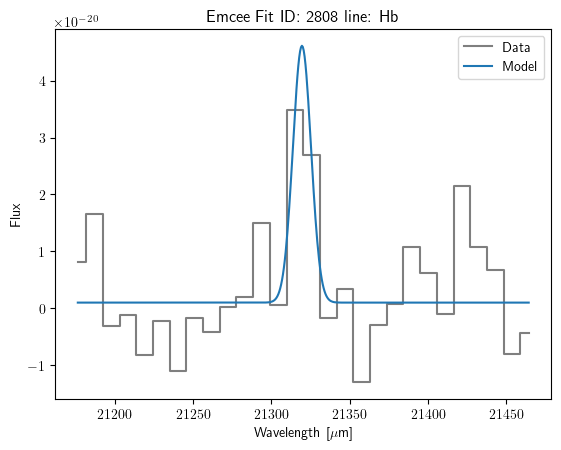

Minimization Guesses
A: 1.0973571603559438e-19
mu: 17561.679670759702
sigma: 11.080044290769365
b: 5.4912410554710155e-21



Minimization Guesses
A: 2.8523124667591766e-19
mu: 16966.36921138017
sigma: 10.464774417621811
b: 2.5869775427121084e-20



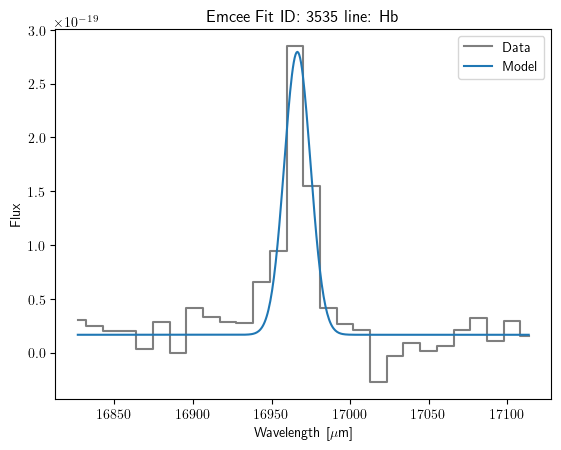

Minimization Guesses
A: 1.4931348889724133e-19
mu: 11676.015746979174
sigma: 6.5288430253613114
b: 2.6524674275564624e-20



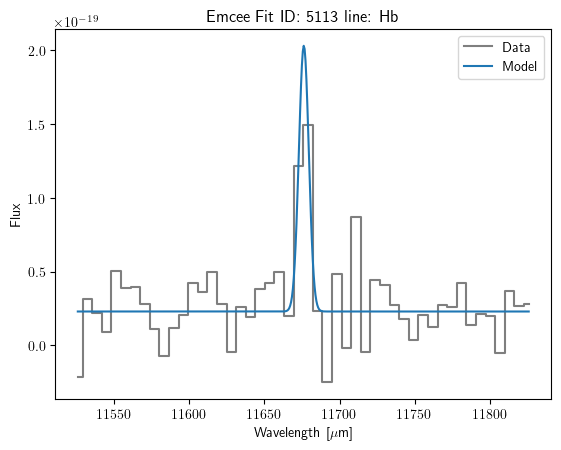

Minimization Guesses
A: 1.9048251048322923e-19
mu: 15486.650451356425
sigma: 7.2666219032817025
b: 3.061805780556394e-20



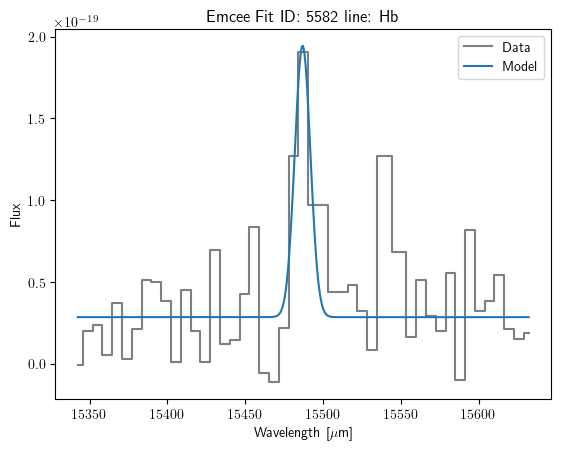

Minimization Guesses
A: 2.766120862869395e-19
mu: 12479.715927725996
sigma: 9.860256514968569
b: 7.060583216049908e-20



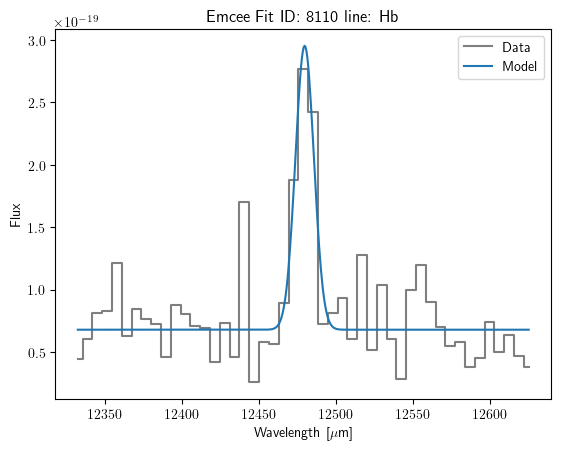

Minimization Guesses
A: 4.159877899719968e-19
mu: 12484.492530529975
sigma: 6.328936209702988
b: 6.776039850695923e-20



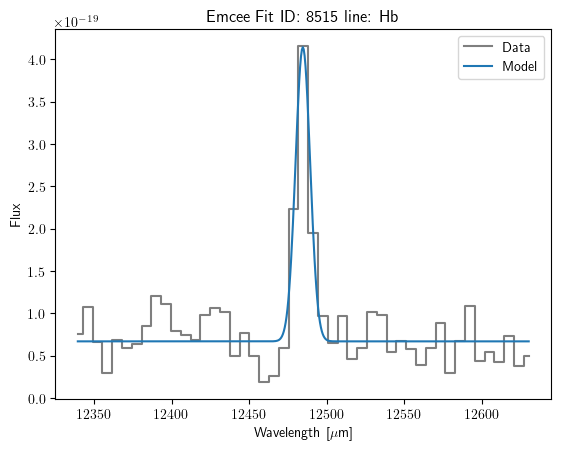

Minimization Guesses
A: 6.217474436790373e-19
mu: 14848.76995177451
sigma: 7.3569300884119
b: 7.300619551745066e-20



Minimization Guesses
A: 2.2364414896738996e-20
mu: 25621.152929756878
sigma: 7.083479007334972
b: -9.531044804853351e-22



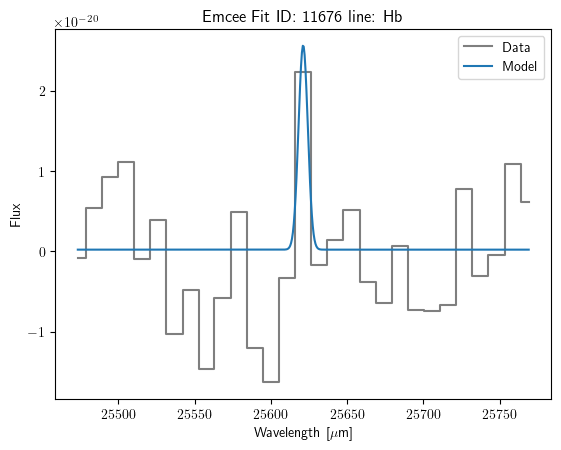

Minimization Guesses
A: 6.996366730683964e-20
mu: 19230.73885808107
sigma: 11.354273861432375
b: 2.017974616804224e-21



Minimization Guesses
A: 1.504952088441499e-19
mu: 21009.001109457073
sigma: 11.48355309951694
b: 8.021091767842172e-21



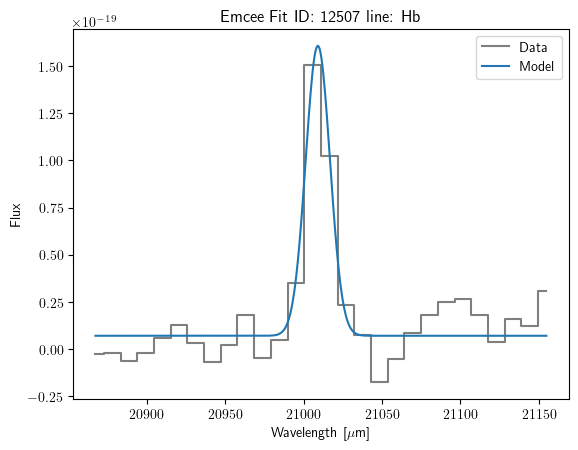

Minimization Guesses
A: 8.152193914056023e-20
mu: 18331.95599009248
sigma: 8.326014419069907
b: 6.510698151299476e-22



Minimization Guesses
A: 2.0480884413526288e-19
mu: 16403.809234650274
sigma: 7.29224530033207
b: 1.7272068515446673e-20



Minimization Guesses
A: 2.0393098633059896e-19
mu: 17678.397216061094
sigma: 13.030366881957889
b: 4.6699813459112744e-20



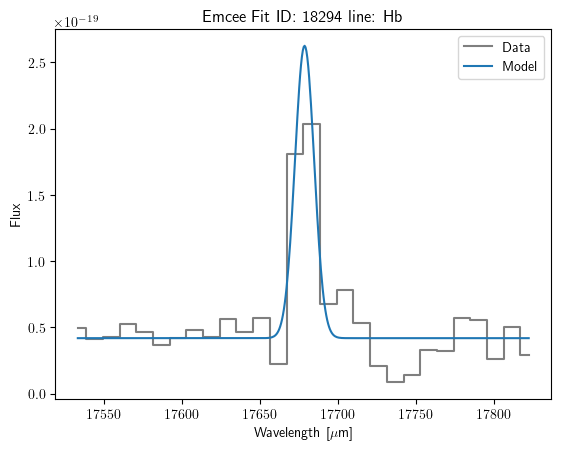

128 fitted sources


df  \
0                    A            mu      sigma  ...   
1                    A            mu      sigma  ...   
2                    A            mu      sigma  ...   
3                    A            mu      sigma  ...   
4                    A            mu      sigma  ...   

                                                wavs  \
0  [32263.374795228072, 32281.330730819373, 32299...   
1  [34124.460165737495, 34142.48669366872, 34160....   
2  [32278.196571380337, 32296.218348362818, 32314...   
3  [28525.448548710745, 28543.371220289977, 28561...   
4  [25508.14030892529, 25518.804002921006, 25529....   

                                              fluxes  \
0  [3.8659742241796627e-22, -1.2120640965790771e-...   
1  [7.546314607588643e-21, -2.1523462491628916e-2...   
2  [-1.0915220802150402e-21, 1.6615622166630881e-...   
3  [3.6885850280993375e-21, 9.138589968201595e-21...   
4  [1.113803395206732e-20, 2.5042021462141004e-21...   

                                          fluxes_err  \
0  [2.8857963137987322e-21, 1.9865991777515412e-2...   
1  [2.7761446244936344e-21, 2.1348842569634888e-2...   
2  [1.288145673148869e-21, 1.333813471064999e-21,...   
3  [3.5372645861371524e-21, 3.526928375906205e-21...   
4  [3.74383206193064e-21, 4.0789188957429134e-21,...   

                                       median_params             A  \
0  [2.0160882633453042e-20, 32401.39193003121, 12...  2.016088e-20   
1  [1.656043541989642e-20, 34267.32602314402, 25....  1.656044e-20   
2  [4.888540397546217e-21, 32409.09023089323, 17....  4.888540e-21   
3  [1.2176393260740898e-20, 28666.808242674546, 1...  1.217639e-20   
4  [1.700416627037703e-20, 25654.6977758787, 15.3...  1.700417e-20   

                                               A_err            mu      sigma  \
0  [1.4661304157687282e-21, 3.6434492865055184e-2...  32401.391930  12.271684   
1  [3.092920499436756e-23, 1.947188995421226e-21,...  34267.326023  25.051709   
2  [1.2845241571556553e-22, 2.0112325368086535e-2...  32409.090231  17.795509   
3  [4.739304472995428e-22, 4.959650494246394e-21,...  28666.808243  12.259677   
4  [5.817923370552408e-23, 3.705620401815813e-21,...  25654.697776  15.326845   

                                           sigma_err             b  
0  [0.14522753685229084, 2.6675783147484005, 2.95...  1.394010e-21  
1  [0.21513841512363996, 2.573538320176077, 3.003...  3.787310e-22  
2  [0.8859400083661448, 6.901535109470899, 8.6734...  6.216763e-22  
3  [0.6675559173491781, 5.257451785228749, 6.5925...  2.587262e-21  
4  [0.09595796073141294, 3.6424788803979364, 3.83...  1.408647e-21

In [47]:
# intializing dataframe
line_name = 'Hb'
line_window = 150  # [A]
columns = ['df', 'wavs','fluxes','fluxes_err','median_params','A','A_err','mu','sigma','sigma_err','b']
Hb_emcee_df = pd.DataFrame(columns=columns)

for source in range(len(NIRSpec_df['ID'])):
    
    try:
        check_wave, check_flux, check_flux_err, check_df = fitting_Hb_line(wavs_cleaned[source],
                                                                           fluxes_cleaned[source],
                                                                           fluxes_err_cleaned[source],
                                                                           Hb_curve_fit_df['mu'][source],
                                                                           line_window, NIRSpec_df['ID'][source],
                                                                           line_name,save=False,diagnose=True)
        
        # median A, mu, sigma, b parameter values
        median_params = check_df.quantile(q=0.5).values[:-2]
        A = median_params[0]
        mu = median_params[1]
        sigma = median_params[2]
        b = median_params[3]
        
        # gathering errors
        A_quantile_16 = check_df.quantile(q=0.16).values[0]
        A_qunatile_84 = check_df.quantile(q=0.84).values[0]
        A_mean_quantiles = np.mean([A_quantile_16,A_qunatile_84])
    
        sigma_quantile_16 = check_df.quantile(q=0.16).values[2]
        sigma_qunatile_84 = check_df.quantile(q=0.84).values[2]
        sigma_mean_quantiles = np.mean([sigma_quantile_16,sigma_qunatile_84])
    
        # [mean err (mean of 16% & 84%), 16% err, 84% err]
        A_err = [np.abs(A-A_mean_quantiles),A-A_quantile_16,A_qunatile_84-A]
        sigma_err = [np.abs(sigma-sigma_mean_quantiles),sigma-sigma_quantile_16,sigma_qunatile_84-sigma]
        
        new_row = [check_df,check_wave,check_flux,check_flux_err,median_params,A,A_err,mu,sigma,sigma_err,b]
        df_extended = pd.DataFrame(data=[new_row], columns=columns)
        Hb_emcee_df = pd.concat([Hb_emcee_df, df_extended],ignore_index=True)

    except Exception as e:
        print(f"Error processing source {source}: {e}")

print(len(Hb_emcee_df),'fitted sources')
Hb_emcee_df.head()

### emcee results

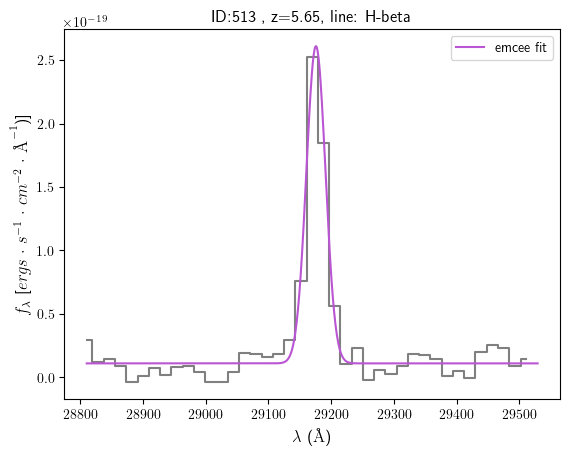

In [70]:
source = 6

# H-alpha
Ha_wavs = wavs_cleaned[source][Ha_center[source]-window:Ha_center[source]+window]
Ha_fluxes = fluxes_cleaned[source][Ha_center[source]-window:Ha_center[source]+window]
x_array = np.linspace(wavs_cleaned[source][Ha_center[source]-window],wavs_cleaned[source][Ha_center[source]+window],1000)
plt.figure()
plt.title(f'ID:{NIRSpec_df['ID'][source]} , z={round(NIRSpec_df['REDSHIFT'][source],2)}, line: H-alpha')
plt.xlabel(r'$\lambda$ ($\rm{\AA}$)',fontsize=12)
plt.ylabel(r'$f_{\lambda}$ [$ergs$ $\cdot$ $s^{-1}$ $\cdot$ $cm^{-2}$ $\cdot$ $\rm{\AA}^{-1}$)]',fontsize=12)
plt.step(Ha_wavs, Ha_fluxes, c='grey',where='mid')
plt.plot(x_array,Ha_line_model(x_array,*Ha_emcee_df['median_params'][source]),color='#BA55D3',label='emcee fit')
plt.legend()
plt.savefig('example_emcee_Ha.png',dpi=500)
plt.show()

# H-beta
Hb_wavs = wavs_cleaned[source][Hb_center[source]-window:Hb_center[source]+window]
Hb_fluxes = fluxes_cleaned[source][Hb_center[source]-window:Hb_center[source]+window]
x_array = np.linspace(wavs_cleaned[source][Hb_center[source]-window],wavs_cleaned[source][Hb_center[source]+window],1000)
plt.figure()
plt.title(f'ID:{NIRSpec_df['ID'][source]} , z={round(NIRSpec_df['REDSHIFT'][source],2)}, line: H-beta')
plt.xlabel(r'$\lambda$ ($\rm{\AA}$)',fontsize=12)
plt.ylabel(r'$f_{\lambda}$ [$ergs$ $\cdot$ $s^{-1}$ $\cdot$ $cm^{-2}$ $\cdot$ $\rm{\AA}^{-1}$)]',fontsize=12)
plt.step(Hb_wavs, Hb_fluxes, c='grey',where='mid')
plt.plot(x_array,Hb_line_model(x_array,*Hb_emcee_df['median_params'][source]),color='#BA55D3',label='emcee fit')
plt.legend()
plt.savefig('example_emcee_Hb.png',dpi=500)
plt.show()

### Dust correcting + obtaining integrated line flux & luminosity

In [50]:
def integ_line_flux(A, sigma, A_err, sigma_err): 
    '''
    obtain integrated line flux by computing area of Gaussian

    args:
        A (float): measured flux density of line peak [erg/(s*cm^2*A)]
        sigma (float): stdev of gaussian
        A_err (float): associated error
        sigma_err (float): associated error
        
    returns (tuple): integrated line flux and associated error [erg/(s*cm^2)]
    '''
    integ_flux = A*sigma*np.sqrt(2*np.pi) 
    integ_flux_err = integ_flux*np.sqrt((A_err/A)**2 + (sigma_err/sigma)**2)
    return integ_flux, integ_flux_err

def luminosity_conversion(integ_flux, z_val):
    '''
    flux to luminosity conversion

    args:
        flux (float): integrated line flux [erg/(s*cm^2)]
        z_val (float): redshift of source
    
    returns (tuple): integrated line luminosity and associated error [erg/s]
    '''
    lum_dist = cosmo.luminosity_distance(z_val).to(u.cm).value
    integ_lum = 4 * np.pi * (lum_dist**2) * integ_flux
    return integ_lum

def reddening(Ha_integ_flux_obs, Hb_integ_flux_obs):
    '''
    Eq (3) and (4) from Calzetti 2001 
    
    args:
        Ha_integ_flux_obs (float): observed integrated line flux of Ha emission line
        Hb_integ_flux_obs (float): observed integrated line flux of Hb emission line

    returns (float): E(B-V) reddening of source
    '''
    # intrinsic ratio and differential extinction between the two wavelengths
    Ha_Hb_intrinsic_lum_ratio = 2.87
    Ha_Hb_extinction = 1.163
    R_factor = Ha_Hb_intrinsic_lum_ratio / (Ha_integ_flux_obs / Hb_integ_flux_obs)
    reddening = np.log10(R_factor) / (0.4*Ha_Hb_extinction)
    return reddening

def dust_correction(Ha_integ_flux_obs, Hb_integ_flux_obs, Ha_flux_density_obs, Hb_flux_density_obs):
    '''
    Eq (7), (8a), and (8b) from Calzetti 2001 
    calls reddening function defined above

    args:
        Ha_integ_flux_obs (float): observed integrated line flux of Ha emission line [erg/(s*cm^2)]
        Hb_integ_flux_obs (float): observed integrated line flux of Hb emission line [erg/(s*cm^2)]
        Ha_flux_density_obs (float): observed flux density of Ha emission lines (for my case, this is taken as the emcee amplitude) [erg/(s*cm^2*A)]
        Hb_flux_density_obs (float): observed flux density of Hb emission lines (for my case, this is taken as the emcee amplitude) [erg/(s*cm^2*A)]

    returns (tuple): dust corrected flux densities for Ha and Hb
    '''
    # lambda rest 
    Ha_rest = 6562.819 # [A]
    Hb_rest = 4861.333 # [A]
    
    k_Ha = np.piecewise(Ha_rest,
                        [(Ha_rest >= 0.63 and Ha_rest <= 2.20),(Ha_rest >= 0.12 and Ha_rest <= 0.63)],
                        [lambda x: 1.17*(-1.857+(1.040/Ha_rest))+1.78,
                         lambda x: 1.17*(-2.156+(1.509/Ha_rest)-(0.198/(Ha_rest**2))+(0.011/(Ha_rest**3)))+1.78])
    k_Hb = np.piecewise(Hb_rest,
                        [(Hb_rest >= 0.63 and Hb_rest <= 2.20),(Hb_rest >= 0.12 and Hb_rest <= 0.63)],
                        [lambda x: 1.17*(-1.857+(1.040/Hb_rest))+1.78,
                         lambda x: 1.17*(-2.156+(1.509/Hb_rest)-(0.198/(Hb_rest**2))+(0.011/(Hb_rest**3)))+1.78])
    
    power_Ha = 0.4*reddening(Ha_integ_flux_obs, Hb_integ_flux_obs)*k_Ha
    power_Hb = 0.4*reddening(Ha_integ_flux_obs, Hb_integ_flux_obs)*k_Hb
    Ha_flux_density_corr = Ha_flux_density_obs*(10**power_Ha)
    Hb_flux_density_corr = Hb_flux_density_obs*(10**power_Hb)
    return Ha_flux_density_corr, Hb_flux_density_corr

def pipeline(Ha_emcee_df,Hb_emcee_df,z_vals): 
    '''
    function combining integ_line_flux, luminosity_conversion, and dust_correction functions for my data
    
    1) computes observed integrated line flux for Ha and Hb using emcee outputs
    2) computes corrected flux density for Ha and Hb using dust_correction function (using integrated fluxes for reddening function)
    3) computes the corrected integrated line flux for Ha and Hb --> eventually save to dataframe 
    4) converts these to corrected integrated luminosities for Ha and Hb --> eventually save to dataframe

    args:
        Ha_emcee_df (dataframe): outputted emcee parameters for Ha emission lines
        Hb_emcee_df (dataframe): outputted emcee parameters for Hb emission lines
        z_vals (list): redshifts of sources

    returns (tuple): lists of dust corrected integrated fluxes, luminosities, and associated errors (mean, 16th, 84th) for Ha and Hb emission lines
    '''
    z_vals = NIRSpec_df['REDSHIFT']
    
    # 1
    # calculating flux based off of mean error (mean error is indexed at 0)
    Ha_integ_flux_obs = [integ_line_flux(Ha_emcee_df['A'][i],Ha_emcee_df['sigma'][i],Ha_emcee_df['A_err'][i][0],Ha_emcee_df['sigma_err'][i][0])[0] for i in range(len(Ha_emcee_df))]
    # [mean flux err, 16% flux err, 84% flux err]
    Ha_integ_flux_obs_err = [[integ_line_flux(Ha_emcee_df['A'][i],Ha_emcee_df['sigma'][i],Ha_emcee_df['A_err'][i][0],Ha_emcee_df['sigma_err'][i][0])[1],
                              integ_line_flux(Ha_emcee_df['A'][i],Ha_emcee_df['sigma'][i],Ha_emcee_df['A_err'][i][1],Ha_emcee_df['sigma_err'][i][1])[1],
                              integ_line_flux(Ha_emcee_df['A'][i],Ha_emcee_df['sigma'][i],Ha_emcee_df['A_err'][i][2],Ha_emcee_df['sigma_err'][i][2])[1]] for i in range(len(Ha_emcee_df))]
    # calculating flux based off of mean error (mean error is indexed at 0)
    Hb_integ_flux_obs = [integ_line_flux(Hb_emcee_df['A'][i],Hb_emcee_df['sigma'][i],Hb_emcee_df['A_err'][i][0],Hb_emcee_df['sigma_err'][i][0])[0] for i in range(len(Hb_emcee_df))]
    # [mean flux err, 16% flux err, 84% flux err]
    Hb_integ_flux_obs_err = [[integ_line_flux(Hb_emcee_df['A'][i],Hb_emcee_df['sigma'][i],Hb_emcee_df['A_err'][i][0],Hb_emcee_df['sigma_err'][i][0])[1],
                              integ_line_flux(Hb_emcee_df['A'][i],Hb_emcee_df['sigma'][i],Hb_emcee_df['A_err'][i][1],Hb_emcee_df['sigma_err'][i][1])[1],
                              integ_line_flux(Hb_emcee_df['A'][i],Hb_emcee_df['sigma'][i],Hb_emcee_df['A_err'][i][2],Hb_emcee_df['sigma_err'][i][2])[1]] for i in range(len(Hb_emcee_df))]
    
    # 2
    # intrinsic (corrected) flux densities
    Ha_flux_density_corr = [dust_correction(Ha_integ_flux_obs[i],Hb_integ_flux_obs[i],Ha_emcee_df['A'][i],Hb_emcee_df['A'][i])[0] for i in range(len(Ha_emcee_df))]
    Hb_flux_density_corr = [dust_correction(Ha_integ_flux_obs[i],Hb_integ_flux_obs[i],Ha_emcee_df['A'][i],Hb_emcee_df['A'][i])[1] for i in range(len(Hb_emcee_df))]

    # associated errors
    Ha_flux_density_corr_err = [[dust_correction(Ha_integ_flux_obs_err[i][0],Hb_integ_flux_obs_err[i][0],Ha_emcee_df['A_err'][i][0],Hb_emcee_df['A_err'][i][0])[0],
                                 dust_correction(Ha_integ_flux_obs_err[i][1],Hb_integ_flux_obs_err[i][1],Ha_emcee_df['A_err'][i][1],Hb_emcee_df['A_err'][i][1])[0],
                                 dust_correction(Ha_integ_flux_obs_err[i][2],Hb_integ_flux_obs_err[i][2],Ha_emcee_df['A_err'][i][2],Hb_emcee_df['A_err'][i][2])[0]] for i in range(len(Ha_emcee_df))]
    Hb_flux_density_corr_err = [[dust_correction(Ha_integ_flux_obs_err[i][0],Hb_integ_flux_obs_err[i][0],Ha_emcee_df['A_err'][i][0],Hb_emcee_df['A_err'][i][0])[1],
                                 dust_correction(Ha_integ_flux_obs_err[i][1],Hb_integ_flux_obs_err[i][1],Ha_emcee_df['A_err'][i][1],Hb_emcee_df['A_err'][i][1])[1],
                                 dust_correction(Ha_integ_flux_obs_err[i][2],Hb_integ_flux_obs_err[i][2],Ha_emcee_df['A_err'][i][2],Hb_emcee_df['A_err'][i][2])[1]] for i in range(len(Hb_emcee_df))]
    
    # 3
    # intrinsic (corrected) integrated flux
    # calculating flux based off of mean error (mean error is indexed at 0)
    Ha_integ_flux_corr = [integ_line_flux(Ha_flux_density_corr[i],Ha_emcee_df['sigma'][i],Ha_flux_density_corr_err[i][0],Ha_emcee_df['sigma_err'][i][0])[0] for i in range(len(Ha_emcee_df))]
    # [mean flux err, 16% flux err, 84% flux err]
    Ha_integ_flux_corr_err = [[integ_line_flux(Ha_flux_density_corr[i],Ha_emcee_df['sigma'][i],Ha_flux_density_corr_err[i][0],Ha_emcee_df['sigma_err'][i][0])[1],
                               integ_line_flux(Ha_flux_density_corr[i],Ha_emcee_df['sigma'][i],Ha_flux_density_corr_err[i][1],Ha_emcee_df['sigma_err'][i][1])[1],
                               integ_line_flux(Ha_flux_density_corr[i],Ha_emcee_df['sigma'][i],Ha_flux_density_corr_err[i][2],Ha_emcee_df['sigma_err'][i][2])[1]] for i in range(len(Ha_emcee_df))]
    # calculating flux based off of mean error (mean error is indexed at 0)
    Hb_integ_flux_corr = [integ_line_flux(Hb_flux_density_corr[i],Hb_emcee_df['sigma'][i],Hb_flux_density_corr_err[i][0],Hb_emcee_df['sigma_err'][i][0])[0] for i in range(len(Hb_emcee_df))]
    # [mean flux err, 16% flux err, 84% flux err]
    Hb_integ_flux_corr_err = [[integ_line_flux(Hb_flux_density_corr[i],Hb_emcee_df['sigma'][i],Hb_flux_density_corr_err[i][0],Hb_emcee_df['sigma_err'][i][0])[1],
                               integ_line_flux(Hb_flux_density_corr[i],Hb_emcee_df['sigma'][i],Hb_flux_density_corr_err[i][1],Hb_emcee_df['sigma_err'][i][1])[1],
                               integ_line_flux(Hb_flux_density_corr[i],Hb_emcee_df['sigma'][i],Hb_flux_density_corr_err[i][2],Hb_emcee_df['sigma_err'][i][2])[1]] for i in range(len(Hb_emcee_df))]

    # 4 
    # intrinsic (corrected) integrated luminosity
    # calculating luminosity based off of mean error (mean error is indexed at 0)
    Ha_integ_lum_corr = [luminosity_conversion(Ha_integ_flux_corr[i],z_vals[i]) for i in range(len(Ha_emcee_df))]
    # [mean lum err, 16% lum err, 84% lum err]
    Ha_integ_lum_corr_err = [[luminosity_conversion(Ha_integ_flux_corr_err[i][0],z_vals[i]),
                              luminosity_conversion(Ha_integ_flux_corr_err[i][1],z_vals[i]),
                              luminosity_conversion(Ha_integ_flux_corr_err[i][2],z_vals[i])] for i in range(len(Ha_emcee_df))]
    # calculating luminosity based off of mean error (mean error is indexed at 0)
    Hb_integ_lum_corr = [luminosity_conversion(Hb_integ_flux_corr[i],z_vals[i]) for i in range(len(Hb_emcee_df))]
    # [mean lum err, 16% lum err, 84% lum err]
    Hb_integ_lum_corr_err = [[luminosity_conversion(Hb_integ_flux_corr_err[i][0],z_vals[i]),
                              luminosity_conversion(Hb_integ_flux_corr_err[i][1],z_vals[i]),
                              luminosity_conversion(Hb_integ_flux_corr_err[i][2],z_vals[i])] for i in range(len(Hb_emcee_df))]

    return Ha_integ_flux_corr, Hb_integ_flux_corr, Ha_integ_flux_corr_err, Hb_integ_flux_corr_err, Ha_integ_lum_corr, Hb_integ_lum_corr, Ha_integ_lum_corr_err, Hb_integ_lum_corr_err

### Saving source info and measurements

In [52]:
Ha_integ_flux_corr, Hb_integ_flux_corr, Ha_integ_flux_corr_err, Hb_integ_flux_corr_err, Ha_integ_lum_corr, Hb_integ_lum_corr, Ha_integ_lum_corr_err, Hb_integ_lum_corr_err = pipeline(Ha_emcee_df,Hb_emcee_df,NIRSpec_df)

# updating table
NIRSpec_df.insert(2,'H-ALPHA INTEGRATED LUMINOSITY', Ha_integ_lum_corr)
NIRSpec_df.insert(3,'H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR', [Ha_integ_lum_corr_err[i][0] for i in range(len(Ha_emcee_df))])
NIRSpec_df.insert(4,'H-ALPHA INTEGRATED LUMINOSITY 16% ERROR', [Ha_integ_lum_corr_err[i][1] for i in range(len(Ha_emcee_df))])
NIRSpec_df.insert(5,'H-ALPHA INTEGRATED LUMINOSITY 84% ERROR', [Ha_integ_lum_corr_err[i][2] for i in range(len(Ha_emcee_df))])
NIRSpec_df.insert(6,'H-BETA INTEGRATED LUMINOSITY', Hb_integ_lum_corr)
NIRSpec_df.insert(7,'H-BETA INTEGRATED LUMINOSITY MEAN ERROR', [Hb_integ_lum_corr_err[i][0] for i in range(len(Hb_emcee_df))])
NIRSpec_df.insert(8,'H-BETA INTEGRATED LUMINOSITY 16% ERROR', [Hb_integ_lum_corr_err[i][1] for i in range(len(Hb_emcee_df))])
NIRSpec_df.insert(9,'H-BETA INTEGRATED LUMINOSITY 84% ERROR', [Hb_integ_lum_corr_err[i][2] for i in range(len(Hb_emcee_df))])
NIRSpec_df.insert(10,'H-ALPHA INTEGRATED FLUX', Ha_integ_flux_corr)
NIRSpec_df.insert(11,'H-ALPHA INTEGRATED FLUX MEAN ERROR', [Ha_integ_flux_corr_err[i][0] for i in range(len(Ha_emcee_df))])
NIRSpec_df.insert(12,'H-ALPHA INTEGRATED FLUX 16% ERROR', [Ha_integ_flux_corr_err[i][1] for i in range(len(Ha_emcee_df))])
NIRSpec_df.insert(13,'H-ALPHA INTEGRATED FLUX 84% ERROR', [Ha_integ_flux_corr_err[i][2] for i in range(len(Ha_emcee_df))])
NIRSpec_df.insert(14,'H-BETA INTEGRATED FLUX', Hb_integ_flux_corr)
NIRSpec_df.insert(15,'H-BETA INTEGRATED FLUX MEAN ERROR', [Hb_integ_flux_corr_err[i][0] for i in range(len(Hb_emcee_df))])
NIRSpec_df.insert(16,'H-BETA INTEGRATED FLUX 16% ERROR', [Hb_integ_flux_corr_err[i][1] for i in range(len(Hb_emcee_df))])
NIRSpec_df.insert(17,'H-BETA INTEGRATED FLUX 84% ERROR', [Hb_integ_flux_corr_err[i][2] for i in range(len(Hb_emcee_df))])

In [53]:
NIRSpec_df.sort_values(by=['ID'],inplace=True)
NIRSpec_df = NIRSpec_df.reset_index(drop=True)
NIRSpec_df.to_csv('sample_Balmer.csv',index=False)
NIRSpec_df

ID  REDSHIFT  H-ALPHA INTEGRATED LUMINOSITY  \
0      323  5.667781                   2.590378e+42   
1      355  6.100327                   2.227345e+42   
2      381  5.505045                   1.216074e+42   
3      386  6.612528                   1.241948e+42   
4      397  6.000576                   1.080890e+43   
..     ...       ...                            ...   
123  29756  1.239912                   3.028216e+40   
124  31057  1.621038                   8.263794e+40   
125  31075  1.283137                   3.276332e+41   
126  36119  1.911995                   5.507181e+40   
127  37597  1.416468                   1.756151e+41   

     H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR  \
0                                2.012511e+41   
1                                2.334405e+39   
2                                3.209706e+39   
3                                4.426539e+39   
4                                1.538812e+39   
..                                        ...   
123                              1.257250e+38   
124                              9.023853e+37   
125                              6.945467e+38   
126                              3.390945e+39   
127                              3.628959e+38   

     H-ALPHA INTEGRATED LUMINOSITY 16% ERROR  \
0                               6.623902e+41   
1                               1.190380e+41   
2                               1.076674e+41   
3                               1.435680e+41   
4                               2.141968e+41   
..                                       ...   
123                             4.056832e+39   
124                             5.289918e+39   
125                             1.099033e+40   
126                             1.479400e+40   
127                             7.160157e+39   

     H-ALPHA INTEGRATED LUMINOSITY 84% ERROR  H-BETA INTEGRATED LUMINOSITY  \
0                               8.483472e+41                  1.152682e+42   
1                               1.150471e+41                  6.915973e+41   
2                               1.127209e+41                  8.614089e+40   
3                               1.515168e+41                  2.770874e+41   
4                               2.112040e+41                  3.908151e+42   
..                                       ...                           ...   
123                             4.150702e+39                  8.770802e+39   
124                             5.461673e+39                  2.860636e+40   
125                             1.047340e+40                  1.098853e+41   
126                             1.797803e+40                  3.073228e+40   
127                             6.551332e+39                  7.052298e+40   

     H-BETA INTEGRATED LUMINOSITY MEAN ERROR  \
0                               3.032117e+39   
1                               1.608721e+39   
2                               1.311409e+40   
3                               2.620224e+40   
4                               7.856717e+38   
..                                       ...   
123                             7.995087e+38   
124                             1.227927e+39   
125                             2.347219e+38   
126                             5.167619e+38   
127                             1.682259e+38   

     H-BETA INTEGRATED LUMINOSITY 16% ERROR  \
0                              8.083432e+40   
1                              7.122139e+40   
2                              4.704416e+40   
3                              1.240500e+41   
4                              1.299206e+41   
..                                      ...   
123                            3.182483e+39   
124                            9.430322e+39   
125                            7.169133e+39   
126                            9.936566e+39   
127                            4.884776e+39   

     H-BETA INTEGRATED LUMINOSITY 84% ERROR  H-ALPHA INTEGRATED FLUX  \
0                             